# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet

/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

Source data pulled from: http://www.trumptwitterarchive.com/archive
- Time span: 1/20/2017 to 8/28/2018
- Click button to export JSON, which basically just fills in a textarea above the search interface. Copy/paste that text into a text file and save it as a json.

In [2]:
with open('data/since-20170120.json') as f:
    jsondata = json.load(f)
    analyzer = SentimentIntensityAnalyzer()

for row in jsondata:
    try: 
        text = row['text']
    except KeyError: 
        text = row['full_text']
    vs = analyzer.polarity_scores(text)
    row['sentiment'] = vs

with open('data/since-20170120-processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [3]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to year
def convertUTCtoYear(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to year-month
def convertUTCtoYearMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# convert to year + week of year
def convertUTCtoYearWeekNumber(date):
    utc = arrow.get(date)
    year = utc.to('US/Eastern').format('YYYY')
    weekno = int(date.strftime('%U'))
    return str(year) + '-' + str(weekno).zfill(2)
#     return int(str(year) + str(weekno).zfill(2))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [4]:
with open('data/since-20170120-processed.json') as f:
    jsondata = json.load(f)

normalized_json = pd.io.json.json_normalize(jsondata)

tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])
tweets['id'] = tweets['id_str']
tweets.text.fillna(tweets.text, inplace=True)

Add many time grouping columns.

**IMPORTANT CAVEAT:** Not all of these differentiate between 2017 and 2018. When doing your analysis, take care that, say, tweets from Aug 2017 and Aug. 2018 aren't aggregated together later. (Unless that's your intention.)

In [5]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['year'] = tweets['created_date'].apply(convertUTCtoYear)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['year_month'] = tweets['created_date'].apply(convertUTCtoYearMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber) 
tweets['year_week'] = tweets['created_date'].apply(convertUTCtoYearWeekNumber)
tweets['text encoded'] = tweets['text'].apply(encodeText)
tweets.set_index('created_date', inplace=True)

tweets.head()

,created_at,favorite_count,id_str,is_retweet,retweet_count,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,source,...,month/day,year,month,year_month,day,day of week,hour,week,year_week,text encoded
created_date,,,,,,,,,,,,,,,,,,,,,
2018-08-30 16:54:09,Thu Aug 30 16:54:09 +0000 2018,16594,1035209068095434752,False,4915,-0.4753,0.163,0.837,0.000,Twitter for iPhone,...,2018-08-30,2018,08,2018-08,30,4,12,34,2018-34,b'CNN is working frantically to find their sou...
2018-08-30 13:49:51,Thu Aug 30 13:49:51 +0000 2018,39948,1035162684633825286,False,10860,0.8353,0.062,0.738,0.200,Twitter for iPhone,...,2018-08-30,2018,08,2018-08,30,4,9,34,2018-34,"b'Will be going to Evansville, Indiana, tonigh..."
2018-08-30 13:39:00,Thu Aug 30 13:39:00 +0000 2018,30167,1035159956507566080,False,7603,-0.5375,0.166,0.655,0.179,Twitter for iPhone,...,2018-08-30,2018,08,2018-08,30,4,9,34,2018-34,b'I am very excited about the person who will ...
2018-08-30 13:17:48,Thu Aug 30 13:17:48 +0000 2018,30279,1035154621357064192,False,7264,-0.5411,0.270,0.626,0.104,Twitter for iPhone,...,2018-08-30,2018,08,2018-08,30,4,9,34,2018-34,b'The Rigged Russia Witch Hunt did not come in...
2018-08-30 12:54:13,Thu Aug 30 12:54:13 +0000 2018,45475,1035148684432953346,False,14722,0.8309,0.000,0.822,0.178,Twitter for iPhone,...,2018-08-30,2018,08,2018-08,30,4,8,34,2018-34,"b'Wow, Nellie Ohr, Bruce Ohrs wife, is a Russi..."



# Sources

In [6]:
# tweets['source_clean'] = tweets['source'].apply(stripHTML)
# tweets['source_clean'].unique()

tweets['source'].unique()

array(['Twitter for iPhone', 'Media Studio', 'Twitter for iPad',
       'Twitter Web Client', 'Twitter Ads', 'Twitter for Android'], dtype=object)

# Frequencies

## Total Tweets

In [7]:
len(tweets.index)

4564

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

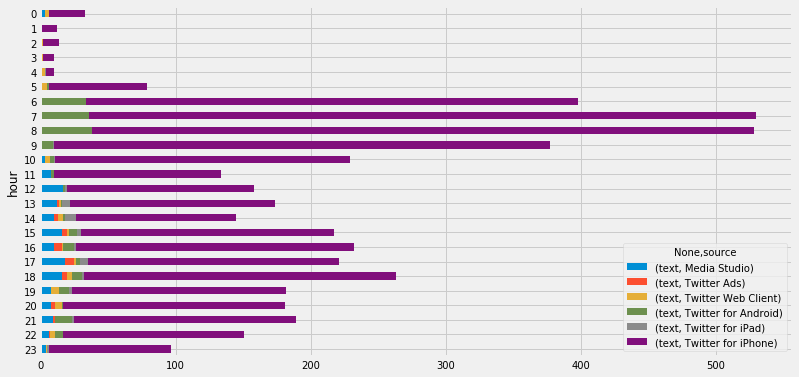

In [8]:
# tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
#     index='hour', columns=['source_clean'], aggfunc='count')

tweetsPerHour = tweets[['source', 'hour', 'text']].pivot_table(
    index='hour', columns=['source'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

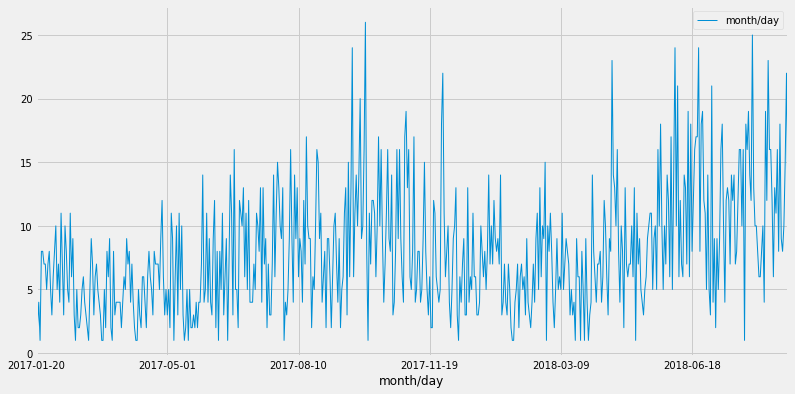

In [9]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
# tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,100), fontsize=8)
tweetsPerDay.plot(kind='line', linewidth=1.0)

In [10]:
tweetsPerDay.describe()

,month/day
count,574.000000
mean,7.951220
std,4.776804
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,26.000000


## Tweets per day of week

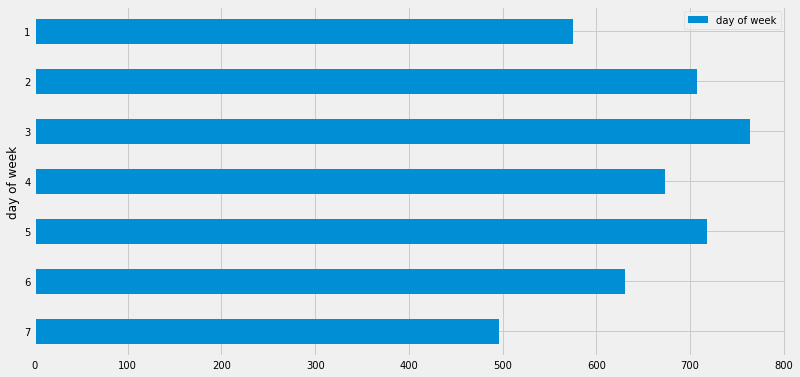

In [11]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')
# tweetsPerDayOfWeek.plot(kind='bar')

## Tweets per month

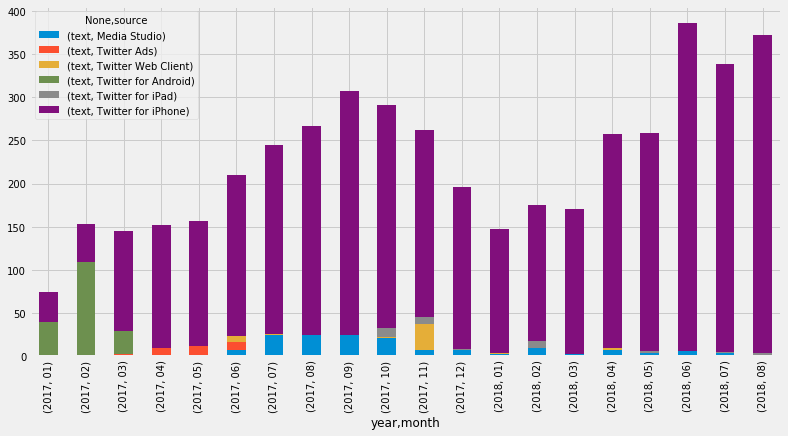

In [12]:
baseMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')

tweetsPerMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')
tweetsPerMonth = tweetsPerMonth.reindex_like(baseMonth)
# tweetsPerMonth.iloc[::-1].plot(kind='bar', stacked=True)
tweetsPerMonth.plot(kind='bar', stacked=True)

## Tweets per week

**IMPORTANT CAVEATS:**
- Weeks (2017, 53) and (2018, 1) might be the same week
- The way we're handling weekly data assumes that Trump tweets at least once per week -- which, so far, has held true. But if there's ever a week where he _doesn't_ tweet, then that could introduce a problem with the rendered charts. (The bar/week won't appear in the chart, and it might not be obvious that it's missing.)

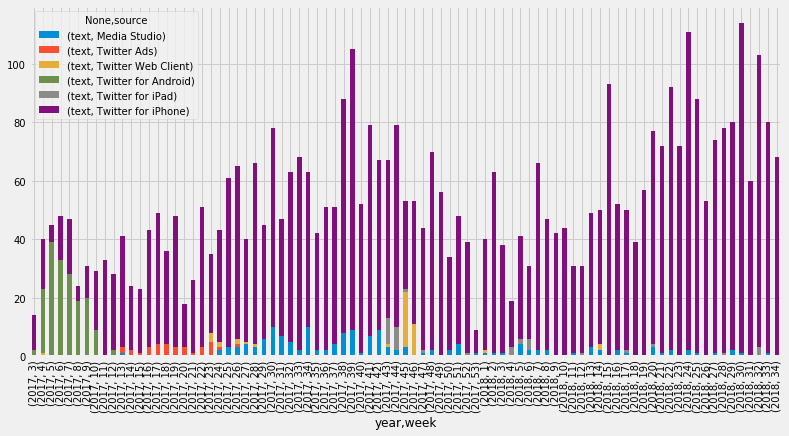

In [13]:
tweetsPerWeek = tweets[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Text analysis

Common words.

In [14]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/AHurt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,great,955,b'great'
1,&amp;,764,b'&amp;'
2,’,479,b''
3,!,432,b'!'
4,-,412,b'-'
5,",",390,"b','"
6,.,370,b'.'
7,people,348,b'people'
8,fake,323,b'fake'
9,big,316,b'big'


# Specific text searches

In [16]:
from IPython.display import display, Markdown

tweetsEnc = tweets.reset_index()

def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweetsEnc[tweetsEnc['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweetsEnc) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    
    # set up the base data frame for indexing purposes
    baseWeek = tweets[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
    baseMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')

    # set up the filtered data frame
    analyzedByWeek = filtered[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
    analyzedByMonth = filtered[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')
    analyzedByHour = filtered[['source', 'hour', 'text']].pivot_table(index=['hour'], columns=['source'], aggfunc='count')

    # adjust the filtered data frame to use the index from the base data frame
    analyzedByWeek = analyzedByWeek.reindex_like(baseWeek)
    analyzedByMonth = analyzedByMonth.reindex_like(baseMonth)
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)

    # output filtered csv
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
    analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))

    # spit out the plot
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()

    analyzedByMonthPlot = analyzedByMonth.plot(kind='bar', stacked=True, title='{0} by month'.format(search))
    plt.show()

    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()

#     analyzedByDay = filtered[['source', 'month/day', 'text']].pivot_table(index='month/day', columns=['source'], aggfunc='count')
#     analyzedByDay = analyzedByDay.reindex(range(tweetsEnc['month/day'].min(), tweetsEnc['month/day'].max())).fillna(0)
#     analyzedByDay = analyzedByDay.reindex(tweetsEnc['month/day']).fillna(0)

    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

## Search: _collusion_

Number of Tweets: 107

Percent of all Tweets: 2.34%

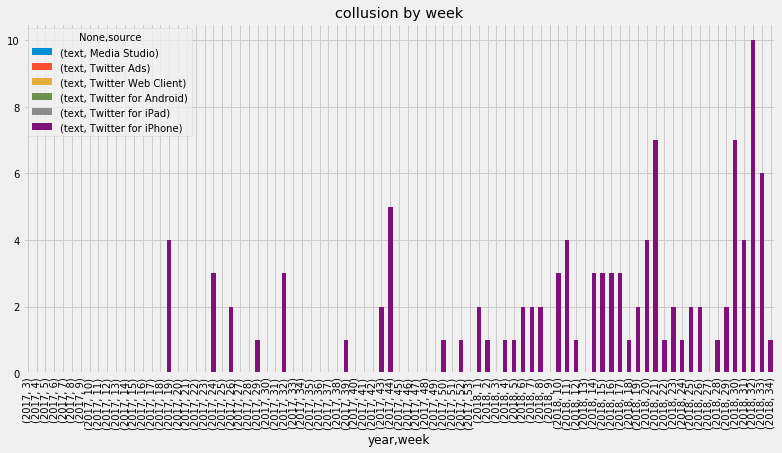

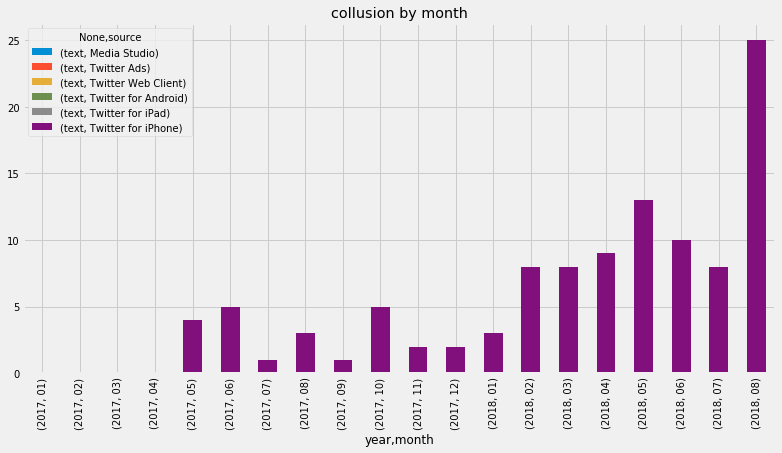

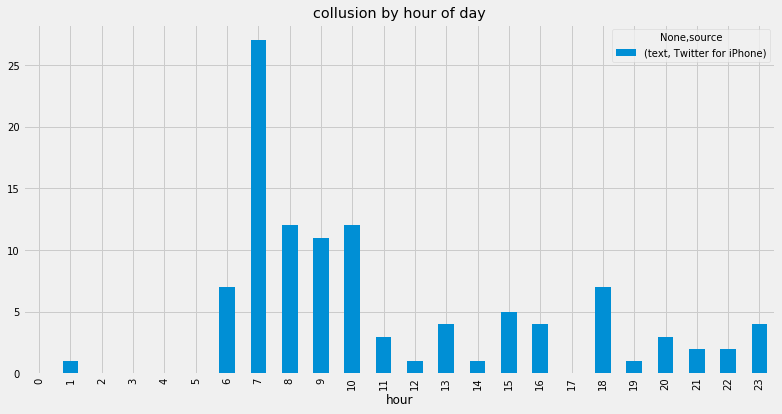

### The Tweets

[Thursday, Aug 30, 2018 8:54 AM](https://twitter.com/realDonaldTrump/status/1035148684432953346): Wow, Nellie Ohr, Bruce Ohr’s wife, is a Russia expert who is fluent in Russian. She worked for Fusion GPS where she was paid a lot. Collusion! Bruce was a boss at the Department of Justice and is, unbelievably, still there!

[Saturday, Aug 25, 2018 8:36 AM](https://twitter.com/realDonaldTrump/status/1033332301579661312): Jeff Sessions said he wouldn’t allow politics to influence him only because he doesn’t understand what is happening underneath his command position. Highly conflicted Bob Mueller and his gang of 17 Angry Dems are having a field day as real corruption goes untouched. No Collusion!

[Friday, Aug 24, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/1032937718219714560): ....FISA abuse, Christopher Steele &amp; his phony and corrupt Dossier, the Clinton Foundation, illegal surveillance of Trump Campaign, Russian collusion by Dems - and so much more. Open up the papers &amp; documents without redaction? Come on Jeff, you can do it, the country is waiting!

[Thursday, Aug 23, 2018 1:10 AM](https://twitter.com/realDonaldTrump/status/1032495180530835456): NO COLLUSION - RIGGED WITCH HUNT!

[Monday, Aug 20, 2018 7:48 AM](https://twitter.com/realDonaldTrump/status/1031508193107763200): Where’s the Collusion? They made up a phony crime called Collusion, and when there was no Collusion they say there was Obstruction (of a phony crime that never existed). If you FIGHT BACK or say anything bad about the Rigged Witch Hunt, they scream Obstruction!

[Monday, Aug 20, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/1031503298967363586): Disgraced and discredited Bob Mueller and his whole group of Angry Democrat Thugs spent over 30 hours with the White House Councel, only with my approval, for purposes of transparency. Anybody needing that much time when they know there is no Russian Collusion is just someone....

[Sunday, Aug 19, 2018 7:30 AM](https://twitter.com/realDonaldTrump/status/1031141396776984576): No Collusion and No Obstruction, except by Crooked Hillary and the Democrats. All of the resignations and corruption, yet heavily conflicted Bob Mueller refuses to even look in that direction. What about the Brennan, Comey, McCabe, Strzok lies to Congress, or Crooked’s Emails!

[Saturday, Aug 18, 2018 6:12 PM](https://twitter.com/realDonaldTrump/status/1030940529037651968): I allowed White House Counsel Don McGahn, and all other requested members of the White House Staff, to fully cooperate with the Special Counsel. In addition we readily gave over one million pages of documents. Most transparent in history. No Collusion, No Obstruction. Witch Hunt!

[Saturday, Aug 18, 2018 6:04 PM](https://twitter.com/realDonaldTrump/status/1030938589847269378): I allowed White House Counsel Don McGahn, and all other requested members of the White House Staff, to fully cooperate with the Special Councel. In addition we readily gave over one million pages of documents. Most transparent in history. No Collusion, No Obstruction. Witch Hunt!

[Thursday, Aug 16, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/1030091812495654912): The Boston Globe, which was sold to the the Failing New York Times for 1.3 BILLION DOLLARS (plus 800 million dollars in losses &amp; investment), or 2.1 BILLION DOLLARS, was then sold by the Times for 1 DOLLAR. Now the Globe is in COLLUSION with other papers on free press. PROVE IT!

[Wednesday, Aug 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/1029731513573822464): The Rigged Russian Witch Hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. All credibility is gone from this terrible Hoax, and much more will be lost as it proceeds. No Collusion!

[Tuesday, Aug 14, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1029355952414371841): Lou Dobbs: “This cannot go forward...this Special Counsel with all of his conflicts, with his 17 Angry Democrats, without any evidence of collusion by the Trump Campaign and Russia. The Dems are the ones who should be investigated.” Thank you Lou, so true!

[Tuesday, Aug 14, 2018 9:01 AM](https://twitter.com/realDonaldTrump/status/1029352395464224769): Fired FBI Agent Peter Strzok is a fraud, as is the rigged investigation he started. There was no Collusion or Obstruction with Russia, and everybody, including the Democrats, know it. The only Collusion and Obstruction was by Crooked Hillary, the Democrats and the DNC!

[Tuesday, Aug 14, 2018 7:21 AM](https://twitter.com/realDonaldTrump/status/1029327223269060609): Lou Dobbs: “This cannot go forward...this Special Councel with all of his conflicts, with his 17 Angry Democrats, without any evidence of collusion by the Trump Campaign and Russia. The Dems are the ones who should be investigated.” Thank you Lou, so true!

[Tuesday, Aug 14, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1029321624603054080): Tom Fitton of Judicial Watch: “The Strzok firing is as much about the Mueller operation as anything else. There would be no Mueller Special Councel to investigate so called collusion but for the machinations of Strzok &amp; his colleagues at the top levels of the FBI. We know this...

[Monday, Aug 13, 2018 12:04 PM](https://twitter.com/realDonaldTrump/status/1029036065158557701): Agent Peter Strzok was just fired from the FBI - finally. The list of bad players in the FBI &amp; DOJ gets longer &amp; longer. Based on the fact that Strzok was in charge of the Witch Hunt, will it be dropped? It is a total Hoax. No Collusion, No Obstruction - I just fight back!

[Sunday, Aug 12, 2018 8:24 AM](https://twitter.com/realDonaldTrump/status/1028618150944944129): .@JudgeJeanine  “Bob Mueller, isn’t your whole investigation premised on a Fake Dossier, paid for by Hillary, created by a man who hates Donald Trump, &amp; used to con a FISA Court Judge. Bob, I really think it’s time for you to give up your phony investigation.” No Collusion!

[Friday, Aug 10, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/1027884715553050625): .@MariaBartiromo  “No evidence to launch even an investigation into potential collusion between Donald Trump and the Russians - and here we are, a year and a half later.”

[Thursday, Aug 9, 2018 9:22 AM](https://twitter.com/realDonaldTrump/status/1027545694201159680): “There has been no evidence whatsoever that Donald Trump or the campaign was involved in any kind of collusion to fix the 2016 election. In fact the evidence is the opposite, that Hillary Clinton &amp; the Democrats colluded with the Russians to fix the 2016 election.” @GrahamLedger

[Monday, Aug 6, 2018 10:25 AM](https://twitter.com/realDonaldTrump/status/1026474458326986752): ....a law firm, eventually Kremlin connected sources, to gather info on Donald Trump. Collusion is very real with Russia, but only with Hillary and the Democrats, and we should demand a full investigation.” Dan Bongino on @foxandfriends  Looking forward to the new IG Report!

[Monday, Aug 6, 2018 10:13 AM](https://twitter.com/realDonaldTrump/status/1026471244949061632): “Collusion with Russia was very real. Hillary Clinton and her team 100% colluded with the Russians, and so did Adam Schiff who is on tape trying to collude with what he thought was Russians to obtain compromising material on DJT. We also know that Hillary Clinton paid through....

[Friday, Aug 3, 2018 11:28 PM](https://twitter.com/realDonaldTrump/status/1025584134322892800): ...Dianne is the person leading our Nation on “Collusion” with Russia (only done by Dems). Will she now investigate herself? https://t.co/OG6l04bBwg

[Wednesday, Aug 1, 2018 11:35 AM](https://twitter.com/realDonaldTrump/status/1024680095343108097): Looking back on history, who was treated worse, Alfonse Capone, legendary mob boss, killer and “Public Enemy Number One,” or Paul Manafort, political operative &amp; Reagan/Dole darling, now serving solitary confinement - although convicted of nothing? Where is the Russian Collusion?

[Wednesday, Aug 1, 2018 10:01 AM](https://twitter.com/realDonaldTrump/status/1024656465158721536): Russian Collusion with the Trump Campaign, one of the most successful in history, is a TOTAL HOAX. The Democrats paid for the phony and discredited Dossier which was, along with Comey, McCabe, Strzok and his lover, the lovely Lisa Page, used to begin the Witch Hunt. Disgraceful!

[Wednesday, Aug 1, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/1024649463435067398): Paul Manafort worked for Ronald Reagan, Bob Dole and many other highly prominent and respected political leaders. He worked for me for a very short time. Why didn’t government tell me that he was under investigation. These old charges have nothing to do with Collusion - a Hoax!

[Tuesday, Jul 31, 2018 7:58 AM](https://twitter.com/realDonaldTrump/status/1024263146008207361): Collusion is not a crime, but that doesn’t matter because there was No Collusion (except by Crooked Hillary and the Democrats)!

[Sunday, Jul 29, 2018 4:20 PM](https://twitter.com/realDonaldTrump/status/1023664624259014656): ....Also, why is Mueller only appointing Angry Dems, some of whom have worked for Crooked Hillary, others, including himself, have worked for Obama....And why isn’t Mueller looking at all of the criminal activity &amp; real Russian Collusion on the Democrats side-Podesta, Dossier?

[Sunday, Jul 29, 2018 3:35 PM](https://twitter.com/realDonaldTrump/status/1023653191974625280): There is No Collusion! The Robert Mueller Rigged Witch Hunt, headed now by 17 (increased from 13, including an Obama White House lawyer) Angry Democrats, was started by a fraudulent Dossier, paid for by Crooked Hillary and the DNC. Therefore, the Witch Hunt is an illegal Scam!

[Friday, Jul 27, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1022808452677160960): ....,the only Collusion with Russia was with the Democrats, so now they are looking at my Tweets (along with 53 million other people) - the rigged Witch Hunt continues! How stupid and unfair to our Country....And so the Fake News doesn’t waste my time with dumb questions, NO,....

[Friday, Jul 27, 2018 7:26 AM](https://twitter.com/realDonaldTrump/status/1022805381440069632): Arrived back in Washington last night from a very emotional reopening of a major U.S. Steel plant in Granite City, Illinois, only to be greeted with the ridiculous news that the highly conflicted Robert Mueller and his gang of 13 Angry Democrats obviously cannot find Collusion...

[Saturday, Jul 21, 2018 6:50 PM](https://twitter.com/realDonaldTrump/status/1020803264617615360): No Collusion, No Obstruction - but that doesn’t matter because the 13 Angry Democrats, who are only after Republicans and totally protecting Democrats, want this Witch Hunt to drag out to the November Election. Republicans better get smart fast and expose what they are doing!

[Saturday, Jul 7, 2018 4:42 PM](https://twitter.com/realDonaldTrump/status/1015697664514674689): Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Counsel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!

[Saturday, Jul 7, 2018 4:29 PM](https://twitter.com/realDonaldTrump/status/1015694335151656961): Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Councel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!

[Thursday, Jun 28, 2018 8:56 AM](https://twitter.com/realDonaldTrump/status/1012318771250384896): ....persecuted on old and/or totally unrelated charges (there was no collusion and there was no obstruction of the no collusion)...And what is going on in the FBI &amp; DOJ with Crooked Hillary, the DNC and all of the lies? A disgraceful situation!

[Thursday, Jun 28, 2018 7:02 AM](https://twitter.com/realDonaldTrump/status/1012290012279435265): Lover FBI Agent Peter Strzok was given poor marks on yesterday’s closed door testimony and, according to most reports, refused to answer many questions. There was no Collusion and the Witch Hunt, headed by 13 Angry Democrats and others who are totally conflicted, is Rigged!

[Sunday, Jun 17, 2018 10:54 AM](https://twitter.com/realDonaldTrump/status/1008362351807037441): WITCH HUNT! There was no Russian Collusion. Oh, I see, there was no Russian Collusion, so now they look for obstruction on the no Russian Collusion. The phony Russian Collusion was a made up Hoax. Too bad they didn’t look at Crooked Hillary like this. Double Standard!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278701996802048): So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, illegally leak (Comey) classified information so that a Special Councel will be appointed, and then Collude to make this pile of garbage take on life in Fake News!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278671097417729): Now that I am back from Singapore, where we had a great result with respect to North Korea, the thought process must sadly go back to the Witch Hunt, always remembering that there was No Collusion and No Obstruction of the fabricated No Crime.

[Tuesday, Jun 5, 2018 7:31 AM](https://twitter.com/realDonaldTrump/status/1003962584352030720): The Russian Witch Hunt Hoax continues, all because Jeff Sessions didn’t tell me he was going to recuse himself...I would have quickly picked someone else. So much time and money wasted, so many lives ruined...and Sessions knew better than most that there was No Collusion!

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1002892787803676673): ....“$17 million spent, it’s a scam Investigation. Americans are being worked. We now know there was Russian collusion, with Russians and the Democrats. The Mueller team is stacked with anti-Trumpers, who actually represented Clinton people (&amp; gave $’s to Crooked H).” Dan Bongino

[Friday, Jun 1, 2018 7:05 AM](https://twitter.com/realDonaldTrump/status/1002506360351846400): A.P. has just reported that the Russian Hoax Investigation has now cost our government over $17 million, and going up fast. No Collusion, except by the Democrats!

[Tuesday, May 29, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/1001417880116891650): The 13 Angry Democrats (plus people who worked 8 years for Obama) working on the rigged Russia Witch Hunt, will be MEDDLING with the mid-term elections, especially now that Republicans (stay tough!) are taking the lead in Polls. There was no Collusion, except by the Democrats!

[Sunday, May 27, 2018 10:13 AM](https://twitter.com/realDonaldTrump/status/1000741764565753856): Why didn’t the 13 Angry Democrats investigate the campaign of Crooked Hillary Clinton, many crimes, much Collusion with Russia? Why didn’t the FBI take the Server from the DNC?  Rigged Investigation!

[Sunday, May 27, 2018 8:41 AM](https://twitter.com/realDonaldTrump/status/1000718611688943616): Who’s going to give back the young and beautiful lives (and others) that have been devastated and destroyed by the phony Russia Collusion Witch Hunt? They journeyed down to Washington, D.C., with stars in their eyes and wanting to help our nation...They went back home in tatters!

[Saturday, May 26, 2018 3:56 PM](https://twitter.com/realDonaldTrump/status/1000465814192099330): When will the 13 Angry Democrats (&amp; those who worked for President O), reveal their disqualifying Conflicts of Interest? It’s been a long time now! Will they be indelibly written into the Report along with the fact that the only Collusion is with the Dems, Justice, FBI &amp; Russia?

[Wednesday, May 23, 2018 6:54 AM](https://twitter.com/realDonaldTrump/status/999242039723163648): Look how things have turned around on the Criminal Deep State. They go after Phony Collusion with Russia, a made up Scam, and end up getting caught in a major SPY scandal the likes of which this country may never have seen before! What goes around, comes around!

[Tuesday, May 22, 2018 9:13 PM](https://twitter.com/realDonaldTrump/status/999096013674680321): ...Follow the money! The spy was there early in the campaign and yet never reported Collusion with Russia, because there was no Collusion. He was only there to spy for political reasons and to help Crooked Hillary win - just like they did to Bernie Sanders, who got duped!

[Sunday, May 20, 2018 1:13 PM](https://twitter.com/realDonaldTrump/status/998250447394820096): The Witch Hunt finds no Collusion with Russia - so now they’re looking at the rest of the World. Oh’ great!

[Thursday, May 17, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/997076300476055552): Congratulations America, we are now into the second year of the greatest Witch Hunt in American History...and there is still No Collusion and No Obstruction. The only Collusion was that done by Democrats who were unable to win an Election despite the spending of far more money!

[Tuesday, May 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/996391840860471296): Can you believe that with all of the made up, unsourced stories I get from the Fake News Media, together with the  $10,000,000 Russian Witch Hunt (there is no Collusion), I now have my best Poll Numbers in a year. Much of the Media may be corrupt, but the People truly get it!

[Monday, May 7, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/993452275648679938): The Russia Witch Hunt is rapidly losing credibility. House Intelligence Committee found No Collusion, Coordination or anything else with Russia. So now the Probe says OK, what else is there? How about Obstruction for a made up, phony crime.There is no O, it’s called Fighting Back

[Wednesday, May 2, 2018 6:40 PM](https://twitter.com/realDonaldTrump/status/991809653980966913): “This isn’t some game. You are screwing with the work of the president of the United States.”  John Dowd, March 2018.  With North Korea, China, the Middle East and so much more, there is not much time to be thinking about this, especially since there was no Russian “Collusion.”

[Wednesday, May 2, 2018 7:45 AM](https://twitter.com/realDonaldTrump/status/991644756995444736): There was no Collusion (it is a Hoax) and there is no Obstruction of Justice (that is a setup &amp; trap). What there is is Negotiations going on with North Korea over Nuclear War, Negotiations going on with China over Trade Deficits, Negotiations on NAFTA, and much more. Witch Hunt!

[Tuesday, May 1, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/991267863674675200): So disgraceful that the questions concerning the Russian Witch Hunt were “leaked” to the media. No questions on Collusion. Oh, I see...you have a made up, phony crime, Collusion, that never existed, and an investigation begun with illegally leaked classified information. Nice!

[Saturday, Apr 28, 2018 3:11 PM](https://twitter.com/realDonaldTrump/status/990307626784362496): Secret Service has just informed me that Senator Jon Tester’s statements on Admiral Jackson are not true. There were no such findings. A horrible thing that we in D.C. must live with, just like phony Russian Collusion. Tester should lose race in Montana. Very dishonest and sick!

[Friday, Apr 27, 2018 10:04 PM](https://twitter.com/realDonaldTrump/status/990049088375836672): House Intelligence Committee rules that there was NO COLLUSION between the Trump Campaign and Russia. As I have been saying all along, it is all a big Hoax by the Democrats based on payments and lies. There should never have been a Special Counsel appointed. Witch Hunt!

[Friday, Apr 27, 2018 9:19 PM](https://twitter.com/realDonaldTrump/status/990037854884696064): House Intelligence Committee rules that there was NO COLLUSION between the Trump Campaign and Russia. As I have been saying all along, it is all a big Hoax by the Democrats based on payments and lies. There should never have been a Special Councel appointed. Witch Hunt!

[Saturday, Apr 21, 2018 6:27 PM](https://twitter.com/realDonaldTrump/status/987820268402946049): RT @dmartosko: The same can be said of the "collusion" stuff. https://t.co/xMCVuH3OTs

[Thursday, Apr 19, 2018 11:37 PM](https://twitter.com/realDonaldTrump/status/987173366401585155): James Comey Memos just out and show clearly that there was NO COLLUSION and NO OBSTRUCTION. Also, he leaked classified information. WOW! Will the Witch Hunt continue?

[Wednesday, Apr 18, 2018 8:05 AM](https://twitter.com/realDonaldTrump/status/986576502358671361): Slippery James Comey, the worst FBI Director in history, was not fired because of the phony Russia investigation where, by the way, there was NO COLLUSION (except by the Dems)!

[Friday, Apr 13, 2018 3:36 PM](https://twitter.com/realDonaldTrump/status/984877999718895616): DOJ just issued the McCabe report - which is a total disaster. He LIED! LIED! LIED! McCabe was totally controlled by Comey - McCabe is Comey!! No collusion, all made up by this den of thieves and lowlifes!

[Wednesday, Apr 11, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/984053549742067712): Much of the bad blood with Russia is caused by the Fake &amp; Corrupt Russia Investigation, headed up by the all Democrat loyalists, or people that worked for Obama. Mueller is most conflicted of all (except Rosenstein who signed FISA &amp; Comey letter). No Collusion, so they go crazy!

[Wednesday, Apr 11, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/984020136255541248): ....doing things that nobody thought possible, despite the never ending and corrupt Russia Investigation, which takes tremendous time and focus. No Collusion or Obstruction (other than I fight back), so now they do the Unthinkable, and RAID a lawyers office for information! BAD!

[Sunday, Mar 25, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/977875057572745216): ....lawyer or law firm will take months to get up to speed (if for no other reason than they can bill more), which is unfair to our great country - and I am very happy with my existing team. Besides, there was NO COLLUSION with Russia, except by Crooked Hillary and the Dems!

[Friday, Mar 23, 2018 6:07 AM](https://twitter.com/realDonaldTrump/status/977124622285066240): House Intelligence Committee votes to release final report. FINDINGS: (1) No evidence provided of Collusion between Trump Campaign &amp; Russia. (2)  The Obama Administrations Post election response was insufficient. (3) Clapper provided inconsistent testimony on media contacts.

[Wednesday, Mar 21, 2018 7:11 AM](https://twitter.com/realDonaldTrump/status/976415945714556928): ...there was no probable cause for believing that there was any crime, collusion or otherwise, or obstruction of justice!”  So stated by Harvard Law Professor Alan Dershowitz.

[Sunday, Mar 18, 2018 8:35 AM](https://twitter.com/realDonaldTrump/status/975350027169206273): Why does the Mueller team have 13 hardened Democrats, some big Crooked Hillary supporters, and Zero Republicans? Another Dem recently added...does anyone think this is fair? And yet, there is NO COLLUSION!

[Saturday, Mar 17, 2018 8:12 PM](https://twitter.com/realDonaldTrump/status/975163071361683456): The Mueller probe should never have been started in that there was no collusion and there was no crime. It was based on fraudulent activities and a Fake Dossier paid for by Crooked Hillary and the DNC, and improperly used in FISA COURT for surveillance of my campaign. WITCH HUNT!

[Saturday, Mar 17, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/975057131136274432): As the House Intelligence Committee has concluded, there was no collusion between Russia and the Trump Campaign. As many are now finding out, however, there was tremendous leaking, lying and corruption at the highest levels of the FBI, Justice &amp; State. #DrainTheSwamp

[Monday, Mar 12, 2018 8:49 PM](https://twitter.com/realDonaldTrump/status/973360355790479361): THE HOUSE INTELLIGENCE COMMITTEE HAS, AFTER A 14 MONTH LONG IN-DEPTH INVESTIGATION, FOUND NO EVIDENCE OF COLLUSION OR COORDINATION BETWEEN THE TRUMP CAMPAIGN AND RUSSIA TO INFLUENCE THE 2016 PRESIDENTIAL ELECTION.

[Sunday, Mar 11, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/972832210222043137): ...have shown conclusively that there was no Collusion with Russia..just excuse for losing. The only Collusion was that done by the DNC, the Democrats and Crooked Hillary. The writer of the story, Maggie Haberman, a Hillary flunky, knows nothing about me and is not given access.

[Tuesday, Feb 27, 2018 7:45 AM](https://twitter.com/realDonaldTrump/status/968467243192537088): “We’ve seen NO EVIDENCE OF COLLUSION....I have seen nothing, the firing of James Comey and all of the aftermath, that suggests that the President has obstructed justice because he’s exercising his power as the President of the U.S. I just don’t see it.”  Judge Ken Starr

[Tuesday, Feb 27, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/968462966864609280): “I’ve been skeptical about the collusion and obstruction claims for the last year. I just don’t see the evidence....in terms of the collusion, it’s all a bit implausible based on the evidence we have.”  Jonathan Turley on @FoxNews

[Saturday, Feb 17, 2018 11:22 PM](https://twitter.com/realDonaldTrump/status/965079126829871104): General McMaster forgot to say that the results of the 2016 election were not impacted or changed by the Russians and that the only Collusion was between Russia and Crooked H, the DNC and the Dems. Remember the Dirty Dossier, Uranium, Speeches, Emails and the Podesta Company!

[Saturday, Feb 17, 2018 11:08 PM](https://twitter.com/realDonaldTrump/status/965075589274177536): Very sad that the FBI missed all of the many signals sent out by the Florida school shooter. This is not acceptable. They are spending too much time trying to prove Russian collusion with the Trump campaign - there is no collusion. Get back to the basics and make us all proud!

[Saturday, Feb 17, 2018 2:26 PM](https://twitter.com/realDonaldTrump/status/964944088696049666): “Charges Deal Don A Big Win,” written by Michael Goodwin of the @nypost, succinctly states that “the Russians had no impact on the election results.” There was no Collusion with the Trump Campaign. “She lost the old-fashioned way, by being a terrible candidate. Case closed.”

[Friday, Feb 16, 2018 3:18 PM](https://twitter.com/realDonaldTrump/status/964594780088033282): Russia started their anti-US campaign in 2014, long before I announced that I would run for President. The results of the election were not impacted. The Trump campaign did nothing wrong - no collusion!

[Saturday, Feb 3, 2018 7:26 PM](https://twitter.com/realDonaldTrump/status/959946200488271872): Great jobs numbers and finally, after many years, rising wages- and nobody even talks about them. Only Russia, Russia, Russia, despite the fact that, after a year of looking, there is No Collusion!

[Saturday, Feb 3, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/959798743842349056): This memo totally vindicates “Trump” in probe. But the Russian Witch Hunt goes on and on. Their was no Collusion and there was no Obstruction (the word now used because, after one year of looking endlessly and finding NOTHING, collusion is dead). This is an American disgrace!

[Tuesday, Jan 16, 2018 9:19 AM](https://twitter.com/realDonaldTrump/status/953270558573154305): Do you notice the Fake News Mainstream Media never likes covering the great and record setting economic news, but rather talks about anything negative or that can be turned into the negative. The Russian Collusion Hoax is dead, except as it pertains to the Dems. Public gets it!

[Wednesday, Jan 10, 2018 10:14 AM](https://twitter.com/realDonaldTrump/status/951109942685126656): The single greatest Witch Hunt in American history continues. There was no collusion, everybody including the Dems knows there was no collusion, &amp; yet on and on it goes. Russia &amp; the world is laughing at the stupidity they are witnessing. Republicans should finally take control!

[Wednesday, Jan 10, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/951106475254059008): The fact that Sneaky Dianne Feinstein, who has on numerous occasions stated that collusion between Trump/Russia has not been found, would release testimony in such an underhanded and possibly illegal way, totally without authorization, is a disgrace. Must have tough Primary!

[Tuesday, Dec 26, 2017 8:24 AM](https://twitter.com/realDonaldTrump/status/945646491955290113): WOW, @foxandfrlends  “Dossier is bogus. Clinton Campaign, DNC funded Dossier. FBI CANNOT (after all of this time) VERIFY CLAIMS IN DOSSIER OF RUSSIA/TRUMP COLLUSION. FBI TAINTED.” And they used this Crooked Hillary pile of garbage as the basis for going after the Trump Campaign!

[Tuesday, Dec 12, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/940554567414091776): Despite thousands of hours wasted and many millions of dollars spent, the Democrats have been unable to show any collusion with Russia - so now they are moving on to the false accusations and fabricated stories of women who I don’t know and/or have never met. FAKE NEWS!

[Friday, Nov 3, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/926415703476928512): The real story on Collusion is in Donna B's new book. Crooked Hillary bought the DNC &amp; then stole the Democratic Primary from Crazy Bernie!

[Thursday, Nov 2, 2017 8:48 PM](https://twitter.com/realDonaldTrump/status/926249604936556545): ....This is real collusion and dishonesty. Major violation of Campaign Finance Laws and Money Laundering - where is our Justice Department?

[Tuesday, Oct 31, 2017 8:09 AM](https://twitter.com/realDonaldTrump/status/925333956110757888): The Fake News is working overtime. As Paul Manaforts lawyer said, there was "no collusion" and events mentioned took place long before he...

[Monday, Oct 30, 2017 10:28 AM](https://twitter.com/realDonaldTrump/status/925006418989715456): ....Also, there is NO COLLUSION!

[Sunday, Oct 29, 2017 10:09 AM](https://twitter.com/realDonaldTrump/status/924639422066384896): ..."collusion," which doesn't exist. The Dems are using this terrible (and bad for our country) Witch Hunt for evil politics, but the R's...

[Friday, Oct 27, 2017 4:33 PM](https://twitter.com/realDonaldTrump/status/924011278804357120): .@FoxNews Chris Wallace: “More evidence of Dem collusion with Russia than GOP” https://t.co/nACQerJSiu

[Friday, Oct 27, 2017 9:33 AM](https://twitter.com/realDonaldTrump/status/923905540291522560): It is now commonly agreed, after many months of COSTLY looking, that there was NO collusion between Russia and Trump. Was collusion with HC!

[Wednesday, Sep 27, 2017 9:36 AM](https://twitter.com/realDonaldTrump/status/913034591879024640): Facebook was always anti-Trump.The Networks were always anti-Trump hence,Fake News, @nytimes(apologized) &amp; @WaPo were anti-Trump. Collusion?

[Monday, Aug 7, 2017 8:01 AM](https://twitter.com/realDonaldTrump/status/894528885701971970): ...conquests, how brave he was, and it was all a lie. He cried like a baby and begged for forgiveness like a child. Now he judges collusion?

[Monday, Aug 7, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/894525428236464128): Interesting to watch Senator Richard Blumenthal of Connecticut talking about hoax Russian collusion when he was a  phony Vietnam con artist!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Sunday, Jul 16, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/886541955311816705): Thank you to former campaign adviser Michael Caputo for saying so powerfully that there was no Russian collusion in our winning campaign.

[Tuesday, Jun 27, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/879655576803913728): RT @foxandfriends: Mark Levin: The collusion is among the Democrats https://t.co/Qrca7r01BI

[Monday, Jun 26, 2017 9:05 AM](https://twitter.com/realDonaldTrump/status/879324620159160322): ..under a magnifying glass, they have zero "tapes" of T people colluding. There is no collusion &amp; no obstruction. I should be given apology!

[Friday, Jun 16, 2017 7:53 AM](https://twitter.com/realDonaldTrump/status/875682853585129472): After 7 months of investigations &amp; committee hearings about my "collusion with the Russians,"  nobody has been able to show any proof. Sad!

[Thursday, Jun 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/875305788708974592): They made up a phony collusion with the Russians story, found zero proof, so now they go for obstruction of justice on the phony story. Nice

[Sunday, Jun 11, 2017 10:07 PM](https://twitter.com/realDonaldTrump/status/874085723762286592): RT @foxandfriends: "Yesterday's hearings provided zero evidence of collusion between our campaign and the Russians because there wasn't any…

[Friday, May 12, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/863014620516233216): When James Clapper himself, and virtually everyone else with knowledge of the witch hunt, says there is no collusion, when does it end?

[Friday, May 12, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/862998775731818496): Again, the story that there was collusion between the Russians &amp; Trump campaign was fabricated by Dems as an excuse for losing the election.

[Monday, May 8, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/861713823505494016): The Russia-Trump collusion story is a total hoax, when will this taxpayer funded charade end?

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

---

## Search: _russia_

Number of Tweets: 245

Percent of all Tweets: 5.37%

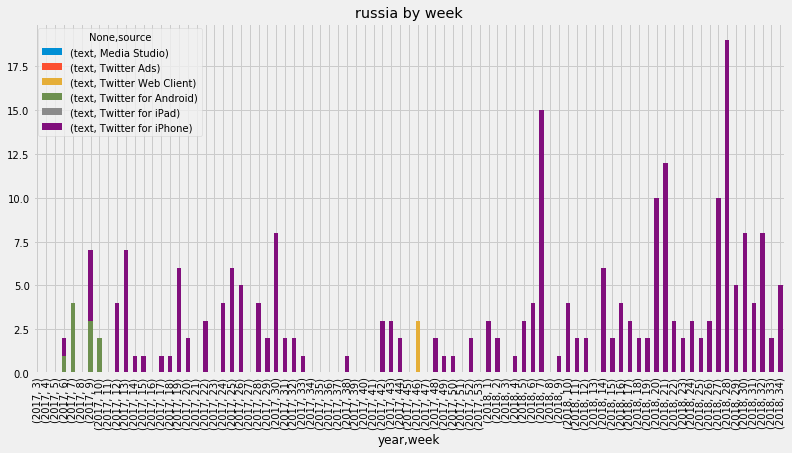

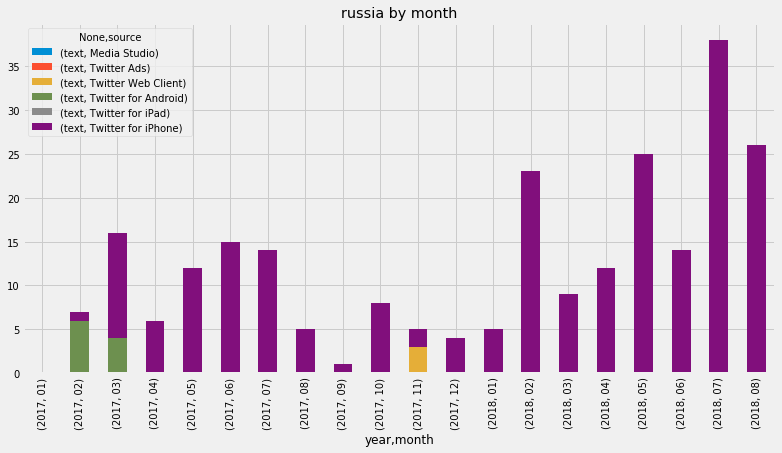

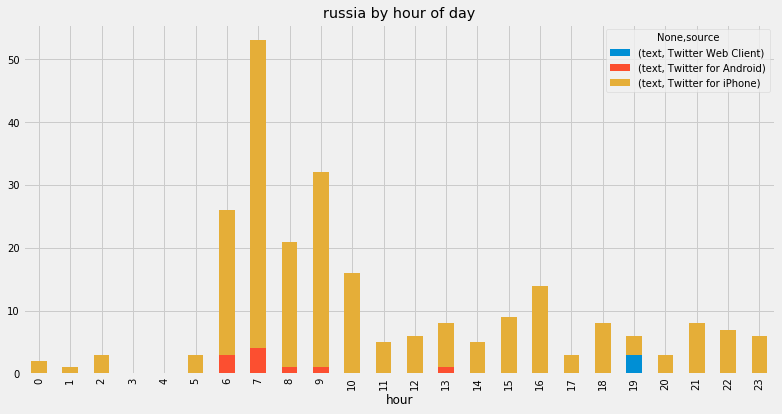

### The Tweets

[Thursday, Aug 30, 2018 9:17 AM](https://twitter.com/realDonaldTrump/status/1035154621357064192): The Rigged Russia Witch Hunt did not come into play, even a little bit, with respect to my decision on Don McGahn!

[Thursday, Aug 30, 2018 8:54 AM](https://twitter.com/realDonaldTrump/status/1035148684432953346): Wow, Nellie Ohr, Bruce Ohr’s wife, is a Russia expert who is fluent in Russian. She worked for Fusion GPS where she was paid a lot. Collusion! Bruce was a boss at the Department of Justice and is, unbelievably, still there!

[Thursday, Aug 30, 2018 7:02 AM](https://twitter.com/realDonaldTrump/status/1035120511259500544): What’s going on at @CNN is happening, to different degrees, at other networks - with @NBCNews being the worst. The good news is that Andy Lack(y) is about to be fired(?) for incompetence, and much worse. When Lester Holt got caught fudging my tape on Russia, they were hurt badly!

[Wednesday, Aug 29, 2018 8:18 AM](https://twitter.com/realDonaldTrump/status/1034777225336369152): “Hillary Clinton and the DNC paid for information from the Russian government to use against her government - there’s no doubt about that!” @TuckerCarlson

[Tuesday, Aug 28, 2018 9:16 PM](https://twitter.com/realDonaldTrump/status/1034610829860261895): Report just out: “China hacked Hillary Clinton’s private Email Server.” Are they sure it wasn’t Russia (just kidding!)? What are the odds that the FBI and DOJ are right on top of this? Actually, a very big story. Much classified information!

[Friday, Aug 24, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/1032937718219714560): ....FISA abuse, Christopher Steele &amp; his phony and corrupt Dossier, the Clinton Foundation, illegal surveillance of Trump Campaign, Russian collusion by Dems - and so much more. Open up the papers &amp; documents without redaction? Come on Jeff, you can do it, the country is waiting!

[Monday, Aug 20, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/1031503298967363586): Disgraced and discredited Bob Mueller and his whole group of Angry Democrat Thugs spent over 30 hours with the White House Councel, only with my approval, for purposes of transparency. Anybody needing that much time when they know there is no Russian Collusion is just someone....

[Saturday, Aug 18, 2018 7:46 AM](https://twitter.com/realDonaldTrump/status/1030782921500766209): All of the fools that are so focused on looking only at Russia should start also looking in another direction, China. But in the end, if we are smart, tough and well prepared, we will get along with everyone!

[Friday, Aug 17, 2018 6:29 PM](https://twitter.com/realDonaldTrump/status/1030582354308411392): “Fox News has learned that Bruce Ohr wrote Christopher Steele following the firing of James Comey saying that he was afraid the anti-Trump Russia probe will be exposed.”  Charles Payne  @FoxBusiness   How much more does Mueller have to see? They have blinders on - RIGGED!

[Thursday, Aug 16, 2018 7:45 PM](https://twitter.com/realDonaldTrump/status/1030239036093411328): “While Steele shopped the document to multiple media outlets, he also asked for help with a RUSSIAN Oligarch.”  Catherine Herridge of @FoxNews  @LouDobbs  In other words, they were colluding with Russia!

[Wednesday, Aug 15, 2018 10:31 PM](https://twitter.com/realDonaldTrump/status/1029918661165936641): Mark Levin “When they had power they didn’t stop the Russians, the Chinese, the North Koreans, they funded the Iranians &amp; are responsible for the greatest scandal in American history by interfering with our election &amp; trying to undermine the Trump Campaign and Trump Presidency.”

[Wednesday, Aug 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/1029731513573822464): The Rigged Russian Witch Hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. All credibility is gone from this terrible Hoax, and much more will be lost as it proceeds. No Collusion!

[Tuesday, Aug 14, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1029355952414371841): Lou Dobbs: “This cannot go forward...this Special Counsel with all of his conflicts, with his 17 Angry Democrats, without any evidence of collusion by the Trump Campaign and Russia. The Dems are the ones who should be investigated.” Thank you Lou, so true!

[Tuesday, Aug 14, 2018 9:01 AM](https://twitter.com/realDonaldTrump/status/1029352395464224769): Fired FBI Agent Peter Strzok is a fraud, as is the rigged investigation he started. There was no Collusion or Obstruction with Russia, and everybody, including the Democrats, know it. The only Collusion and Obstruction was by Crooked Hillary, the Democrats and the DNC!

[Tuesday, Aug 14, 2018 7:21 AM](https://twitter.com/realDonaldTrump/status/1029327223269060609): Lou Dobbs: “This cannot go forward...this Special Councel with all of his conflicts, with his 17 Angry Democrats, without any evidence of collusion by the Trump Campaign and Russia. The Dems are the ones who should be investigated.” Thank you Lou, so true!

[Friday, Aug 10, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/1027884715553050625): .@MariaBartiromo  “No evidence to launch even an investigation into potential collusion between Donald Trump and the Russians - and here we are, a year and a half later.”

[Thursday, Aug 9, 2018 9:22 AM](https://twitter.com/realDonaldTrump/status/1027545694201159680): “There has been no evidence whatsoever that Donald Trump or the campaign was involved in any kind of collusion to fix the 2016 election. In fact the evidence is the opposite, that Hillary Clinton &amp; the Democrats colluded with the Russians to fix the 2016 election.” @GrahamLedger

[Monday, Aug 6, 2018 10:25 AM](https://twitter.com/realDonaldTrump/status/1026474458326986752): ....a law firm, eventually Kremlin connected sources, to gather info on Donald Trump. Collusion is very real with Russia, but only with Hillary and the Democrats, and we should demand a full investigation.” Dan Bongino on @foxandfriends  Looking forward to the new IG Report!

[Monday, Aug 6, 2018 10:13 AM](https://twitter.com/realDonaldTrump/status/1026471244949061632): “Collusion with Russia was very real. Hillary Clinton and her team 100% colluded with the Russians, and so did Adam Schiff who is on tape trying to collude with what he thought was Russians to obtain compromising material on DJT. We also know that Hillary Clinton paid through....

[Friday, Aug 3, 2018 11:28 PM](https://twitter.com/realDonaldTrump/status/1025584134322892800): ...Dianne is the person leading our Nation on “Collusion” with Russia (only done by Dems). Will she now investigate herself? https://t.co/OG6l04bBwg

[Friday, Aug 3, 2018 11:01 PM](https://twitter.com/realDonaldTrump/status/1025577505615503360): Congratulations to Gregg Jarrett on his book, “THE RUSSIA HOAX, THE ILLICIT SCHEME TO CLEAR HILLARY CLINTON AND FRAME DONALD TRUMP,” going to #1 on @nytimes and Amazon. It is indeed a HOAX and WITCH HUNT, illegally started by people who have already been disgraced. Great book!

[Thursday, Aug 2, 2018 12:38 AM](https://twitter.com/realDonaldTrump/status/1024877011775500290): Congratulations to  @GreggJarrett on The TREMENDOUS success of his just out book, “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump.” Already number one on Amazon. Hard work from a brilliant guy. It’s the Real Story of the Rigged Witch Hunt!

[Wednesday, Aug 1, 2018 11:56 AM](https://twitter.com/realDonaldTrump/status/1024685313778741250): “We already have a smoking gun about a campaign getting dirt on their opponent, it was Hillary Clinton. How is it OK for Hillary Clinton to proactively seek dirt from the Russians but the Trump campaign met at the Russians request and that is bad?” Marc Thiessen, Washington Post

[Wednesday, Aug 1, 2018 11:35 AM](https://twitter.com/realDonaldTrump/status/1024680095343108097): Looking back on history, who was treated worse, Alfonse Capone, legendary mob boss, killer and “Public Enemy Number One,” or Paul Manafort, political operative &amp; Reagan/Dole darling, now serving solitary confinement - although convicted of nothing? Where is the Russian Collusion?

[Wednesday, Aug 1, 2018 11:23 AM](https://twitter.com/realDonaldTrump/status/1024676935065120768): “We already have a smocking gun about a campaign getting dirt on their opponent, it was Hillary Clinton. How is it OK for Hillary Clinton to proactively seek dirt from the Russians but the Trump campaign met at the Russians request and that is bad?” Marc Thiessen, Washington Post

[Wednesday, Aug 1, 2018 10:01 AM](https://twitter.com/realDonaldTrump/status/1024656465158721536): Russian Collusion with the Trump Campaign, one of the most successful in history, is a TOTAL HOAX. The Democrats paid for the phony and discredited Dossier which was, along with Comey, McCabe, Strzok and his lover, the lovely Lisa Page, used to begin the Witch Hunt. Disgraceful!

[Sunday, Jul 29, 2018 4:20 PM](https://twitter.com/realDonaldTrump/status/1023664624259014656): ....Also, why is Mueller only appointing Angry Dems, some of whom have worked for Crooked Hillary, others, including himself, have worked for Obama....And why isn’t Mueller looking at all of the criminal activity &amp; real Russian Collusion on the Democrats side-Podesta, Dossier?

[Friday, Jul 27, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1022808452677160960): ....,the only Collusion with Russia was with the Democrats, so now they are looking at my Tweets (along with 53 million other people) - the rigged Witch Hunt continues! How stupid and unfair to our Country....And so the Fake News doesn’t waste my time with dumb questions, NO,....

[Tuesday, Jul 24, 2018 9:05 PM](https://twitter.com/realDonaldTrump/status/1021924262045802496): “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump” is a Hot Seller, already Number One! More importantly, it is a great book that everyone is talking about. It covers the Rigged Witch Hunt brilliantly. Congratulations to Gregg Jarrett!

[Tuesday, Jul 24, 2018 11:50 AM](https://twitter.com/realDonaldTrump/status/1021784726217142273): I’m very concerned that Russia will be fighting very hard to have an impact on the upcoming Election. Based on the fact that no President has been tougher on Russia than me, they will be pushing very hard for the Democrats. They definitely don’t want Trump!

[Monday, Jul 23, 2018 7:09 AM](https://twitter.com/realDonaldTrump/status/1021351630648815616): .....”Carter Page wasn’t a spy, wasn’t an agent of the Russians - he would have cooperated with the FBI. It was a fraud and a hoax designed to target Trump.” Tom Fitton @JudicialWatch A disgrace to America. They should drop the discredited Mueller Witch Hunt now!

[Sunday, Jul 22, 2018 6:23 PM](https://twitter.com/realDonaldTrump/status/1021158915206152193): So President Obama knew about Russia before the Election. Why didn’t he do something about it? Why didn’t he tell our campaign? Because it is all a big hoax, that’s why, and he thought Crooked Hillary was going to win!!!

[Friday, Jul 20, 2018 10:39 AM](https://twitter.com/realDonaldTrump/status/1020317159828992000): RT @realDonaldTrump: The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forw…

[Thursday, Jul 19, 2018 9:35 AM](https://twitter.com/realDonaldTrump/status/1019938748413435910): “Trump recognized Russian Meddling MANY TIMES” https://t.co/T8MERS93wI

[Thursday, Jul 19, 2018 9:27 AM](https://twitter.com/realDonaldTrump/status/1019936658240794625): “Trump recognized Russian Meddling MANY TIMES.” https://t.co/Da8T8SUsCE

[Thursday, Jul 19, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1019936133147516929): The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........

[Thursday, Jul 19, 2018 7:13 AM](https://twitter.com/realDonaldTrump/status/1019903123312308224): “Trump recognized Russian Meddling MANY TIMES.” Thank you to @foxandfriends and @FoxNews for actually showing the clips. The Fake News wants no part of that narrative! Too bad they don’t want to focus on all of the ECONOMIC and JOBS records being set.

[Thursday, Jul 19, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1019899507910283264): The Fake News Media wants so badly to see a major confrontation with Russia, even a confrontation that could lead to war. They are pushing so recklessly hard and hate the fact that I’ll probably have a good relationship with Putin. We are doing MUCH better than any other country!

[Wednesday, Jul 18, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/1019544304853966853): Some people HATE the fact that I got along well with President Putin of Russia. They would rather go to war than see this. It’s called Trump Derangement Syndrome!

[Wednesday, Jul 18, 2018 6:16 AM](https://twitter.com/realDonaldTrump/status/1019526399542091776): ....Russia has agreed to help with North Korea, where relationships with us are very good and the process is moving along. There is no rush, the sanctions remain! Big benefits and exciting future for North Korea at end of process!

[Wednesday, Jul 18, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/1019524328927453184): While the NATO meeting in Brussels was an acknowledged triumph, with billions of dollars more being put up by member countries at a faster pace, the meeting with Russia may prove to be, in the long run, an even greater success. Many positive things will come out of that meeting..

[Tuesday, Jul 17, 2018 10:22 AM](https://twitter.com/realDonaldTrump/status/1019225830298456066): While I had a great meeting with NATO, raising vast amounts of money, I had an even better meeting with Vladimir Putin of Russia. Sadly, it is not being reported that way - the Fake News is going Crazy!

[Tuesday, Jul 17, 2018 9:53 AM](https://twitter.com/realDonaldTrump/status/1019218575691837443): I had a great meeting with NATO. They have paid $33 Billion more and will pay hundreds of Billions of Dollars more in the future, only because of me. NATO was weak, but now it is strong again (bad for Russia). The media only says I was rude to leaders, never mentions the money!

[Monday, Jul 16, 2018 4:34 PM](https://twitter.com/realDonaldTrump/status/1018956970143858688): A productive dialogue is not only good for the United States and good for Russia, but it is good for the world. #HELSINKI2018 https://t.co/Q2Y1PhM9au

[Monday, Jul 16, 2018 2:05 AM](https://twitter.com/realDonaldTrump/status/1018738368753078273): Our relationship with Russia has NEVER been worse thanks to many years of U.S. foolishness and stupidity and now, the Rigged Witch Hunt!

[Monday, Jul 16, 2018 1:37 AM](https://twitter.com/realDonaldTrump/status/1018731223890481153): President Obama thought that Crooked Hillary was going to win the election, so when he was informed by the FBI about Russian Meddling, he said it couldn’t happen, was no big deal, &amp; did NOTHING about it. When I won it became a big deal and the Rigged Witch Hunt headed by Strzok!

[Monday, Jul 16, 2018 12:28 AM](https://twitter.com/realDonaldTrump/status/1018713940522622977): RT @SecPompeo: Landed in #Finland for #helsinki2018 where @POTUS &amp; Prez Putin are set to discuss US/Russian relations. POTUS meeting is in…

[Sunday, Jul 15, 2018 1:03 PM](https://twitter.com/realDonaldTrump/status/1018541464416997376): Congratulations to France, who played extraordinary soccer, on winning the 2018 World Cup. Additionally, congratulations to President Putin and Russia for putting on a truly great World Cup Tournament -- one of the best ever!

[Sunday, Jul 15, 2018 12:18 PM](https://twitter.com/realDonaldTrump/status/1018530167902228480): Heading to Helsinki, Finland – looking forward to meeting with President Putin tomorrow. Unfortunately, no matter how well I do at the Summit, if I was given the great city of Moscow as retribution for all of the sins and evils committed by Russia...

[Sunday, Jul 15, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/1018490597865226245): RT @realDonaldTrump: The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Admini…

[Sunday, Jul 15, 2018 9:33 AM](https://twitter.com/realDonaldTrump/status/1018488667474522112): RT @realDonaldTrump: These Russian individuals did their work during the Obama years. Why didn’t Obama do something about it?  Because he t…

[Saturday, Jul 14, 2018 2:17 PM](https://twitter.com/realDonaldTrump/status/1018197842559725569): These Russian individuals did their work during the Obama years. Why didn’t Obama do something about it?  Because he thought Crooked Hillary Clinton would win, that’s why. Had nothing to do with the Trump Administration, but Fake News doesn’t want to report the truth, as usual!

[Saturday, Jul 14, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/1018074723140427776): The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administration. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?

[Saturday, Jul 14, 2018 5:53 AM](https://twitter.com/realDonaldTrump/status/1018070907741523968): The stories you heard about the 12 Russians yesterday took place during the Obama Administration, not the Trump Administrations. Why didn’t they do something about it, especially when it was reported that President Obama was informed by the FBI in September, before the Election?

[Saturday, Jul 14, 2018 5:17 AM](https://twitter.com/realDonaldTrump/status/1018061893750149120): RT @realDonaldTrump: ....On top of it all, Germany just started paying Russia, the country they want protection from, Billions of Dollars f…

[Thursday, Jul 12, 2018 2:12 AM](https://twitter.com/realDonaldTrump/status/1017290478839050240): ....On top of it all, Germany just started paying Russia, the country they want protection from, Billions of Dollars for their Energy needs coming out of a new pipeline from Russia. Not acceptable! All NATO Nations must meet their 2% commitment, and that must ultimately go to 4%!

[Thursday, Jul 12, 2018 2:03 AM](https://twitter.com/realDonaldTrump/status/1017288317342224384): Presidents have been trying unsuccessfully for years to get Germany and other rich NATO Nations to pay more toward their protection from Russia. They pay only a fraction of their cost. The U.S. pays tens of Billions of Dollars too much to subsidize Europe, and loses Big on Trade!

[Wednesday, Jul 11, 2018 7:33 PM](https://twitter.com/realDonaldTrump/status/1017190186269184001): Billions of additional dollars are being spent by NATO countries since my visit last year, at my request, but it isn’t nearly enough. U.S. spends too much. Europe’s borders are BAD! Pipeline dollars to Russia are not acceptable!

[Wednesday, Jul 11, 2018 5:11 PM](https://twitter.com/realDonaldTrump/status/1017154540284542981): RT @realDonaldTrump: What good is NATO if Germany is paying Russia billions of dollars for gas and energy? Why are there only 5 out of 29 c…

[Wednesday, Jul 11, 2018 1:07 PM](https://twitter.com/realDonaldTrump/status/1017093020783710209): What good is NATO if Germany is paying Russia billions of dollars for gas and energy? Why are there only 5 out of 29 countries that have met their commitment? The U.S. is paying for Europe’s protection, then loses billions on Trade. Must pay 2% of GDP IMMEDIATELY, not by 2025.

[Wednesday, Jul 11, 2018 12:50 PM](https://twitter.com/realDonaldTrump/status/1017088833890942981): What good is NATO if Germany is paying Russia billions of dollars for gas and energy? Why are their only 5 out of 29 countries that have met their commitment? The U.S. is paying for Europe’s protection, then loses billions on Trade. Must pay 2% of GDP IMMEDIATELY, not by 2025.

[Saturday, Jul 7, 2018 4:42 PM](https://twitter.com/realDonaldTrump/status/1015697664514674689): Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Counsel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!

[Saturday, Jul 7, 2018 4:29 PM](https://twitter.com/realDonaldTrump/status/1015694335151656961): Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Councel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!

[Friday, Jul 6, 2018 12:57 PM](https://twitter.com/realDonaldTrump/status/1015278594795417600): Just won lawsuit filed by the DNC and a bunch of Democrat crazies trying to claim the Trump Campaign (and others), colluded with Russia. They haven’t figured out that this was an excuse for them losing the election!

[Thursday, Jun 28, 2018 7:25 AM](https://twitter.com/realDonaldTrump/status/1012295859072126977): Russia continues to say they had nothing to do with Meddling in our Election! Where is the DNC Server, and why didn’t Shady James Comey and the now disgraced FBI agents take and closely examine it? Why isn’t Hillary/Russia being looked at? So many questions, so much corruption!

[Saturday, Jun 23, 2018 9:43 PM](https://twitter.com/realDonaldTrump/status/1010699954157830144): Major Wall Street Journal opinion piece today talking about the Russian Witch Hunt and the disgrace that it is. So many people hurt, so bad for our country - a total sham!
https://t.co/bcpSGtoX6a

[Saturday, Jun 23, 2018 7:36 AM](https://twitter.com/realDonaldTrump/status/1010486772541816834): The Russian Witch Hunt is Rigged!

[Saturday, Jun 23, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/1010485876806348800): .@FoxNews  Poll numbers plummet on the Democrat inspired and paid for Russian Witch Hunt. With all of the bias, lying and hate by the investigators, people want the investigators investigated. Much more will come out. A total scam and excuse for the Dems losing the Election!

[Sunday, Jun 17, 2018 10:54 AM](https://twitter.com/realDonaldTrump/status/1008362351807037441): WITCH HUNT! There was no Russian Collusion. Oh, I see, there was no Russian Collusion, so now they look for obstruction on the no Russian Collusion. The phony Russian Collusion was a made up Hoax. Too bad they didn’t look at Crooked Hillary like this. Double Standard!

[Friday, Jun 15, 2018 6:35 AM](https://twitter.com/realDonaldTrump/status/1007572229935202304): FBI Agent Peter Strzok, who headed the Clinton &amp; Russia investigations, texted to his lover Lisa Page, in the IG Report, that “we’ll stop” candidate Trump from becoming President. Doesn’t get any lower than that!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278701996802048): So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, illegally leak (Comey) classified information so that a Special Councel will be appointed, and then Collude to make this pile of garbage take on life in Fake News!

[Friday, Jun 8, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/1005047468705439744): I am heading for Canada and the G-7 for talks that will mostly center on the long time unfair trade practiced against the United States. From there I go to Singapore and talks with North Korea on Denuclearization. Won’t be talking about the Russian Witch Hunt Hoax for a while!

[Tuesday, Jun 5, 2018 7:31 AM](https://twitter.com/realDonaldTrump/status/1003962584352030720): The Russian Witch Hunt Hoax continues, all because Jeff Sessions didn’t tell me he was going to recuse himself...I would have quickly picked someone else. So much time and money wasted, so many lives ruined...and Sessions knew better than most that there was No Collusion!

[Monday, Jun 4, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/1003738642903420928): The Fake News Media is desperate to distract from the economy and record setting economic numbers and so they keep talking about the phony Russian Witch Hunt.

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1002892787803676673): ....“$17 million spent, it’s a scam Investigation. Americans are being worked. We now know there was Russian collusion, with Russians and the Democrats. The Mueller team is stacked with anti-Trumpers, who actually represented Clinton people (&amp; gave $’s to Crooked H).” Dan Bongino

[Friday, Jun 1, 2018 7:05 AM](https://twitter.com/realDonaldTrump/status/1002506360351846400): A.P. has just reported that the Russian Hoax Investigation has now cost our government over $17 million, and going up fast. No Collusion, except by the Democrats!

[Thursday, May 31, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/1002160516733853696): Not that it matters but I never fired James Comey because of Russia! The Corrupt Mainstream Media loves to keep pushing that narrative, but they know it is not true!

[Thursday, May 31, 2018 6:55 AM](https://twitter.com/realDonaldTrump/status/1002141448232493056): RUSH LIMBAUGH  “If the FBI was so concerned, and if they weren’t targeting Trump, they should have told Trump. If they were really concerned about the Russians infiltrating a campaign (hoax), then why not try to stop it? Why not tell Trump? Because they were pushing this scam.”

[Wednesday, May 30, 2018 11:06 PM](https://twitter.com/realDonaldTrump/status/1002023477531070464): The soon to be released book, “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton And Frame Donald Trump,” written by Gregg Jarrett, looks like a real deal big hit. The Phony Witch Hunt will be opened up for the world to see! Out in 5 weeks.

[Tuesday, May 29, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/1001424695126880258): Sorry, I’ve got to start focusing my energy on North Korea Nuclear, bad Trade Deals, VA Choice, the Economy, rebuilding the Military, and so much more, and not on the Rigged Russia Witch Hunt that should be investigating Clinton/Russia/FBI/Justice/Obama/Comey/Lynch etc.

[Tuesday, May 29, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/1001417880116891650): The 13 Angry Democrats (plus people who worked 8 years for Obama) working on the rigged Russia Witch Hunt, will be MEDDLING with the mid-term elections, especially now that Republicans (stay tough!) are taking the lead in Polls. There was no Collusion, except by the Democrats!

[Sunday, May 27, 2018 4:32 PM](https://twitter.com/realDonaldTrump/status/1000837182297464832): Why didn’t President Obama do something about the so-called Russian Meddling when he was told about it by the FBI before the Election? Because he thought Crooked Hillary was going to win, and he didn’t want to upset the apple cart! He was in charge, not me, and did nothing.

[Sunday, May 27, 2018 10:13 AM](https://twitter.com/realDonaldTrump/status/1000741764565753856): Why didn’t the 13 Angry Democrats investigate the campaign of Crooked Hillary Clinton, many crimes, much Collusion with Russia? Why didn’t the FBI take the Server from the DNC?  Rigged Investigation!

[Sunday, May 27, 2018 8:41 AM](https://twitter.com/realDonaldTrump/status/1000718611688943616): Who’s going to give back the young and beautiful lives (and others) that have been devastated and destroyed by the phony Russia Collusion Witch Hunt? They journeyed down to Washington, D.C., with stars in their eyes and wanting to help our nation...They went back home in tatters!

[Saturday, May 26, 2018 3:56 PM](https://twitter.com/realDonaldTrump/status/1000465814192099330): When will the 13 Angry Democrats (&amp; those who worked for President O), reveal their disqualifying Conflicts of Interest? It’s been a long time now! Will they be indelibly written into the Report along with the fact that the only Collusion is with the Dems, Justice, FBI &amp; Russia?

[Saturday, May 26, 2018 3:41 PM](https://twitter.com/realDonaldTrump/status/1000462031500099584): This whole Russia Probe is Rigged. Just an excuse as to why the Dems and Crooked Hillary lost the Election and States that haven’t been lost in decades. 13 Angry Democrats, and all Dems if you include the people who worked for Obama for 8 years. #SPYGATE &amp; CONFLICTS OF INTEREST!

[Saturday, May 26, 2018 3:28 PM](https://twitter.com/realDonaldTrump/status/1000458567147839488): With Spies, or “Informants” as the Democrats like to call them because it sounds less sinister (but it’s not), all over my campaign, even from a very early date, why didn’t the crooked highest levels of the FBI or “Justice” contact me to tell me of the  phony Russia problem?

[Friday, May 25, 2018 8:04 AM](https://twitter.com/realDonaldTrump/status/999984492197613568): The Democrats are now alluding to the the concept that having an Informant placed in an opposing party’s campaign is different than having a Spy, as illegal as that may be. But what about an “Informant” who is paid a fortune and who “sets up” way earlier than the Russian Hoax?

[Wednesday, May 23, 2018 6:54 AM](https://twitter.com/realDonaldTrump/status/999242039723163648): Look how things have turned around on the Criminal Deep State. They go after Phony Collusion with Russia, a made up Scam, and end up getting caught in a major SPY scandal the likes of which this country may never have seen before! What goes around, comes around!

[Tuesday, May 22, 2018 9:13 PM](https://twitter.com/realDonaldTrump/status/999096013674680321): ...Follow the money! The spy was there early in the campaign and yet never reported Collusion with Russia, because there was no Collusion. He was only there to spy for political reasons and to help Crooked Hillary win - just like they did to Bernie Sanders, who got duped!

[Sunday, May 20, 2018 1:13 PM](https://twitter.com/realDonaldTrump/status/998250447394820096): The Witch Hunt finds no Collusion with Russia - so now they’re looking at the rest of the World. Oh’ great!

[Sunday, May 20, 2018 9:29 AM](https://twitter.com/realDonaldTrump/status/998194013193822208): Now that the Witch Hunt has given up on Russia and is looking at the rest of the World, they should easily be able to take it into the Mid-Term Elections where they can put some hurt on the Republican Party. Don’t worry about Dems FISA Abuse, missing Emails or Fraudulent Dossier!

[Sunday, May 20, 2018 9:11 AM](https://twitter.com/realDonaldTrump/status/998189366844559360): ....At what point does this soon to be $20,000,000 Witch Hunt, composed of 13 Angry and Heavily Conflicted Democrats and two people who have worked for Obama for 8 years, STOP! They have found no Collussion with Russia, No Obstruction, but they aren’t looking at the corruption...

[Sunday, May 20, 2018 9:04 AM](https://twitter.com/realDonaldTrump/status/998187672979038208): Things are really getting ridiculous. The Failing and Crooked (but not as Crooked as Hillary Clinton) @nytimes has done a long &amp; boring story indicating that the World’s most expensive Witch Hunt has found nothing on Russia &amp; me so now they are looking at the rest of the World!

[Friday, May 18, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/997474432443707393): Reports are there was indeed at least one FBI representative implanted, for political purposes, into my campaign for president. It took place very early on, and long before the phony Russia Hoax became a “hot” Fake News story. If true - all time biggest political scandal!

[Tuesday, May 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/996391840860471296): Can you believe that with all of the made up, unsourced stories I get from the Fake News Media, together with the  $10,000,000 Russian Witch Hunt (there is no Collusion), I now have my best Poll Numbers in a year. Much of the Media may be corrupt, but the People truly get it!

[Monday, May 7, 2018 7:39 AM](https://twitter.com/realDonaldTrump/status/993455375755173892): The 13 Angry Democrats in charge of the Russian Witch Hunt are starting to find out that there is a Court System in place that actually protects people from injustice...and just wait ‘till the Courts get to see your unrevealed Conflicts of Interest!

[Monday, May 7, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/993452275648679938): The Russia Witch Hunt is rapidly losing credibility. House Intelligence Committee found No Collusion, Coordination or anything else with Russia. So now the Probe says OK, what else is there? How about Obstruction for a made up, phony crime.There is no O, it’s called Fighting Back

[Wednesday, May 2, 2018 6:40 PM](https://twitter.com/realDonaldTrump/status/991809653980966913): “This isn’t some game. You are screwing with the work of the president of the United States.”  John Dowd, March 2018.  With North Korea, China, the Middle East and so much more, there is not much time to be thinking about this, especially since there was no Russian “Collusion.”

[Wednesday, May 2, 2018 9:33 AM](https://twitter.com/realDonaldTrump/status/991672075491438594): NEW BOOK - A MUST READ! “The Russia Hoax - The Illicit Scheme to Clear Hillary Clinton and Frame Donald Trump” by the brilliant Fox News Legal Analyst Gregg Jarrett. A sad chapter for law enforcement. A rigged system!

[Tuesday, May 1, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/991267863674675200): So disgraceful that the questions concerning the Russian Witch Hunt were “leaked” to the media. No questions on Collusion. Oh, I see...you have a made up, phony crime, Collusion, that never existed, and an investigation begun with illegally leaked classified information. Nice!

[Saturday, Apr 28, 2018 3:11 PM](https://twitter.com/realDonaldTrump/status/990307626784362496): Secret Service has just informed me that Senator Jon Tester’s statements on Admiral Jackson are not true. There were no such findings. A horrible thing that we in D.C. must live with, just like phony Russian Collusion. Tester should lose race in Montana. Very dishonest and sick!

[Friday, Apr 27, 2018 10:04 PM](https://twitter.com/realDonaldTrump/status/990049088375836672): House Intelligence Committee rules that there was NO COLLUSION between the Trump Campaign and Russia. As I have been saying all along, it is all a big Hoax by the Democrats based on payments and lies. There should never have been a Special Counsel appointed. Witch Hunt!

[Friday, Apr 27, 2018 9:19 PM](https://twitter.com/realDonaldTrump/status/990037854884696064): House Intelligence Committee rules that there was NO COLLUSION between the Trump Campaign and Russia. As I have been saying all along, it is all a big Hoax by the Democrats based on payments and lies. There should never have been a Special Councel appointed. Witch Hunt!

[Friday, Apr 27, 2018 10:14 AM](https://twitter.com/realDonaldTrump/status/989870523042680832): Just Out: House Intelligence Committee Report released. “No evidence” that the Trump Campaign “colluded, coordinated or conspired with Russia.” Clinton Campaign paid for Opposition Research obtained from Russia- Wow! A total Witch Hunt! MUST END NOW!

[Wednesday, Apr 18, 2018 8:05 AM](https://twitter.com/realDonaldTrump/status/986576502358671361): Slippery James Comey, the worst FBI Director in history, was not fired because of the phony Russia investigation where, by the way, there was NO COLLUSION (except by the Dems)!

[Monday, Apr 16, 2018 8:31 AM](https://twitter.com/realDonaldTrump/status/985858100149309441): Russia and China are playing the Currency Devaluation game as the U.S. keeps raising interest rates. Not acceptable!

[Wednesday, Apr 11, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/984053549742067712): Much of the bad blood with Russia is caused by the Fake &amp; Corrupt Russia Investigation, headed up by the all Democrat loyalists, or people that worked for Obama. Mueller is most conflicted of all (except Rosenstein who signed FISA &amp; Comey letter). No Collusion, so they go crazy!

[Wednesday, Apr 11, 2018 7:37 AM](https://twitter.com/realDonaldTrump/status/984032798821568513): Our relationship with Russia is worse now than it has ever been, and that includes the Cold War. There is no reason for this. Russia needs us to help with their economy, something that would be very easy to do, and we need all nations to work together. Stop the arms race?

[Wednesday, Apr 11, 2018 6:57 AM](https://twitter.com/realDonaldTrump/status/984022625440747520): Russia vows to shoot down any and all missiles fired at Syria. Get ready Russia,  because they will be coming, nice and new and “smart!” You shouldn’t be partners with a Gas Killing Animal who kills his people and enjoys it!

[Wednesday, Apr 11, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/984020136255541248): ....doing things that nobody thought possible, despite the never ending and corrupt Russia Investigation, which takes tremendous time and focus. No Collusion or Obstruction (other than I fight back), so now they do the Unthinkable, and RAID a lawyers office for information! BAD!

[Wednesday, Apr 11, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/984015782521835521): The Failing New York Times wrote another phony story. It was political pundit Doug Schoen, not a Ukrainian businessman, who asked me to do a short speech by phone (Skype), hosted by Doug, in Ukraine. I was very positive about Ukraine-another negative to the Fake Russia  C story!

[Sunday, Apr 8, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/982966315467116544): Many dead, including women and children, in mindless CHEMICAL attack in Syria. Area of atrocity is in lockdown and encircled by Syrian Army, making it completely inaccessible to outside world. President Putin, Russia and Iran are responsible for backing Animal Assad. Big price...

[Sunday, Mar 25, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/977875057572745216): ....lawyer or law firm will take months to get up to speed (if for no other reason than they can bill more), which is unfair to our great country - and I am very happy with my existing team. Besides, there was NO COLLUSION with Russia, except by Crooked Hillary and the Dems!

[Sunday, Mar 25, 2018 7:40 AM](https://twitter.com/realDonaldTrump/status/977872899792089088): Many lawyers and top law firms want to represent me in the Russia case...don’t believe the Fake News narrative that it is hard to find a lawyer who wants to take this on. Fame &amp; fortune will NEVER be turned down by a lawyer, though some are conflicted. Problem is that a new......

[Friday, Mar 23, 2018 6:07 AM](https://twitter.com/realDonaldTrump/status/977124622285066240): House Intelligence Committee votes to release final report. FINDINGS: (1) No evidence provided of Collusion between Trump Campaign &amp; Russia. (2)  The Obama Administrations Post election response was insufficient. (3) Clapper provided inconsistent testimony on media contacts.

[Wednesday, Mar 21, 2018 2:56 PM](https://twitter.com/realDonaldTrump/status/976532956557737984): I called President Putin of Russia to congratulate him on his election victory (in past, Obama called him also). The Fake News Media is crazed because they wanted me to excoriate him. They are wrong! Getting along with Russia (and others) is a good thing, not a bad thing.......

[Saturday, Mar 17, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/975057131136274432): As the House Intelligence Committee has concluded, there was no collusion between Russia and the Trump Campaign. As many are now finding out, however, there was tremendous leaking, lying and corruption at the highest levels of the FBI, Justice &amp; State. #DrainTheSwamp

[Monday, Mar 12, 2018 8:49 PM](https://twitter.com/realDonaldTrump/status/973360355790479361): THE HOUSE INTELLIGENCE COMMITTEE HAS, AFTER A 14 MONTH LONG IN-DEPTH INVESTIGATION, FOUND NO EVIDENCE OF COLLUSION OR COORDINATION BETWEEN THE TRUMP CAMPAIGN AND RUSSIA TO INFLUENCE THE 2016 PRESIDENTIAL ELECTION.

[Sunday, Mar 11, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/972832210222043137): ...have shown conclusively that there was no Collusion with Russia..just excuse for losing. The only Collusion was that done by the DNC, the Democrats and Crooked Hillary. The writer of the story, Maggie Haberman, a Hillary flunky, knows nothing about me and is not given access.

[Sunday, Mar 11, 2018 9:41 AM](https://twitter.com/realDonaldTrump/status/972829763067883523): The Failing New York Times purposely wrote a false story stating that I am unhappy with my legal team on the Russia case and am going to add another lawyer to help out. Wrong. I am VERY happy with my lawyers, John Dowd, Ty Cobb and Jay Sekulow. They are doing a great job and.....

[Monday, Mar 5, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/970650759091163137): Why did the Obama Administration start an investigation into the Trump Campaign (with zero proof of wrongdoing) long before the Election in November? Wanted to discredit so Crooked H would win. Unprecedented. Bigger than Watergate! Plus, Obama did NOTHING about Russian meddling.

[Saturday, Feb 24, 2018 6:44 PM](https://twitter.com/realDonaldTrump/status/967545724362739712): “Russians had no compromising information on Donald Trump” @FoxNews  Of course not, because there is none, and never was. This whole Witch Hunt is an illegal disgrace...and Obama did nothing about Russia!

[Wednesday, Feb 21, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/966321700588711936): Question: If all of the Russian meddling took place during the Obama Administration, right up to January 20th, why aren’t they the subject of the investigation? Why didn’t Obama do something about the meddling? Why aren’t Dem crimes under investigation? Ask Jeff Sessions!

[Wednesday, Feb 21, 2018 9:03 AM](https://twitter.com/realDonaldTrump/status/966312434100326400): Question: If all of the Russian meddling took place during the Obama Administration, right up to January 20th, why aren’t they the subject of the investigation? Why didn’t Obama do something about the meddling? Why aren’t Dem crimes under investigation? Ask Jeff Session!

[Tuesday, Feb 20, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/966117265426001920): Bad ratings @CNN &amp; @MSNBC got scammed when they covered the anti-Trump Russia rally wall-to-wall. They probably knew it was Fake News but, because it was a rally against me, they pushed it hard anyway. Two really dishonest newscasters, but the public is wise!

[Tuesday, Feb 20, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/965943827931549696): I have been much tougher on Russia than Obama, just look at the facts. Total Fake News!

[Tuesday, Feb 20, 2018 7:46 AM](https://twitter.com/realDonaldTrump/status/965930611272712192): ....The President Obama quote just before election. That’s because he thought Crooked Hillary was going to win and he didn’t want to “rock the boat.” When I easily won the Electoral College, the whole game changed and the Russian excuse became the narrative of the Dems.

[Tuesday, Feb 20, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/965925223949357056): Thank you to @foxandfriends for the great timeline on all of the failures the Obama Administration had against Russia, including Crimea, Syria and so much more. We are now starting to win again!

[Monday, Feb 19, 2018 2:55 PM](https://twitter.com/realDonaldTrump/status/965676314576543744): Obama was President up to, and beyond, the 2016 Election. So why didn’t he do something about Russian meddling?

[Sunday, Feb 18, 2018 12:10 PM](https://twitter.com/realDonaldTrump/status/965272331978407937): Thank you to KenStarr, former Independent Counsel, Whitewater, for your insight and powerful words on FISA abuse, Russian meddling etc. Really great interview with @MariaBartiromo

[Sunday, Feb 18, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/965212168449941505): If it was the GOAL of Russia to create discord, disruption and chaos within the U.S. then, with all of the Committee Hearings, Investigations and Party hatred, they have succeeded beyond their wildest dreams. They are laughing their asses off in Moscow. Get smart America!

[Sunday, Feb 18, 2018 7:43 AM](https://twitter.com/realDonaldTrump/status/965205208191168512): Now that Adam Schiff is starting to blame President Obama for Russian meddling in the election, he is probably doing so as yet another excuse that the Democrats, lead by their fearless leader, Crooked Hillary Clinton, lost the 2016 election. But wasn’t I a great candidate?

[Sunday, Feb 18, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/965202556204003328): I never said Russia did not meddle in the election, I said “it may be Russia, or China or another country or group, or it may be a 400 pound genius sitting in bed and playing with his computer.” The Russian “hoax” was that the Trump campaign colluded with Russia - it never did!

[Sunday, Feb 18, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/965199840471810049): Finally, Liddle’ Adam Schiff, the leakin’ monster of no control, is now blaming the Obama Administration for Russian meddling in the 2016 Election. He is finally right about something. Obama was President, knew of the threat, and did nothing. Thank you Adam!

[Saturday, Feb 17, 2018 11:22 PM](https://twitter.com/realDonaldTrump/status/965079126829871104): General McMaster forgot to say that the results of the 2016 election were not impacted or changed by the Russians and that the only Collusion was between Russia and Crooked H, the DNC and the Dems. Remember the Dirty Dossier, Uranium, Speeches, Emails and the Podesta Company!

[Saturday, Feb 17, 2018 11:08 PM](https://twitter.com/realDonaldTrump/status/965075589274177536): Very sad that the FBI missed all of the many signals sent out by the Florida school shooter. This is not acceptable. They are spending too much time trying to prove Russian collusion with the Trump campaign - there is no collusion. Get back to the basics and make us all proud!

[Saturday, Feb 17, 2018 3:16 PM](https://twitter.com/realDonaldTrump/status/964956781670694912): “I have seen all of the Russian ads and I can say very definitively that swaying the election was *NOT* the main goal.”
Rob Goldman
Vice President of Facebook Ads https://t.co/A5ft7cGJkE

[Saturday, Feb 17, 2018 2:46 PM](https://twitter.com/realDonaldTrump/status/964949269374529538): Funny how the Fake News Media doesn’t want to say that the Russian group was formed in 2014, long before my run for President. Maybe they knew I was going to run even though I didn’t know!

[Saturday, Feb 17, 2018 2:26 PM](https://twitter.com/realDonaldTrump/status/964944088696049666): “Charges Deal Don A Big Win,” written by Michael Goodwin of the @nypost, succinctly states that “the Russians had no impact on the election results.” There was no Collusion with the Trump Campaign. “She lost the old-fashioned way, by being a terrible candidate. Case closed.”

[Friday, Feb 16, 2018 3:18 PM](https://twitter.com/realDonaldTrump/status/964594780088033282): Russia started their anti-US campaign in 2014, long before I announced that I would run for President. The results of the election were not impacted. The Trump campaign did nothing wrong - no collusion!

[Saturday, Feb 10, 2018 10:20 AM](https://twitter.com/realDonaldTrump/status/962345433170415616): According to the @nytimes, a Russian sold phony secrets on “Trump” to the U.S. Asking price was $10 million, brought down to $1 million to be paid over time. I hope people are now seeing &amp; understanding what is going on here. It is all now starting to come out - DRAIN THE SWAMP!

[Thursday, Feb 8, 2018 10:22 PM](https://twitter.com/realDonaldTrump/status/961802557646569475): Wow! -Senator Mark Warner got caught having extensive contact with a lobbyist for a Russian oligarch. Warner did not want a “paper trail” on a “private” meeting (in London) he requested with Steele of fraudulent Dossier fame. All tied into Crooked Hillary.

[Saturday, Feb 3, 2018 7:26 PM](https://twitter.com/realDonaldTrump/status/959946200488271872): Great jobs numbers and finally, after many years, rising wages- and nobody even talks about them. Only Russia, Russia, Russia, despite the fact that, after a year of looking, there is No Collusion!

[Saturday, Feb 3, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/959798743842349056): This memo totally vindicates “Trump” in probe. But the Russian Witch Hunt goes on and on. Their was no Collusion and there was no Obstruction (the word now used because, after one year of looking endlessly and finding NOTHING, collusion is dead). This is an American disgrace!

[Tuesday, Jan 16, 2018 9:19 AM](https://twitter.com/realDonaldTrump/status/953270558573154305): Do you notice the Fake News Mainstream Media never likes covering the great and record setting economic news, but rather talks about anything negative or that can be turned into the negative. The Russian Collusion Hoax is dead, except as it pertains to the Dems. Public gets it!

[Saturday, Jan 13, 2018 10:49 PM](https://twitter.com/realDonaldTrump/status/952387277610774528): RT @paulsperry_: Fusion GPS, firm behind disputed Russia dossier, retracts its claim of FBI mole in Trump camp
https://t.co/s6CFPXSVqb

[Thursday, Jan 11, 2018 6:33 AM](https://twitter.com/realDonaldTrump/status/951416674808467461): Disproven and paid for by Democrats “Dossier used to spy on Trump Campaign. Did FBI use Intel tool to influence the Election?” @foxandfriends  Did Dems or Clinton also pay Russians? Where are hidden and smashed DNC servers? Where are Crooked Hillary Emails?  What a mess!

[Wednesday, Jan 10, 2018 10:14 AM](https://twitter.com/realDonaldTrump/status/951109942685126656): The single greatest Witch Hunt in American history continues. There was no collusion, everybody including the Dems knows there was no collusion, &amp; yet on and on it goes. Russia &amp; the world is laughing at the stupidity they are witnessing. Republicans should finally take control!

[Wednesday, Jan 10, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/951106475254059008): The fact that Sneaky Dianne Feinstein, who has on numerous occasions stated that collusion between Trump/Russia has not been found, would release testimony in such an underhanded and possibly illegal way, totally without authorization, is a disgrace. Must have tough Primary!

[Friday, Dec 29, 2017 7:46 AM](https://twitter.com/realDonaldTrump/status/946724075157651457): While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage &amp; Russia hoax!

[Tuesday, Dec 26, 2017 8:24 AM](https://twitter.com/realDonaldTrump/status/945646491955290113): WOW, @foxandfrlends  “Dossier is bogus. Clinton Campaign, DNC funded Dossier. FBI CANNOT (after all of this time) VERIFY CLAIMS IN DOSSIER OF RUSSIA/TRUMP COLLUSION. FBI TAINTED.” And they used this Crooked Hillary pile of garbage as the basis for going after the Trump Campaign!

[Tuesday, Dec 12, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/940554567414091776): Despite thousands of hours wasted and many millions of dollars spent, the Democrats have been unable to show any collusion with Russia - so now they are moving on to the false accusations and fabricated stories of women who I don’t know and/or have never met. FAKE NEWS!

[Saturday, Dec 2, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/937145025359761408): Congratulations to @ABC News for suspending Brian Ross for his horrendously inaccurate and dishonest report on the Russia, Russia, Russia Witch Hunt. More Networks and “papers” should do the same with their Fake News!

[Thursday, Nov 30, 2017 7:25 AM](https://twitter.com/realDonaldTrump/status/936209447747190784): The Chinese Envoy, who just returned from North Korea, seems to have had no impact on Little Rocket Man. Hard to believe his people, and the military, put up with living in such horrible conditions. Russia and China condemned the launch.

[Sunday, Nov 26, 2017 4:29 PM](https://twitter.com/realDonaldTrump/status/934896989539586054): Since the first day I took office, all you hear is the phony Democrat excuse for losing the election, Russia, Russia,Russia.  Despite this I have the economy booming and have possibly done more than any 10 month President. MAKE AMERICA GREAT AGAIN!

[Saturday, Nov 11, 2017 7:43 PM](https://twitter.com/realDonaldTrump/status/929509950811881472): Does the Fake News Media remember when Crooked Hillary Clinton, as Secretary of State, was begging Russia to be our friend with the misspelled reset button? Obama tried also, but he had zero chemistry with Putin.

[Saturday, Nov 11, 2017 7:18 PM](https://twitter.com/realDonaldTrump/status/929503641014112256): When will all the haters and fools out there realize that having a good relationship with Russia is a good thing, not a bad thing. There always playing politics - bad for our country. I want to solve North Korea, Syria, Ukraine, terrorism, and Russia can greatly help!

[Saturday, Nov 11, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/929503025512693760): Met with President Putin of Russia who was at #APEC meetings. Good discussions on Syria. Hope for his help to solve, along with China the dangerous North Korea crisis. Progress being made.

[Sunday, Oct 29, 2017 10:48 AM](https://twitter.com/realDonaldTrump/status/924649059520073730): All of this "Russia" talk right when the Republicans are making their big push for historic Tax Cuts &amp; Reform. Is this coincidental? NOT!

[Sunday, Oct 29, 2017 10:02 AM](https://twitter.com/realDonaldTrump/status/924637600094326784): ...the Uranium to Russia deal, the  33,000 plus deleted Emails, the Comey fix and so much more. Instead they look at phony Trump/Russia,....

[Friday, Oct 27, 2017 10:13 PM](https://twitter.com/realDonaldTrump/status/924096747122634752): “WHAT HAPPENED”

“How Team Hillary played the press for fools on Russia”
➡️https://t.co/GqpIidk017

NOW WE KNOW! https://t.co/SgWL1HZmkI

[Friday, Oct 27, 2017 4:33 PM](https://twitter.com/realDonaldTrump/status/924011278804357120): .@FoxNews Chris Wallace: “More evidence of Dem collusion with Russia than GOP” https://t.co/nACQerJSiu

[Friday, Oct 27, 2017 9:33 AM](https://twitter.com/realDonaldTrump/status/923905540291522560): It is now commonly agreed, after many months of COSTLY looking, that there was NO collusion between Russia and Trump. Was collusion with HC!

[Thursday, Oct 19, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/920988223362469891): .@foxandfriends "Russia sent millions to Clinton Foundation"

[Thursday, Oct 19, 2017 7:56 AM](https://twitter.com/realDonaldTrump/status/920981920787386368): Workers of firm involved with the discredited and Fake Dossier take the 5th. Who paid for it, Russia, the FBI or the Dems (or all)?

[Thursday, Oct 19, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/920972261032648705): Uranium deal to Russia, with Clinton help and Obama Administration knowledge, is the biggest story that Fake Media doesn't want to follow!

[Friday, Sep 22, 2017 6:44 AM](https://twitter.com/realDonaldTrump/status/911179462745710593): The Russia hoax continues, now it's ads on Facebook. What about the totally biased and dishonest Media coverage in favor of Crooked Hillary?

[Tuesday, Aug 15, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/897411177583702016): @foxandfriends According to report just out, President Obama knew about Russian interference 3 years ago but he didn't want to anger Russia!

[Monday, Aug 7, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/894525428236464128): Interesting to watch Senator Richard Blumenthal of Connecticut talking about hoax Russian collusion when he was a  phony Vietnam con artist!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Saturday, Aug 5, 2017 6:44 PM](https://twitter.com/realDonaldTrump/status/893965986566733824): The United Nations Security Council just voted 15-0 to sanction North Korea. China and Russia voted with us. Very big financial impact!

[Thursday, Aug 3, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/893083735633129472): Our relationship with Russia is at an all-time &amp; very dangerous  low. You can thank Congress, the same people that can't even give us HCare!

[Saturday, Jul 29, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/891253798500487168): In other words, Russia was against Trump in the 2016 Election - and why not, I want strong military &amp; low oil prices. Witch Hunt! https://t.co/mMSxj4Su5z

[Thursday, Jul 27, 2017 9:35 AM](https://twitter.com/realDonaldTrump/status/890566339462672385): "One of the things that has been lost in the politics of this situation is that the Russians collected and spread negative information.....

[Tuesday, Jul 25, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/889800510106107904): Jared Kushner did very well yesterday in proving he did not collude with the Russians. Witch Hunt. Next up, 11 year old Barron Trump!

[Monday, Jul 24, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/889473486506385409): Sleazy Adam Schiff, the totally biased Congressman looking into "Russia," spends all of his time on television pushing the Dem loss excuse!

[Monday, Jul 24, 2017 8:49 AM](https://twitter.com/realDonaldTrump/status/889467610332528641): So why aren't the Committees and investigators, and of course our beleaguered A.G., looking into Crooked Hillarys crimes &amp; Russia relations?

[Monday, Jul 24, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/889438168721874944): After 1 year of investigation with Zero evidence being found, Chuck Schumer just stated that "Democrats should blame ourselves,not Russia."

[Sunday, Jul 23, 2017 4:11 PM](https://twitter.com/realDonaldTrump/status/889216341013655552): RT @realDonaldTrump: As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Dem…

[Sunday, Jul 23, 2017 4:09 PM](https://twitter.com/realDonaldTrump/status/889215815022727168): As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Democrats and Russians!

[Saturday, Jul 22, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/888727293346156546): ...What about all of the Clinton ties to Russia, including Podesta Company, Uranium deal, Russian Reset, big dollar speeches etc.

[Sunday, Jul 16, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/886541955311816705): Thank you to former campaign adviser Michael Caputo for saying so powerfully that there was no Russian collusion in our winning campaign.

[Saturday, Jul 15, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/886261674029854721): Stock Market hit another all-time high yesterday - despite the Russian hoax story! Also, jobs numbers are starting to look very good!

[Wednesday, Jul 12, 2017 5:55 AM](https://twitter.com/realDonaldTrump/status/885075206905188352): RT @FoxNews: .@jessebwatters on @DonaldJTrumpJr meeting with Russian attorney: "I believe Don Jr. is the victim here." #TheFive https://t.c…

[Sunday, Jul 9, 2017 7:37 AM](https://twitter.com/realDonaldTrump/status/884013689736769536): ...We negotiated a ceasefire in parts of Syria which will save lives. Now it is time to move forward in working constructively with Russia!

[Sunday, Jul 9, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/884012097805406208): I strongly pressed President Putin twice about Russian meddling in our election. He vehemently denied it. I've already given my opinion.....

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/879655772111679488): RT @foxandfriends: Hannity: Russia allegations 'boomeranging back' on Democrats https://t.co/lvdrpxpcp9

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Monday, Jun 26, 2017 8:59 AM](https://twitter.com/realDonaldTrump/status/879323238425395200): The real story is that President Obama did NOTHING after being informed in August about Russian meddling. With 4 months looking at Russia...

[Monday, Jun 26, 2017 8:37 AM](https://twitter.com/realDonaldTrump/status/879317636164841474): The reason that President Obama did NOTHING about Russia after being notified by the CIA of meddling is that he expected Clinton would win..

[Saturday, Jun 24, 2017 4:44 PM](https://twitter.com/realDonaldTrump/status/878715504063643648): Obama Administration official said they "choked" when it came to acting on Russian meddling of election. They didn't want to hurt Hillary?

[Saturday, Jun 24, 2017 4:28 PM](https://twitter.com/realDonaldTrump/status/878711517537083392): Since the Obama Administration was told way before the 2016 Election that the Russians were meddling, why no action? Focus on them, not T!

[Friday, Jun 23, 2017 8:43 PM](https://twitter.com/realDonaldTrump/status/878413313188802560): Just out: The Obama Administration knew far in advance of November 8th about election meddling by Russia. Did nothing about it. WHY?

[Thursday, Jun 22, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/877879361130688512): By the way, if Russia was working so hard on the 2016 Election, it all took place during the Obama Admin. Why didn't they stop them?

[Thursday, Jun 22, 2017 9:18 AM](https://twitter.com/realDonaldTrump/status/877878375045447680): Former Homeland Security Advisor Jeh Johnson is latest top intelligence official to state there was no grand scheme between Trump &amp; Russia.

[Sunday, Jun 18, 2017 5:07 PM](https://twitter.com/realDonaldTrump/status/876546864669237253): RT @DiamondandSilk: The Media Says:  The President Should Stop Tweeting about Russia. 
 Well, Why Don't the Media Take Their Own Advice &amp; S…

[Friday, Jun 16, 2017 7:53 AM](https://twitter.com/realDonaldTrump/status/875682853585129472): After 7 months of investigations &amp; committee hearings about my "collusion with the Russians,"  nobody has been able to show any proof. Sad!

[Thursday, Jun 15, 2017 3:43 PM](https://twitter.com/realDonaldTrump/status/875438639823675392): Why is that Hillary Clintons family and Dems dealings with Russia are not looked at, but my non-dealings are?

[Thursday, Jun 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/875305788708974592): They made up a phony collusion with the Russians story, found zero proof, so now they go for obstruction of justice on the phony story. Nice

[Sunday, Jun 11, 2017 10:07 PM](https://twitter.com/realDonaldTrump/status/874085723762286592): RT @foxandfriends: "Yesterday's hearings provided zero evidence of collusion between our campaign and the Russians because there wasn't any…

[Wednesday, May 31, 2017 6:37 AM](https://twitter.com/realDonaldTrump/status/869865463584620544): So now it is reported that the Democrats, who have excoriated Carter Page about Russia, don't want him to testify. He blows away their....

[Tuesday, May 30, 2017 10:01 AM](https://twitter.com/realDonaldTrump/status/869554306806157312): RT @foxandfriends: Jared Kushner didn't suggest Russian communications channel in meeting, source says https://t.co/nF6bM1FEt1

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Tuesday, May 16, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/864438529472049152): ...to terrorism and airline flight safety. Humanitarian reasons, plus I want Russia to greatly step up their fight against ISIS &amp; terrorism.

[Tuesday, May 16, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/864436162567471104): As President I wanted to share with Russia (at an openly scheduled W.H. meeting) which I have the absolute right to do, facts pertaining....

[Friday, May 12, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/862998775731818496): Again, the story that there was collusion between the Russians &amp; Trump campaign was fabricated by Dems as an excuse for losing the election.

[Thursday, May 11, 2017 5:54 PM](https://twitter.com/realDonaldTrump/status/862788002594127873): Yesterday, on the same day- I had meetings with Russian Foreign Minister Sergei Lavrov and the FM of Ukraine, Pavlo… https://t.co/hm4U54DCQO

[Thursday, May 11, 2017 4:34 PM](https://twitter.com/realDonaldTrump/status/862767872879325185): Russia must be laughing up their sleeves watching as the U.S. tears itself apart over a Democrat EXCUSE for losing the election.

[Monday, May 8, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/861713823505494016): The Russia-Trump collusion story is a total hoax, when will this taxpayer funded charade end?

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

[Sunday, May 7, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/861177649179373569): When will the Fake Media ask about the Dems dealings with Russia &amp; why the DNC wouldn't allow the FBI to check their server or investigate?

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Friday, Apr 28, 2017 10:34 PM](https://twitter.com/realDonaldTrump/status/858147464846729217): RT @foxnation: . @TuckerCarlson : #Dems Don't Really Believe #Trump Is a Pawn of #Russia - That's Just Their Political Tool  https://t.co/K…

[Thursday, Apr 13, 2017 9:16 AM](https://twitter.com/realDonaldTrump/status/852510810287075329): Things will work out fine between the U.S.A. and Russia. At the right time everyone will come to their senses &amp; there will be lasting peace!

[Monday, Apr 3, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/848856822312292354): Was the brother of John Podesta paid big money to get the sanctions on Russia lifted? Did Hillary know?

[Saturday, Apr 1, 2017 1:02 PM](https://twitter.com/realDonaldTrump/status/848219027659010051): ..not associated with Russia. Trump team spied on before he was nominated." If this is true, does not get much bigger. Would be sad for U.S.

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Saturday, Apr 1, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/848153860602507264): When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Tuesday, Mar 28, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/846682464215076866): Watch @foxandfriends now on Podesta and Russia!

[Monday, Mar 27, 2017 9:35 PM](https://twitter.com/realDonaldTrump/status/846536212362018816): ...money to Bill, the Hillary Russian "reset," praise of Russia by Hillary, or Podesta Russian Company. Trump Russia story is a hoax. #MAGA!

[Monday, Mar 27, 2017 9:26 PM](https://twitter.com/realDonaldTrump/status/846533818811080704): Why isn't the House Intelligence Committee looking into the Bill &amp; Hillary deal that allowed big Uranium to go to Russia, Russian speech....

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/843813078076719107): What about all of the contact with the Clinton campaign and the Russians? Also, is it true that the DNC would not let the FBI in to look?

[Monday, Mar 20, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/843776582825267201): The Democrats made up and pushed the Russian story as an excuse for running a terrible campaign. Big advantage in Electoral College &amp; lost!

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Tuesday, Mar 7, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839101660886614016): For eight years Russia "ran over" President Obama, got stronger and stronger, picked-off Crimea and added missiles. Weak! @foxandfriends

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Saturday, Mar 4, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/837991759045079040): Just out: The same Russian Ambassador that met Jeff Sessions visited the Obama White House 22 times, and 4 times last year alone.

[Saturday, Mar 4, 2017 6:26 AM](https://twitter.com/realDonaldTrump/status/837987684660412416): The first meeting Jeff Sessions had with the Russian Amb was set up by the Obama Administration under education program for 100 Ambs......

[Friday, Mar 3, 2017 4:02 PM](https://twitter.com/realDonaldTrump/status/837770149767827456): I hereby demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 3:49 PM](https://twitter.com/realDonaldTrump/status/837767004236955649): I hearby demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 3:47 PM](https://twitter.com/realDonaldTrump/status/837766402937393155): I hear by demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 12:54 PM](https://twitter.com/realDonaldTrump/status/837722869106880517): We should start an immediate investigation into @SenSchumer and his ties to Russia and Putin. A total hypocrite! https://t.co/Ik3yqjHzsA

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Wednesday, Feb 15, 2017 7:42 AM](https://twitter.com/realDonaldTrump/status/831846101179314177): Crimea was TAKEN by Russia during the Obama Administration. Was Obama too soft on Russia?

[Wednesday, Feb 15, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/831840306161123328): Information is being illegally given to the failing @nytimes &amp; @washingtonpost by the intelligence community (NSA and FBI?).Just like Russia

[Wednesday, Feb 15, 2017 7:08 AM](https://twitter.com/realDonaldTrump/status/831837514226921472): This Russian connection non-sense is merely an attempt to cover-up the many mistakes made in Hillary Clinton's losing campaign.

[Tuesday, Feb 7, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/828939235499638784): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1 in terror, no problem!

[Tuesday, Feb 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/828937357147635713): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1in terror, no problem!

---

## Search: _witch hunt_

Number of Tweets: 125

Percent of all Tweets: 2.74%

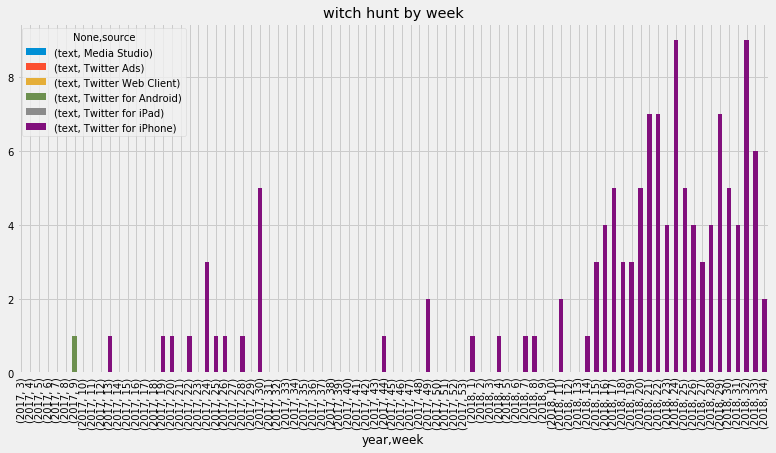

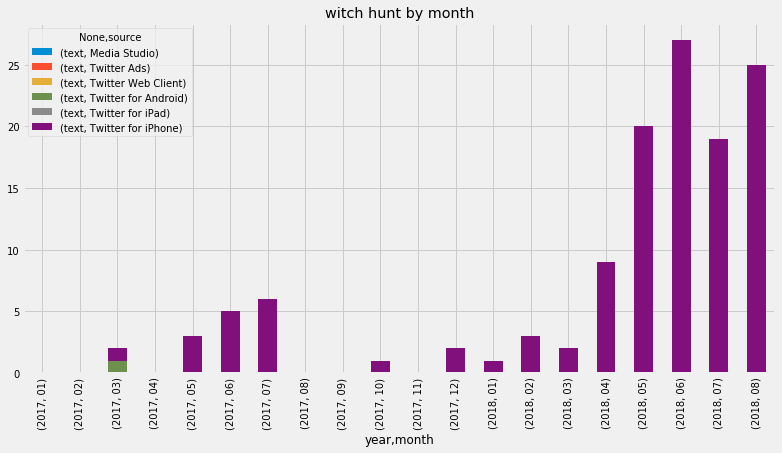

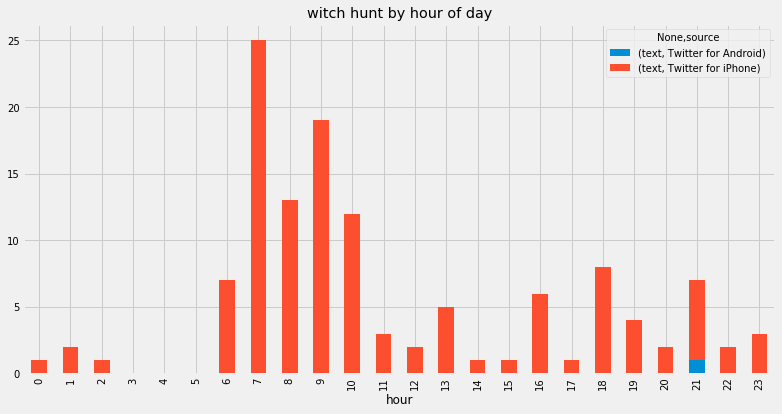

### The Tweets

[Thursday, Aug 30, 2018 9:17 AM](https://twitter.com/realDonaldTrump/status/1035154621357064192): The Rigged Russia Witch Hunt did not come into play, even a little bit, with respect to my decision on Don McGahn!

[Wednesday, Aug 29, 2018 11:12 AM](https://twitter.com/realDonaldTrump/status/1034821067423014913): How the hell is Bruce Ohr still employed at the Justice Department? Disgraceful!  Witch Hunt!

[Thursday, Aug 23, 2018 1:10 AM](https://twitter.com/realDonaldTrump/status/1032495180530835456): NO COLLUSION - RIGGED WITCH HUNT!

[Wednesday, Aug 22, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/1032259660378779648): A large number of counts, ten, could not even be decided in the Paul Manafort case. Witch Hunt!

[Monday, Aug 20, 2018 10:13 AM](https://twitter.com/realDonaldTrump/status/1031544711717302272): I hope John Brennan, the worst CIA Director in our country’s history, brings a lawsuit. It will then be very easy to get all of his records, texts, emails and documents to show not only the poor job he did, but how he was involved with the Mueller Rigged Witch Hunt. He won’t sue!

[Monday, Aug 20, 2018 7:48 AM](https://twitter.com/realDonaldTrump/status/1031508193107763200): Where’s the Collusion? They made up a phony crime called Collusion, and when there was no Collusion they say there was Obstruction (of a phony crime that never existed). If you FIGHT BACK or say anything bad about the Rigged Witch Hunt, they scream Obstruction!

[Sunday, Aug 19, 2018 8:24 AM](https://twitter.com/realDonaldTrump/status/1031154974942810114): Study the late Joseph McCarthy, because we are now in period with Mueller and his gang that make Joseph McCarthy look like a baby! Rigged Witch Hunt!

[Sunday, Aug 19, 2018 7:15 AM](https://twitter.com/realDonaldTrump/status/1031137499995930624): ....and have demanded transparency so that this Rigged and Disgusting Witch Hunt can come to a close. So many lives have been ruined over nothing - McCarthyism at its WORST! Yet Mueller &amp; his gang of Dems refuse to look at the real crimes on the other side - Media is even worse!

[Saturday, Aug 18, 2018 6:12 PM](https://twitter.com/realDonaldTrump/status/1030940529037651968): I allowed White House Counsel Don McGahn, and all other requested members of the White House Staff, to fully cooperate with the Special Counsel. In addition we readily gave over one million pages of documents. Most transparent in history. No Collusion, No Obstruction. Witch Hunt!

[Saturday, Aug 18, 2018 6:04 PM](https://twitter.com/realDonaldTrump/status/1030938589847269378): I allowed White House Counsel Don McGahn, and all other requested members of the White House Staff, to fully cooperate with the Special Councel. In addition we readily gave over one million pages of documents. Most transparent in history. No Collusion, No Obstruction. Witch Hunt!

[Thursday, Aug 16, 2018 7:53 PM](https://twitter.com/realDonaldTrump/status/1030241273784020993): “Very concerned about Comey’s firing, afraid they will be exposed,” said Bruce Ohr. DOJ’s Emails &amp; Notes show Bruce Ohr’s connection to (phony &amp; discredited) Trump Dossier. A creep thinking he would get caught in a dishonest act. Rigged Witch Hunt!

[Thursday, Aug 16, 2018 7:37 PM](https://twitter.com/realDonaldTrump/status/1030237078586617856): “The FBI received documents from Bruce Ohr (of the Justice Department &amp; whose wife Nelly worked for Fusion GPS).” Disgraced and fired FBI Agent Peter Strzok. This is too crazy to be believed! The Rigged Witch Hunt has zero credibility.

[Wednesday, Aug 15, 2018 9:14 PM](https://twitter.com/realDonaldTrump/status/1029899109749202944): “Hillary Clinton clearly got a pass by the FBI. We have the unfortunate situation where they then decided they were going to frame Donald Trump” concerning the Rigged Witch Hunt. JOE DIGENOVA, former U.S. Attorney.

[Wednesday, Aug 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/1029731513573822464): The Rigged Russian Witch Hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. All credibility is gone from this terrible Hoax, and much more will be lost as it proceeds. No Collusion!

[Tuesday, Aug 14, 2018 9:10 AM](https://twitter.com/realDonaldTrump/status/1029354577559281665): Strzok started the illegal Rigged Witch Hunt - why isn’t this so-called “probe” ended immediately? Why aren’t these angry and conflicted Democrats instead looking at Crooked Hillary?

[Tuesday, Aug 14, 2018 8:06 AM](https://twitter.com/realDonaldTrump/status/1029338578239795200): “They were all in on it, clear Hillary Clinton and FRAME Donald Trump for things he didn’t do.” Gregg Jarrett on @foxandfriends  If we had a real Attorney General, this Witch Hunt would never have been started! Looking at the wrong people.

[Monday, Aug 13, 2018 12:04 PM](https://twitter.com/realDonaldTrump/status/1029036065158557701): Agent Peter Strzok was just fired from the FBI - finally. The list of bad players in the FBI &amp; DOJ gets longer &amp; longer. Based on the fact that Strzok was in charge of the Witch Hunt, will it be dropped? It is a total Hoax. No Collusion, No Obstruction - I just fight back!

[Saturday, Aug 11, 2018 2:54 PM](https://twitter.com/realDonaldTrump/status/1028354010129027077): ....Do you believe Nelly worked for Fusion and her husband STILL WORKS FOR THE DEPARTMENT OF “JUSTICE.” I have never seen anything so Rigged in my life. Our A.G. is scared stiff and Missing in Action. It is all starting to be revealed - not pretty. IG Report soon?  Witch Hunt!

[Thursday, Aug 9, 2018 12:02 PM](https://twitter.com/realDonaldTrump/status/1027585937163931648): This is an illegally brought Rigged Witch Hunt run by people who are totally corrupt and/or conflicted. It was started and paid for by Crooked Hillary and the Democrats. Phony Dossier, FISA disgrace and so many lying and dishonest people already fired. 17 Angry Dems? Stay tuned!

[Sunday, Aug 5, 2018 8:49 AM](https://twitter.com/realDonaldTrump/status/1026087766071947265): Too bad a large portion of the Media refuses to report the lies and corruption having to do with the Rigged Witch Hunt - but that is why we call them FAKE NEWS!

[Sunday, Aug 5, 2018 8:45 AM](https://twitter.com/realDonaldTrump/status/1026086905539174400): ...Why aren’t Mueller and the 17 Angry Democrats looking at the meetings concerning the Fake Dossier and all of the lying that went on in the FBI and DOJ? This is the most one sided Witch Hunt in the history of our country. Fortunately, the facts are all coming out, and fast!

[Friday, Aug 3, 2018 11:01 PM](https://twitter.com/realDonaldTrump/status/1025577505615503360): Congratulations to Gregg Jarrett on his book, “THE RUSSIA HOAX, THE ILLICIT SCHEME TO CLEAR HILLARY CLINTON AND FRAME DONALD TRUMP,” going to #1 on @nytimes and Amazon. It is indeed a HOAX and WITCH HUNT, illegally started by people who have already been disgraced. Great book!

[Thursday, Aug 2, 2018 12:38 AM](https://twitter.com/realDonaldTrump/status/1024877011775500290): Congratulations to  @GreggJarrett on The TREMENDOUS success of his just out book, “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump.” Already number one on Amazon. Hard work from a brilliant guy. It’s the Real Story of the Rigged Witch Hunt!

[Wednesday, Aug 1, 2018 10:01 AM](https://twitter.com/realDonaldTrump/status/1024656465158721536): Russian Collusion with the Trump Campaign, one of the most successful in history, is a TOTAL HOAX. The Democrats paid for the phony and discredited Dossier which was, along with Comey, McCabe, Strzok and his lover, the lovely Lisa Page, used to begin the Witch Hunt. Disgraceful!

[Wednesday, Aug 1, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1024646945640525826): ..This is a terrible situation and Attorney General Jeff Sessions should stop this Rigged Witch Hunt right now, before it continues to stain our country any further. Bob Mueller is totally conflicted, and his 17 Angry Democrats that are doing his dirty work are a disgrace to USA!

[Sunday, Jul 29, 2018 3:35 PM](https://twitter.com/realDonaldTrump/status/1023653191974625280): There is No Collusion! The Robert Mueller Rigged Witch Hunt, headed now by 17 (increased from 13, including an Obama White House lawyer) Angry Democrats, was started by a fraudulent Dossier, paid for by Crooked Hillary and the DNC. Therefore, the Witch Hunt is an illegal Scam!

[Friday, Jul 27, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1022808452677160960): ....,the only Collusion with Russia was with the Democrats, so now they are looking at my Tweets (along with 53 million other people) - the rigged Witch Hunt continues! How stupid and unfair to our Country....And so the Fake News doesn’t waste my time with dumb questions, NO,....

[Thursday, Jul 26, 2018 6:48 PM](https://twitter.com/realDonaldTrump/status/1022614701665148934): .@AlanDersh, a brilliant lawyer, who although a Liberal Democrat who probably didn’t vote for me, has discussed the Witch Hunt with great clarity and in a very positive way. He has written a new and very important book...

[Tuesday, Jul 24, 2018 9:05 PM](https://twitter.com/realDonaldTrump/status/1021924262045802496): “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton &amp; Frame Donald Trump” is a Hot Seller, already Number One! More importantly, it is a great book that everyone is talking about. It covers the Rigged Witch Hunt brilliantly. Congratulations to Gregg Jarrett!

[Monday, Jul 23, 2018 7:09 AM](https://twitter.com/realDonaldTrump/status/1021351630648815616): .....”Carter Page wasn’t a spy, wasn’t an agent of the Russians - he would have cooperated with the FBI. It was a fraud and a hoax designed to target Trump.” Tom Fitton @JudicialWatch A disgrace to America. They should drop the discredited Mueller Witch Hunt now!

[Monday, Jul 23, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/1021341698734030848): So we now find out that it was indeed the unverified and Fake Dirty Dossier, that was paid for by Crooked Hillary Clinton and the DNC, that was knowingly &amp; falsely submitted to FISA and which was responsible for starting the totally conflicted and discredited Mueller Witch Hunt!

[Sunday, Jul 22, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/1021007656511852544): Andrew McCarthy - “I said this could never happen. This is so bad that they should be looking at the judges who signed off on this stuff, not just the people who gave it. It is so bad it screams out at you.”  On the whole FISA scam which led to the rigged Mueller Witch Hunt!

[Sunday, Jul 22, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/1020978929736265729): Congratulations to @JudicialWatch and @TomFitton on being successful in getting the Carter Page FISA documents. As usual they are ridiculously heavily redacted but confirm with little doubt that the Department of “Justice” and FBI misled the courts. Witch Hunt Rigged, a Scam!

[Saturday, Jul 21, 2018 6:50 PM](https://twitter.com/realDonaldTrump/status/1020803264617615360): No Collusion, No Obstruction - but that doesn’t matter because the 13 Angry Democrats, who are only after Republicans and totally protecting Democrats, want this Witch Hunt to drag out to the November Election. Republicans better get smart fast and expose what they are doing!

[Saturday, Jul 21, 2018 6:40 PM](https://twitter.com/realDonaldTrump/status/1020800615226793986): The Rigged Witch Hunt, headed by the 13 Angry Democrats (and now 4 more have been added, one who worked directly for Obama W.H.), seems intent on damaging the Republican Party’s chances in the November Election. This Democrat excuse for losing the ‘16 Election never ends!

[Monday, Jul 16, 2018 2:05 AM](https://twitter.com/realDonaldTrump/status/1018738368753078273): Our relationship with Russia has NEVER been worse thanks to many years of U.S. foolishness and stupidity and now, the Rigged Witch Hunt!

[Monday, Jul 16, 2018 1:37 AM](https://twitter.com/realDonaldTrump/status/1018731223890481153): President Obama thought that Crooked Hillary was going to win the election, so when he was informed by the FBI about Russian Meddling, he said it couldn’t happen, was no big deal, &amp; did NOTHING about it. When I won it became a big deal and the Rigged Witch Hunt headed by Strzok!

[Wednesday, Jul 11, 2018 6:47 PM](https://twitter.com/realDonaldTrump/status/1017178539706212353): How can the Rigged Witch Hunt proceed when it was started, influenced and worked on, for an extended period of time, by former FBI Agent/Lover Peter Strzok? Read his hate filled and totally biased Emails and the answer is clear!

[Wednesday, Jul 11, 2018 5:53 PM](https://twitter.com/realDonaldTrump/status/1017164990099415041): Ex-FBI LAYER Lisa Page today defied a House of Representatives issued Subpoena to testify before Congress! Wow, but is anybody really surprised!  Together with her lover, FBI Agent Peter Strzok, she worked on the Rigged Witch Hunt, perhaps the most tainted and corrupt case EVER!

[Tuesday, Jul 10, 2018 10:40 AM](https://twitter.com/realDonaldTrump/status/1016693575344504832): I am on Air Force One flying to NATO and hear reports that the FBI lovers, Peter Strzok and Lisa Page are getting cold feet on testifying about  the Rigged Witch Hunt headed by 13 Angry Democrats and people that worked for Obama for 8 years. Total disgrace!

[Saturday, Jul 7, 2018 6:24 PM](https://twitter.com/realDonaldTrump/status/1015723140364865536): The Rigged Witch Hunt, originally headed by FBI lover boy Peter S (for one year) &amp; now, 13 Angry Democrats, should look into the missing DNC Server, Crooked Hillary’s illegally deleted Emails, the Pakistani Fraudster, Uranium One, Podesta &amp; so much more. It’s a Democrat Con Job!

[Saturday, Jul 7, 2018 4:42 PM](https://twitter.com/realDonaldTrump/status/1015697664514674689): Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Counsel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!

[Saturday, Jul 7, 2018 4:29 PM](https://twitter.com/realDonaldTrump/status/1015694335151656961): Public opinion has turned strongly against the Rigged Witch Hunt and the “Special” Councel because the public understands that there was no  Collusion with Russia (so ridiculous), that the two FBI lovers were a fraud against our Nation &amp; that the only Collusion was with the Dems!

[Tuesday, Jul 3, 2018 10:18 AM](https://twitter.com/realDonaldTrump/status/1014151457954811904): Wow! The NSA has deleted 685 million phone calls and text messages. Privacy violations? They blame technical irregularities. Such a disgrace. The Witch Hunt continues!

[Thursday, Jun 28, 2018 8:30 AM](https://twitter.com/realDonaldTrump/status/1012312287280074754): Peter Strzok worked as the leader of the Rigged Witch Hunt for a long period of time - he got it started and was only fired because the gig was up. But remember, he took his orders from Comey and McCabe and they took their orders from you know who. Mueller/Comey best friends!

[Thursday, Jun 28, 2018 7:02 AM](https://twitter.com/realDonaldTrump/status/1012290012279435265): Lover FBI Agent Peter Strzok was given poor marks on yesterday’s closed door testimony and, according to most reports, refused to answer many questions. There was no Collusion and the Witch Hunt, headed by 13 Angry Democrats and others who are totally conflicted, is Rigged!

[Monday, Jun 25, 2018 7:22 PM](https://twitter.com/realDonaldTrump/status/1011389124475961345): Why is Senator Mark Warner (D-VA), perhaps in a near drunken state, claiming he has information that only he and Bob Mueller, the leader of the 13 Angry Democrats on a Witch Hunt, knows? Isn’t this highly illegal. Is it being investigated?

[Monday, Jun 25, 2018 8:02 AM](https://twitter.com/realDonaldTrump/status/1011218033216512005): I have tried to stay uninvolved with the Department of Justice and FBI (although I do not legally have to), because of the now totally discredited and very expensive Witch Hunt currently going on. But you do have to ask why the DOJ &amp; FBI aren’t giving over requested documents?

[Saturday, Jun 23, 2018 9:43 PM](https://twitter.com/realDonaldTrump/status/1010699954157830144): Major Wall Street Journal opinion piece today talking about the Russian Witch Hunt and the disgrace that it is. So many people hurt, so bad for our country - a total sham!
https://t.co/bcpSGtoX6a

[Saturday, Jun 23, 2018 7:36 AM](https://twitter.com/realDonaldTrump/status/1010486772541816834): The Russian Witch Hunt is Rigged!

[Saturday, Jun 23, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/1010485876806348800): .@FoxNews  Poll numbers plummet on the Democrat inspired and paid for Russian Witch Hunt. With all of the bias, lying and hate by the investigators, people want the investigators investigated. Much more will come out. A total scam and excuse for the Dems losing the Election!

[Wednesday, Jun 20, 2018 4:34 PM](https://twitter.com/realDonaldTrump/status/1009534957440516096): Look what Fake ABC News put out. I guess they had it prepared from the 13 Angry Democrats leading the Witch Hunt! #StopTheBias https://t.co/c0XOk1btEQ

[Wednesday, Jun 20, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/1009435777992884227): “FBI texts have revealed anti-Trump Bias.” @FoxNews  Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!

[Tuesday, Jun 19, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/1009071326219395073): I can’t think of something more concerning than a law enforcement officer suggesting that their going to use their powers to affect an election!” Inspector General Horowitz on what was going on with numerous people regarding my election. A Rigged Witch Hunt!p

[Monday, Jun 18, 2018 11:27 AM](https://twitter.com/realDonaldTrump/status/1008732992481710081): Comey gave Strozk his marching orders. Mueller is Comey’s best friend. Witch Hunt!

[Sunday, Jun 17, 2018 8:42 PM](https://twitter.com/realDonaldTrump/status/1008510118395293699): Why was the FBI’s sick loser, Peter Strzok, working on the totally discredited Mueller team of 13 Angry &amp; Conflicted Democrats, when Strzok was giving Crooked Hillary a free pass yet telling his lover, lawyer Lisa Page, that “we’ll stop” Trump from becoming President? Witch Hunt!

[Sunday, Jun 17, 2018 10:54 AM](https://twitter.com/realDonaldTrump/status/1008362351807037441): WITCH HUNT! There was no Russian Collusion. Oh, I see, there was no Russian Collusion, so now they look for obstruction on the no Russian Collusion. The phony Russian Collusion was a made up Hoax. Too bad they didn’t look at Crooked Hillary like this. Double Standard!

[Sunday, Jun 17, 2018 8:31 AM](https://twitter.com/realDonaldTrump/status/1008326335083761664): Daniel Henninger of The Wall Street Journal: “This IG Report makes it clear, as did Rod Rosenstein’s memo, that Trump was absolutely justified, unquestionably justified, in firing Jim Comey. So I think the Mueller Investigation is on pretty weak grounds right now.”  Witch Hunt!

[Saturday, Jun 16, 2018 10:01 AM](https://twitter.com/realDonaldTrump/status/1007986538985197568): The IG Report totally destroys James Comey and all of his minions including the great lovers, Peter Strzok and Lisa Page, who started the disgraceful Witch Hunt against so many innocent people. It will go down as a dark and dangerous period in American History!

[Saturday, Jun 16, 2018 9:56 AM](https://twitter.com/realDonaldTrump/status/1007985231985627143): The IG Report totally distroys James Comey and all of his minions including the great lovers, Peter Strzok and Lisa Page, who started the disgraceful Witch Hunt against so many innocent people. It will go down as a dark and dangerous period in American History!

[Friday, Jun 15, 2018 1:49 PM](https://twitter.com/realDonaldTrump/status/1007681553676283904): I’ve had to beat 17 very talented people including the Bush Dynasty, then I had to beat the Clinton Dynasty, and now I have to beat a phony Witch Hunt and all of the dishonest people covered in the IG Report...and never forget the Fake News Media. It never ends!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278671097417729): Now that I am back from Singapore, where we had a great result with respect to North Korea, the thought process must sadly go back to the Witch Hunt, always remembering that there was No Collusion and No Obstruction of the fabricated No Crime.

[Friday, Jun 8, 2018 7:22 AM](https://twitter.com/realDonaldTrump/status/1005047468705439744): I am heading for Canada and the G-7 for talks that will mostly center on the long time unfair trade practiced against the United States. From there I go to Singapore and talks with North Korea on Denuclearization. Won’t be talking about the Russian Witch Hunt Hoax for a while!

[Thursday, Jun 7, 2018 9:07 AM](https://twitter.com/realDonaldTrump/status/1004711557291560960): When and where will all of the many conflicts of interest be listed by the 13 Angry Democrats (plus) working on the Witch Hunt Hoax. There has never been a group of people on a case so biased or conflicted. It is all a Democrat Excuse for LOSING the Election. Where is the server?

[Thursday, Jun 7, 2018 7:57 AM](https://twitter.com/realDonaldTrump/status/1004693718945984512): Isn’t it Ironic? Getting ready to go to the G-7 in Canada to fight for our country on Trade (we have the worst trade deals ever made), then off to Singapore to meet with North Korea &amp; the Nuclear Problem...But back home we still have the 13 Angry Democrats pushing the Witch Hunt!

[Tuesday, Jun 5, 2018 9:33 PM](https://twitter.com/realDonaldTrump/status/1004174436759691266): ....The greatest Witch Hunt in political history!

[Tuesday, Jun 5, 2018 7:31 AM](https://twitter.com/realDonaldTrump/status/1003962584352030720): The Russian Witch Hunt Hoax continues, all because Jeff Sessions didn’t tell me he was going to recuse himself...I would have quickly picked someone else. So much time and money wasted, so many lives ruined...and Sessions knew better than most that there was No Collusion!

[Monday, Jun 4, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/1003738642903420928): The Fake News Media is desperate to distract from the economy and record setting economic numbers and so they keep talking about the phony Russian Witch Hunt.

[Monday, Jun 4, 2018 8:35 AM](https://twitter.com/realDonaldTrump/status/1003616210922147841): As has been stated by numerous legal scholars, I have the absolute right to PARDON myself, but why would I do that when I have done nothing wrong? In the meantime, the never ending Witch Hunt, led by 13 very Angry and Conflicted Democrats (&amp; others) continues into the mid-terms!

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Wednesday, May 30, 2018 11:06 PM](https://twitter.com/realDonaldTrump/status/1002023477531070464): The soon to be released book, “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton And Frame Donald Trump,” written by Gregg Jarrett, looks like a real deal big hit. The Phony Witch Hunt will be opened up for the world to see! Out in 5 weeks.

[Tuesday, May 29, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/1001424695126880258): Sorry, I’ve got to start focusing my energy on North Korea Nuclear, bad Trade Deals, VA Choice, the Economy, rebuilding the Military, and so much more, and not on the Rigged Russia Witch Hunt that should be investigating Clinton/Russia/FBI/Justice/Obama/Comey/Lynch etc.

[Tuesday, May 29, 2018 7:09 AM](https://twitter.com/realDonaldTrump/status/1001420270094168064): Why aren’t the 13 Angry and heavily conflicted Democrats investigating the totally Crooked Campaign of totally Crooked Hillary Clinton. It’s a Rigged Witch Hunt, that’s why! Ask them if they enjoyed her after election celebration!

[Tuesday, May 29, 2018 7:00 AM](https://twitter.com/realDonaldTrump/status/1001417880116891650): The 13 Angry Democrats (plus people who worked 8 years for Obama) working on the rigged Russia Witch Hunt, will be MEDDLING with the mid-term elections, especially now that Republicans (stay tough!) are taking the lead in Polls. There was no Collusion, except by the Democrats!

[Sunday, May 27, 2018 8:41 AM](https://twitter.com/realDonaldTrump/status/1000718611688943616): Who’s going to give back the young and beautiful lives (and others) that have been devastated and destroyed by the phony Russia Collusion Witch Hunt? They journeyed down to Washington, D.C., with stars in their eyes and wanting to help our nation...They went back home in tatters!

[Wednesday, May 23, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/999282325316866048): WITCH HUNT!

[Sunday, May 20, 2018 1:13 PM](https://twitter.com/realDonaldTrump/status/998250447394820096): The Witch Hunt finds no Collusion with Russia - so now they’re looking at the rest of the World. Oh’ great!

[Sunday, May 20, 2018 9:29 AM](https://twitter.com/realDonaldTrump/status/998194013193822208): Now that the Witch Hunt has given up on Russia and is looking at the rest of the World, they should easily be able to take it into the Mid-Term Elections where they can put some hurt on the Republican Party. Don’t worry about Dems FISA Abuse, missing Emails or Fraudulent Dossier!

[Sunday, May 20, 2018 9:11 AM](https://twitter.com/realDonaldTrump/status/998189366844559360): ....At what point does this soon to be $20,000,000 Witch Hunt, composed of 13 Angry and Heavily Conflicted Democrats and two people who have worked for Obama for 8 years, STOP! They have found no Collussion with Russia, No Obstruction, but they aren’t looking at the corruption...

[Sunday, May 20, 2018 9:04 AM](https://twitter.com/realDonaldTrump/status/998187672979038208): Things are really getting ridiculous. The Failing and Crooked (but not as Crooked as Hillary Clinton) @nytimes has done a long &amp; boring story indicating that the World’s most expensive Witch Hunt has found nothing on Russia &amp; me so now they are looking at the rest of the World!

[Thursday, May 17, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/997112687799697408): Despite the disgusting, illegal and unwarranted Witch Hunt, we have had the most successful first 17 month Administration in U.S. history - by far! Sorry to the Fake News Media and “Haters,” but that’s the way it is!

[Thursday, May 17, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/997076300476055552): Congratulations America, we are now into the second year of the greatest Witch Hunt in American History...and there is still No Collusion and No Obstruction. The only Collusion was that done by Democrats who were unable to win an Election despite the spending of far more money!

[Tuesday, May 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/996391840860471296): Can you believe that with all of the made up, unsourced stories I get from the Fake News Media, together with the  $10,000,000 Russian Witch Hunt (there is no Collusion), I now have my best Poll Numbers in a year. Much of the Media may be corrupt, but the People truly get it!

[Monday, May 7, 2018 9:35 AM](https://twitter.com/realDonaldTrump/status/993484478633922560): Is this Phony Witch Hunt going to go on even longer so it wrongfully impacts the Mid-Term Elections, which is what the Democrats always intended? Republicans better get tough and smart before it is too late!

[Monday, May 7, 2018 7:39 AM](https://twitter.com/realDonaldTrump/status/993455375755173892): The 13 Angry Democrats in charge of the Russian Witch Hunt are starting to find out that there is a Court System in place that actually protects people from injustice...and just wait ‘till the Courts get to see your unrevealed Conflicts of Interest!

[Monday, May 7, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/993452275648679938): The Russia Witch Hunt is rapidly losing credibility. House Intelligence Committee found No Collusion, Coordination or anything else with Russia. So now the Probe says OK, what else is there? How about Obstruction for a made up, phony crime.There is no O, it’s called Fighting Back

[Friday, May 4, 2018 9:27 AM](https://twitter.com/realDonaldTrump/status/992395376039727104): JUST OUT: 3.9% Unemployment. 4% is Broken! In the meantime, WITCH HUNT!

[Wednesday, May 2, 2018 7:45 AM](https://twitter.com/realDonaldTrump/status/991644756995444736): There was no Collusion (it is a Hoax) and there is no Obstruction of Justice (that is a setup &amp; trap). What there is is Negotiations going on with North Korea over Nuclear War, Negotiations going on with China over Trade Deficits, Negotiations on NAFTA, and much more. Witch Hunt!

[Tuesday, May 1, 2018 7:34 AM](https://twitter.com/realDonaldTrump/status/991279620044591105): It would seem very hard to obstruct justice for a crime that never happened! Witch Hunt!

[Tuesday, May 1, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/991267863674675200): So disgraceful that the questions concerning the Russian Witch Hunt were “leaked” to the media. No questions on Collusion. Oh, I see...you have a made up, phony crime, Collusion, that never existed, and an investigation begun with illegally leaked classified information. Nice!

[Monday, Apr 30, 2018 7:02 PM](https://twitter.com/realDonaldTrump/status/991090373417152515): The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina, both necessary to get things done. We are accomplishing the unthinkable and setting positive records while doing so! Fake News is going “bonkers!”

[Friday, Apr 27, 2018 10:04 PM](https://twitter.com/realDonaldTrump/status/990049088375836672): House Intelligence Committee rules that there was NO COLLUSION between the Trump Campaign and Russia. As I have been saying all along, it is all a big Hoax by the Democrats based on payments and lies. There should never have been a Special Counsel appointed. Witch Hunt!

[Friday, Apr 27, 2018 9:19 PM](https://twitter.com/realDonaldTrump/status/990037854884696064): House Intelligence Committee rules that there was NO COLLUSION between the Trump Campaign and Russia. As I have been saying all along, it is all a big Hoax by the Democrats based on payments and lies. There should never have been a Special Councel appointed. Witch Hunt!

[Friday, Apr 27, 2018 10:14 AM](https://twitter.com/realDonaldTrump/status/989870523042680832): Just Out: House Intelligence Committee Report released. “No evidence” that the Trump Campaign “colluded, coordinated or conspired with Russia.” Clinton Campaign paid for Opposition Research obtained from Russia- Wow! A total Witch Hunt! MUST END NOW!

[Sunday, Apr 22, 2018 1:23 PM](https://twitter.com/realDonaldTrump/status/988106076028653568): A complete Witch Hunt!

[Saturday, Apr 21, 2018 9:10 AM](https://twitter.com/realDonaldTrump/status/987679852345135105): ....it means lying or making up stories. Sorry, I don’t see Michael doing that despite the horrible Witch Hunt and the dishonest media!

[Saturday, Apr 21, 2018 8:17 AM](https://twitter.com/realDonaldTrump/status/987666603516063744): ....it means lying or making up stories. Sorry, I don’t see Michael doing that despite the horrible Witch Hunt and the dishonest media!

[Thursday, Apr 19, 2018 11:37 PM](https://twitter.com/realDonaldTrump/status/987173366401585155): James Comey Memos just out and show clearly that there was NO COLLUSION and NO OBSTRUCTION. Also, he leaked classified information. WOW! Will the Witch Hunt continue?

[Tuesday, Apr 10, 2018 7:08 AM](https://twitter.com/realDonaldTrump/status/983662953894436864): A TOTAL WITCH HUNT!!!

[Monday, Mar 19, 2018 9:07 AM](https://twitter.com/realDonaldTrump/status/975720503997620224): A total WITCH HUNT with massive conflicts of interest!

[Saturday, Mar 17, 2018 8:12 PM](https://twitter.com/realDonaldTrump/status/975163071361683456): The Mueller probe should never have been started in that there was no collusion and there was no crime. It was based on fraudulent activities and a Fake Dossier paid for by Crooked Hillary and the DNC, and improperly used in FISA COURT for surveillance of my campaign. WITCH HUNT!

[Tuesday, Feb 27, 2018 7:49 AM](https://twitter.com/realDonaldTrump/status/968468176639004672): WITCH HUNT!

[Saturday, Feb 24, 2018 6:44 PM](https://twitter.com/realDonaldTrump/status/967545724362739712): “Russians had no compromising information on Donald Trump” @FoxNews  Of course not, because there is none, and never was. This whole Witch Hunt is an illegal disgrace...and Obama did nothing about Russia!

[Saturday, Feb 3, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/959798743842349056): This memo totally vindicates “Trump” in probe. But the Russian Witch Hunt goes on and on. Their was no Collusion and there was no Obstruction (the word now used because, after one year of looking endlessly and finding NOTHING, collusion is dead). This is an American disgrace!

[Wednesday, Jan 10, 2018 10:14 AM](https://twitter.com/realDonaldTrump/status/951109942685126656): The single greatest Witch Hunt in American history continues. There was no collusion, everybody including the Dems knows there was no collusion, &amp; yet on and on it goes. Russia &amp; the world is laughing at the stupidity they are witnessing. Republicans should finally take control!

[Monday, Dec 4, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/937661677700550656): A must watch: Legal Scholar Alan Dershowitz was just on @foxandfriends talking of what is going on with respect to the greatest Witch Hunt in U.S. political history. Enjoy!

[Saturday, Dec 2, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/937145025359761408): Congratulations to @ABC News for suspending Brian Ross for his horrendously inaccurate and dishonest report on the Russia, Russia, Russia Witch Hunt. More Networks and “papers” should do the same with their Fake News!

[Sunday, Oct 29, 2017 10:09 AM](https://twitter.com/realDonaldTrump/status/924639422066384896): ..."collusion," which doesn't exist. The Dems are using this terrible (and bad for our country) Witch Hunt for evil politics, but the R's...

[Saturday, Jul 29, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/891253798500487168): In other words, Russia was against Trump in the 2016 Election - and why not, I want strong military &amp; low oil prices. Witch Hunt! https://t.co/mMSxj4Su5z

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Tuesday, Jul 25, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/889800510106107904): Jared Kushner did very well yesterday in proving he did not collude with the Russians. Witch Hunt. Next up, 11 year old Barron Trump!

[Sunday, Jul 23, 2017 4:11 PM](https://twitter.com/realDonaldTrump/status/889216341013655552): RT @realDonaldTrump: As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Dem…

[Sunday, Jul 23, 2017 4:09 PM](https://twitter.com/realDonaldTrump/status/889215815022727168): As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Democrats and Russians!

[Wednesday, Jul 12, 2017 6:19 AM](https://twitter.com/realDonaldTrump/status/885081181980590084): My son Donald did a good job last night. He was open, transparent and innocent. This is the greatest Witch Hunt in political history. Sad!

[Monday, Jun 26, 2017 10:24 PM](https://twitter.com/realDonaldTrump/status/879525817361068032): From @FoxNews "Bombshell: In 2016, Obama dismissed idea that anyone could rig an American election."  Check out his statement - Witch Hunt!

[Sunday, Jun 18, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/876388733607694336): The MAKE AMERICA GREAT AGAIN agenda is doing very well despite the distraction of the Witch Hunt. Many new jobs, high business enthusiasm,..

[Friday, Jun 16, 2017 9:07 AM](https://twitter.com/realDonaldTrump/status/875701471999864833): I am being investigated for firing the FBI Director by the man who told me to fire the FBI Director! Witch Hunt

[Friday, Jun 16, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/875698062030778368): Despite the phony Witch Hunt going on in America, the economic &amp; jobs numbers are great. Regulations way down, jobs and enthusiasm way up!

[Thursday, Jun 15, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/875321478849363968): You are witnessing the single greatest WITCH HUNT in American political history - led by some very bad and conflicted people!  #MAGA

[Wednesday, May 31, 2017 6:45 AM](https://twitter.com/realDonaldTrump/status/869867413776601088): ...case against him &amp; now wants to clear his name by showing "the false or misleading testimony by James Comey, John Brennan..." Witch Hunt!

[Thursday, May 18, 2017 7:52 AM](https://twitter.com/realDonaldTrump/status/865173176854204416): This is the single greatest witch hunt of a politician in American history!

[Friday, May 12, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/863014620516233216): When James Clapper himself, and virtually everyone else with knowledge of the witch hunt, says there is no collusion, when does it end?

[Friday, Mar 31, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/847766558520856578): Mike Flynn should ask for immunity in that this is a witch hunt (excuse for big election loss), by media &amp; Dems, of historic proportion!

[Thursday, Mar 2, 2017 9:38 PM](https://twitter.com/realDonaldTrump/status/837492425283219458): ...is all of the illegal leaks of classified and other information. It is a total "witch hunt!"

---

## Search: _mueller_

Number of Tweets: 45

Percent of all Tweets: 0.99%

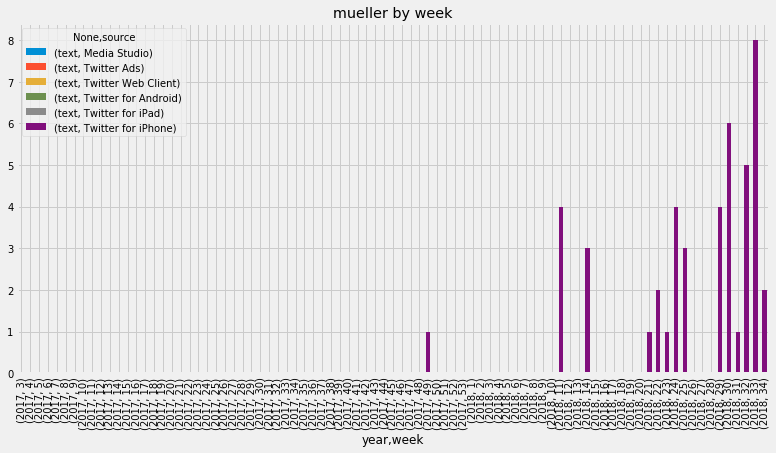

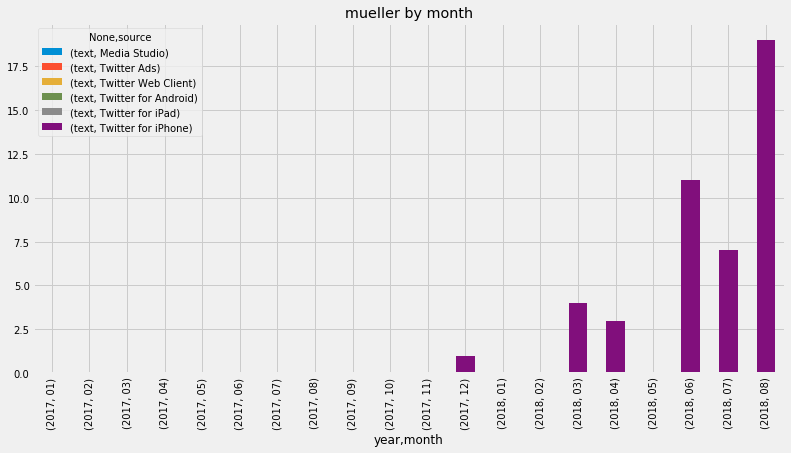

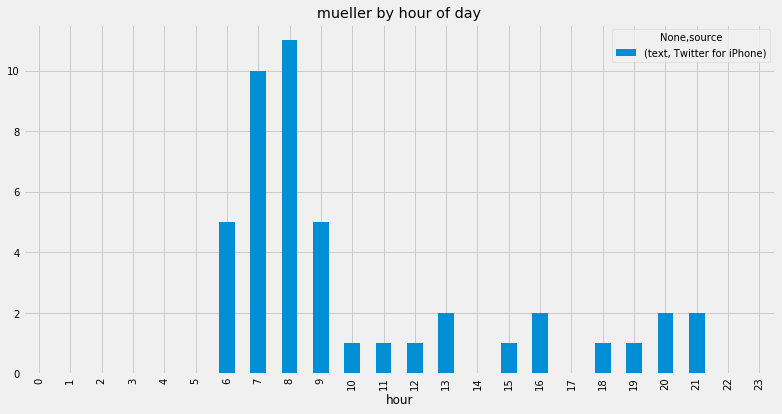

### The Tweets

[Thursday, Aug 30, 2018 9:39 AM](https://twitter.com/realDonaldTrump/status/1035159956507566080): I am very excited about the person who will be taking the place of Don McGahn as White House Counsel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Thursday, Aug 30, 2018 8:12 AM](https://twitter.com/realDonaldTrump/status/1035138155794575360): I am very excited about the person who will be taking the place of Don McGahn as White House Councel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Saturday, Aug 25, 2018 8:36 AM](https://twitter.com/realDonaldTrump/status/1033332301579661312): Jeff Sessions said he wouldn’t allow politics to influence him only because he doesn’t understand what is happening underneath his command position. Highly conflicted Bob Mueller and his gang of 17 Angry Dems are having a field day as real corruption goes untouched. No Collusion!

[Friday, Aug 24, 2018 6:17 AM](https://twitter.com/realDonaldTrump/status/1032934937962442754): “Department of Justice will not be improperly influenced by political considerations.” Jeff, this is GREAT, what everyone wants, so look into all of the corruption on the “other side” including deleted Emails, Comey lies &amp; leaks, Mueller conflicts, McCabe, Strzok, Page, Ohr......

[Monday, Aug 20, 2018 10:13 AM](https://twitter.com/realDonaldTrump/status/1031544711717302272): I hope John Brennan, the worst CIA Director in our country’s history, brings a lawsuit. It will then be very easy to get all of his records, texts, emails and documents to show not only the poor job he did, but how he was involved with the Mueller Rigged Witch Hunt. He won’t sue!

[Monday, Aug 20, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1031505811074412544): ....looking for trouble. They are enjoying ruining people’s lives and REFUSE to look at the real corruption on the Democrat side - the lies, the firings, the deleted Emails and soooo much more! Mueller’s Angry Dems are looking to impact the election. They are a National Disgrace!

[Monday, Aug 20, 2018 7:28 AM](https://twitter.com/realDonaldTrump/status/1031503298967363586): Disgraced and discredited Bob Mueller and his whole group of Angry Democrat Thugs spent over 30 hours with the White House Councel, only with my approval, for purposes of transparency. Anybody needing that much time when they know there is no Russian Collusion is just someone....

[Sunday, Aug 19, 2018 8:24 AM](https://twitter.com/realDonaldTrump/status/1031154974942810114): Study the late Joseph McCarthy, because we are now in period with Mueller and his gang that make Joseph McCarthy look like a baby! Rigged Witch Hunt!

[Sunday, Aug 19, 2018 7:30 AM](https://twitter.com/realDonaldTrump/status/1031141396776984576): No Collusion and No Obstruction, except by Crooked Hillary and the Democrats. All of the resignations and corruption, yet heavily conflicted Bob Mueller refuses to even look in that direction. What about the Brennan, Comey, McCabe, Strzok lies to Congress, or Crooked’s Emails!

[Sunday, Aug 19, 2018 7:15 AM](https://twitter.com/realDonaldTrump/status/1031137499995930624): ....and have demanded transparency so that this Rigged and Disgusting Witch Hunt can come to a close. So many lives have been ruined over nothing - McCarthyism at its WORST! Yet Mueller &amp; his gang of Dems refuse to look at the real crimes on the other side - Media is even worse!

[Friday, Aug 17, 2018 9:47 PM](https://twitter.com/realDonaldTrump/status/1030632303507243008): ....financial gain is a Federal Gratuity Statute Violation, Bribery Statute Violation, Honest Services Violation....all Major Crimes....because the DOJ is run by BLANK Jeff Sessions......”  Gregg Jarrett.  So when does Mueller do what must be done? Probably never! @FoxNews

[Friday, Aug 17, 2018 6:29 PM](https://twitter.com/realDonaldTrump/status/1030582354308411392): “Fox News has learned that Bruce Ohr wrote Christopher Steele following the firing of James Comey saying that he was afraid the anti-Trump Russia probe will be exposed.”  Charles Payne  @FoxBusiness   How much more does Mueller have to see? They have blinders on - RIGGED!

[Tuesday, Aug 14, 2018 7:07 AM](https://twitter.com/realDonaldTrump/status/1029323499226243072): ....guy was corrupt and had anti-Trump animus. Strzok and others at the FBI should be criminally investigated for the way the conducted this investigation. Instead, Mueller is pretending nothing went wrong. He used Strzok, he used the Clinton DNC Dossier...the whole thing....

[Tuesday, Aug 14, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1029321624603054080): Tom Fitton of Judicial Watch: “The Strzok firing is as much about the Mueller operation as anything else. There would be no Mueller Special Councel to investigate so called collusion but for the machinations of Strzok &amp; his colleagues at the top levels of the FBI. We know this...

[Sunday, Aug 12, 2018 8:24 AM](https://twitter.com/realDonaldTrump/status/1028618150944944129): .@JudgeJeanine  “Bob Mueller, isn’t your whole investigation premised on a Fake Dossier, paid for by Hillary, created by a man who hates Donald Trump, &amp; used to con a FISA Court Judge. Bob, I really think it’s time for you to give up your phony investigation.” No Collusion!

[Sunday, Aug 5, 2018 8:45 AM](https://twitter.com/realDonaldTrump/status/1026086905539174400): ...Why aren’t Mueller and the 17 Angry Democrats looking at the meetings concerning the Fake Dossier and all of the lying that went on in the FBI and DOJ? This is the most one sided Witch Hunt in the history of our country. Fortunately, the facts are all coming out, and fast!

[Wednesday, Aug 1, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1024646945640525826): ..This is a terrible situation and Attorney General Jeff Sessions should stop this Rigged Witch Hunt right now, before it continues to stain our country any further. Bob Mueller is totally conflicted, and his 17 Angry Democrats that are doing his dirty work are a disgrace to USA!

[Wednesday, Aug 1, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1024644767924334593): .....remain in the FBI while he himself was being investigated. This is a real issue. It won’t go into a Mueller Report because Mueller is going to protect these guys. Mueller has an interest in creating the illusion of objectivity around his investigation.” ALAN DERSHOWITZ....

[Wednesday, Aug 1, 2018 9:03 AM](https://twitter.com/realDonaldTrump/status/1024641683600879616): “FBI Agent Peter Strzok (on the Mueller team) should have recused himself on day one. He was out to STOP THE ELECTION OF DONALD TRUMP. He needed an insurance policy. Those are illegal, improper goals, trying to influence the Election. He should never, ever been allowed to........

[Sunday, Jul 29, 2018 4:20 PM](https://twitter.com/realDonaldTrump/status/1023664624259014656): ....Also, why is Mueller only appointing Angry Dems, some of whom have worked for Crooked Hillary, others, including himself, have worked for Obama....And why isn’t Mueller looking at all of the criminal activity &amp; real Russian Collusion on the Democrats side-Podesta, Dossier?

[Sunday, Jul 29, 2018 4:12 PM](https://twitter.com/realDonaldTrump/status/1023662510371741696): Is Robert Mueller ever going to release his conflicts of interest with respect to President Trump, including the fact that we had a very nasty &amp; contentious business relationship, I turned him down to head the FBI (one day before appointment as S.C.) &amp; Comey is his close friend..

[Sunday, Jul 29, 2018 3:35 PM](https://twitter.com/realDonaldTrump/status/1023653191974625280): There is No Collusion! The Robert Mueller Rigged Witch Hunt, headed now by 17 (increased from 13, including an Obama White House lawyer) Angry Democrats, was started by a fraudulent Dossier, paid for by Crooked Hillary and the DNC. Therefore, the Witch Hunt is an illegal Scam!

[Friday, Jul 27, 2018 7:26 AM](https://twitter.com/realDonaldTrump/status/1022805381440069632): Arrived back in Washington last night from a very emotional reopening of a major U.S. Steel plant in Granite City, Illinois, only to be greeted with the ridiculous news that the highly conflicted Robert Mueller and his gang of 13 Angry Democrats obviously cannot find Collusion...

[Monday, Jul 23, 2018 7:09 AM](https://twitter.com/realDonaldTrump/status/1021351630648815616): .....”Carter Page wasn’t a spy, wasn’t an agent of the Russians - he would have cooperated with the FBI. It was a fraud and a hoax designed to target Trump.” Tom Fitton @JudicialWatch A disgrace to America. They should drop the discredited Mueller Witch Hunt now!

[Monday, Jul 23, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/1021341698734030848): So we now find out that it was indeed the unverified and Fake Dirty Dossier, that was paid for by Crooked Hillary Clinton and the DNC, that was knowingly &amp; falsely submitted to FISA and which was responsible for starting the totally conflicted and discredited Mueller Witch Hunt!

[Sunday, Jul 22, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/1021007656511852544): Andrew McCarthy - “I said this could never happen. This is so bad that they should be looking at the judges who signed off on this stuff, not just the people who gave it. It is so bad it screams out at you.”  On the whole FISA scam which led to the rigged Mueller Witch Hunt!

[Thursday, Jun 28, 2018 8:43 AM](https://twitter.com/realDonaldTrump/status/1012315534220808192): When is Bob Mueller going to list his Conflicts of Interest? Why has it taken so long? Will they be listed at the top of his $22,000,000 Report...And what about the 13 Angry Democrats, will they list their conflicts with Crooked H? How many people will be sent to jail and......

[Thursday, Jun 28, 2018 8:30 AM](https://twitter.com/realDonaldTrump/status/1012312287280074754): Peter Strzok worked as the leader of the Rigged Witch Hunt for a long period of time - he got it started and was only fired because the gig was up. But remember, he took his orders from Comey and McCabe and they took their orders from you know who. Mueller/Comey best friends!

[Monday, Jun 25, 2018 7:22 PM](https://twitter.com/realDonaldTrump/status/1011389124475961345): Why is Senator Mark Warner (D-VA), perhaps in a near drunken state, claiming he has information that only he and Bob Mueller, the leader of the 13 Angry Democrats on a Witch Hunt, knows? Isn’t this highly illegal. Is it being investigated?

[Monday, Jun 18, 2018 11:27 AM](https://twitter.com/realDonaldTrump/status/1008732992481710081): Comey gave Strozk his marching orders. Mueller is Comey’s best friend. Witch Hunt!

[Sunday, Jun 17, 2018 9:03 PM](https://twitter.com/realDonaldTrump/status/1008515606751084544): “The highest level of bias I’ve ever witnessed in any law enforcement officer.” Trey Gowdy on the FBI’s own, Peter Strzok. Also remember that they all worked for Slippery James Comey and that Comey is best friends with Robert Mueller. A really sick deal, isn’t it?

[Sunday, Jun 17, 2018 8:42 PM](https://twitter.com/realDonaldTrump/status/1008510118395293699): Why was the FBI’s sick loser, Peter Strzok, working on the totally discredited Mueller team of 13 Angry &amp; Conflicted Democrats, when Strzok was giving Crooked Hillary a free pass yet telling his lover, lawyer Lisa Page, that “we’ll stop” Trump from becoming President? Witch Hunt!

[Sunday, Jun 17, 2018 8:31 AM](https://twitter.com/realDonaldTrump/status/1008326335083761664): Daniel Henninger of The Wall Street Journal: “This IG Report makes it clear, as did Rod Rosenstein’s memo, that Trump was absolutely justified, unquestionably justified, in firing Jim Comey. So I think the Mueller Investigation is on pretty weak grounds right now.”  Witch Hunt!

[Friday, Jun 15, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1007592416197607424): RT @foxandfriends: .@jasoninthehouse: Anything Mueller is doing with his investigation is tainted by the anti-Trump FBI agents https://t.co…

[Sunday, Jun 3, 2018 1:34 PM](https://twitter.com/realDonaldTrump/status/1003328970069331968): Mark Penn  “Why are there people from the Clinton Foundation on the Mueller Staff? Why is there an Independent Counsel? To go after people and their families for unrelated offenses...Constitution was set up to prevent this...Stormtrooper tactics almost.” A disgrace!

[Sunday, Jun 3, 2018 1:25 PM](https://twitter.com/realDonaldTrump/status/1003326698228764672): Mark Penn  “Why are there people from the Clinton Foundation on the Mueller Staff? Why is there an Independent Councel? To go after people and their families for unrelated offenses...Constitution was set up to prevent this...Stormtrooper tactics almost.” A disgrace!

[Saturday, Jun 2, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1002892787803676673): ....“$17 million spent, it’s a scam Investigation. Americans are being worked. We now know there was Russian collusion, with Russians and the Democrats. The Mueller team is stacked with anti-Trumpers, who actually represented Clinton people (&amp; gave $’s to Crooked H).” Dan Bongino

[Thursday, Apr 12, 2018 12:46 PM](https://twitter.com/realDonaldTrump/status/984472778035417088): I have agreed with the historically cooperative, disciplined approach that we have engaged in with Robert Mueller (Unlike the Clintons!). I have full confidence in Ty Cobb, my Special Counsel, and have been fully advised throughout each phase of this process.

[Thursday, Apr 12, 2018 6:03 AM](https://twitter.com/realDonaldTrump/status/984371491277099010): If I wanted to fire Robert Mueller in December, as reported by the Failing New York Times, I would have fired him. Just more Fake News from a biased newspaper!

[Wednesday, Apr 11, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/984053549742067712): Much of the bad blood with Russia is caused by the Fake &amp; Corrupt Russia Investigation, headed up by the all Democrat loyalists, or people that worked for Obama. Mueller is most conflicted of all (except Rosenstein who signed FISA &amp; Comey letter). No Collusion, so they go crazy!

[Wednesday, Mar 21, 2018 7:29 AM](https://twitter.com/realDonaldTrump/status/976420417090015232): “Special Council is told to find crimes, whether a crime exists or not. I was opposed to the selection of Mueller to be Special Council. I am still opposed to it. I think President Trump was right when he said there never should have been a Special Council appointed because.....

[Wednesday, Mar 21, 2018 7:03 AM](https://twitter.com/realDonaldTrump/status/976413956293226496): “Special Council is told to find crimes, wether crimes exist or not. I was opposed the the selection of Mueller to be Special Council, I still am opposed to it. I think President Trump was right when he said there never should have been a Special Council appointed because.....

[Sunday, Mar 18, 2018 8:35 AM](https://twitter.com/realDonaldTrump/status/975350027169206273): Why does the Mueller team have 13 hardened Democrats, some big Crooked Hillary supporters, and Zero Republicans? Another Dem recently added...does anyone think this is fair? And yet, there is NO COLLUSION!

[Saturday, Mar 17, 2018 8:12 PM](https://twitter.com/realDonaldTrump/status/975163071361683456): The Mueller probe should never have been started in that there was no collusion and there was no crime. It was based on fraudulent activities and a Fake Dossier paid for by Crooked Hillary and the DNC, and improperly used in FISA COURT for surveillance of my campaign. WITCH HUNT!

[Sunday, Dec 3, 2017 6:46 AM](https://twitter.com/realDonaldTrump/status/937286804201451521): RT @paulsperry_: BREAKING: top FBI investigator for Mueller--PETER STRZOK--busted sending political text messages bashing Trump &amp; praising…

---

## Search: _sessions_

Number of Tweets: 24

Percent of all Tweets: 0.53%

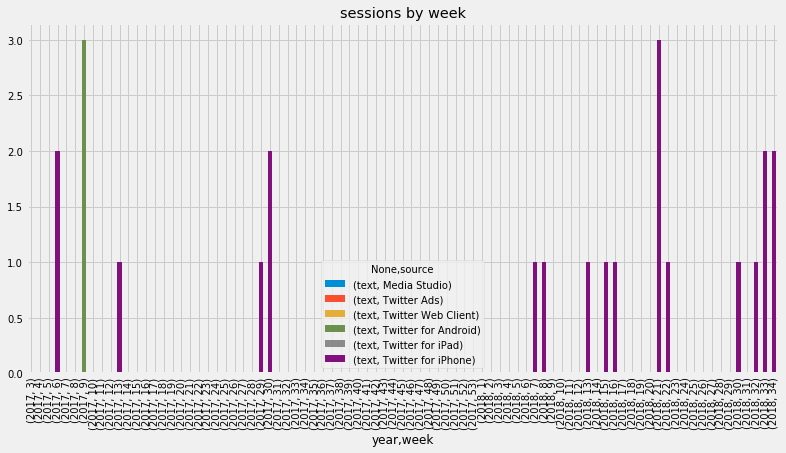

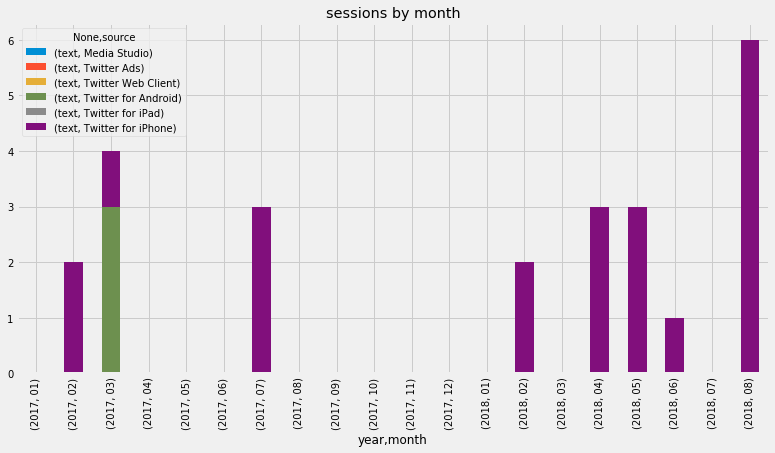

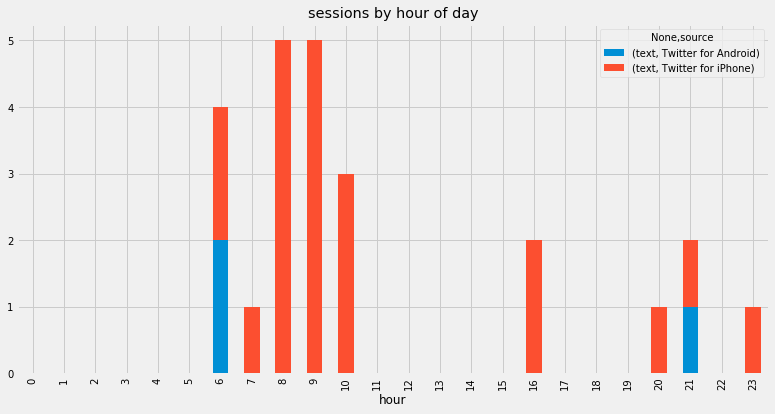

### The Tweets

[Thursday, Aug 30, 2018 9:39 AM](https://twitter.com/realDonaldTrump/status/1035159956507566080): I am very excited about the person who will be taking the place of Don McGahn as White House Counsel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Thursday, Aug 30, 2018 8:12 AM](https://twitter.com/realDonaldTrump/status/1035138155794575360): I am very excited about the person who will be taking the place of Don McGahn as White House Councel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Saturday, Aug 25, 2018 8:36 AM](https://twitter.com/realDonaldTrump/status/1033332301579661312): Jeff Sessions said he wouldn’t allow politics to influence him only because he doesn’t understand what is happening underneath his command position. Highly conflicted Bob Mueller and his gang of 17 Angry Dems are having a field day as real corruption goes untouched. No Collusion!

[Monday, Aug 20, 2018 10:36 AM](https://twitter.com/realDonaldTrump/status/1031550517552603138): Will Bruce Ohr, whose family received big money for helping to create the phony, dirty and discredited Dossier, ever be fired from the Jeff Sessions  “Justice” Department? A total joke!

[Friday, Aug 17, 2018 9:47 PM](https://twitter.com/realDonaldTrump/status/1030632303507243008): ....financial gain is a Federal Gratuity Statute Violation, Bribery Statute Violation, Honest Services Violation....all Major Crimes....because the DOJ is run by BLANK Jeff Sessions......”  Gregg Jarrett.  So when does Mueller do what must be done? Probably never! @FoxNews

[Wednesday, Aug 1, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1024646945640525826): ..This is a terrible situation and Attorney General Jeff Sessions should stop this Rigged Witch Hunt right now, before it continues to stain our country any further. Bob Mueller is totally conflicted, and his 17 Angry Democrats that are doing his dirty work are a disgrace to USA!

[Tuesday, Jun 5, 2018 7:31 AM](https://twitter.com/realDonaldTrump/status/1003962584352030720): The Russian Witch Hunt Hoax continues, all because Jeff Sessions didn’t tell me he was going to recuse himself...I would have quickly picked someone else. So much time and money wasted, so many lives ruined...and Sessions knew better than most that there was No Collusion!

[Wednesday, May 30, 2018 11:21 PM](https://twitter.com/realDonaldTrump/status/1002027245131661312): “The recusal of Jeff Sessions was an unforced betrayal of the President of the United States.” JOE DIGENOVA, former U.S. Attorney.

[Wednesday, May 30, 2018 8:47 AM](https://twitter.com/realDonaldTrump/status/1001807204519997442): ....chief law enforcement officer, and they told me later, ‘oh by the way I’m not going to be able to participate in the most important case in the office, I would be frustrated too...and that’s how I read that - Senator Sessions, why didn’t you tell me before I picked you.....

[Wednesday, May 30, 2018 8:46 AM](https://twitter.com/realDonaldTrump/status/1001807174249713664): Rep.Trey Gowdy, “I don’t think so, I think what the President is doing is expressing frustration that Attorney General Sessions should have shared these reasons for recusal before he took the job, not afterward. If I were the President and I picked someone to be the country’s....

[Sunday, Apr 22, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/988030312088260608): “GOP Lawmakers asking Sessions to Investigate Comey and Hillary Clinton.” @FoxNews   Good luck with that request!

[Saturday, Apr 21, 2018 4:13 PM](https://twitter.com/realDonaldTrump/status/987786331995672576): The Washington Post said I refer to Jeff Sessions as “Mr. Magoo” and Rod Rosenstein as “Mr. Peepers.” This is “according to people with whom the president has spoken.” There are no such people and don’t know these characters...just more Fake &amp; Disgusting News to create ill will!

[Friday, Apr 6, 2018 10:46 AM](https://twitter.com/realDonaldTrump/status/982268230306709509): Do you believe that the Fake News Media is pushing hard on a story that I am going to replace A.G. Jeff Sessions with EPA Chief Scott Pruitt, who is doing a great job but is TOTALLY under siege? Do people really believe this stuff? So much of the media is dishonest and corrupt!

[Wednesday, Feb 28, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/968856971075051521): Why is A.G. Jeff Sessions asking the Inspector General to investigate potentially massive FISA abuse. Will take forever, has no prosecutorial power and already late with reports on Comey etc. Isn’t the I.G. an Obama guy? Why not use Justice Department lawyers? DISGRACEFUL!

[Wednesday, Feb 21, 2018 9:40 AM](https://twitter.com/realDonaldTrump/status/966321700588711936): Question: If all of the Russian meddling took place during the Obama Administration, right up to January 20th, why aren’t they the subject of the investigation? Why didn’t Obama do something about the meddling? Why aren’t Dem crimes under investigation? Ask Jeff Sessions!

[Wednesday, Jul 26, 2017 9:48 AM](https://twitter.com/realDonaldTrump/status/890207082926022656): Why didn't A.G. Sessions replace Acting FBI Director Andrew McCabe, a Comey friend who was in charge of Clinton investigation but got....

[Tuesday, Jul 25, 2017 6:12 AM](https://twitter.com/realDonaldTrump/status/889790429398528000): Attorney General Jeff Sessions has taken a VERY weak position on Hillary Clinton crimes (where are E-mails &amp; DNC server) &amp; Intel leakers!

[Saturday, Jul 22, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/888708453560184832): A new INTELLIGENCE LEAK from the Amazon Washington Post,this time against A.G. Jeff Sessions.These illegal leaks, like Comey's, must stop!

[Tuesday, Mar 28, 2017 4:57 PM](https://twitter.com/realDonaldTrump/status/846828561491202048): It was an honor to welcome @GLFOP to the @WhiteHouse today with @VP Pence &amp; Attorney General Sessions. THANK YOU fo… https://t.co/VHzTB4c69h

[Saturday, Mar 4, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/837991759045079040): Just out: The same Russian Ambassador that met Jeff Sessions visited the Obama White House 22 times, and 4 times last year alone.

[Saturday, Mar 4, 2017 6:26 AM](https://twitter.com/realDonaldTrump/status/837987684660412416): The first meeting Jeff Sessions had with the Russian Amb was set up by the Obama Administration under education program for 100 Ambs......

[Thursday, Mar 2, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/837488402438176769): Jeff Sessions is an honest man. He did not say anything wrong. He could have stated his response more accurately, but it was clearly not....

[Thursday, Feb 9, 2017 10:58 AM](https://twitter.com/realDonaldTrump/status/829721019720015872): Join us live in the Oval Office for the swearing in of our new Attorney General, @SenatorSessions!
LIVE:… https://t.co/QeW6vjog4A

[Wednesday, Feb 8, 2017 8:05 PM](https://twitter.com/realDonaldTrump/status/829496507841789952): Congratulations to our new Attorney General, @SenatorSessions! https://t.co/e0buP1K83z

---

## Search: _justice_

Number of Tweets: 85

Percent of all Tweets: 1.86%

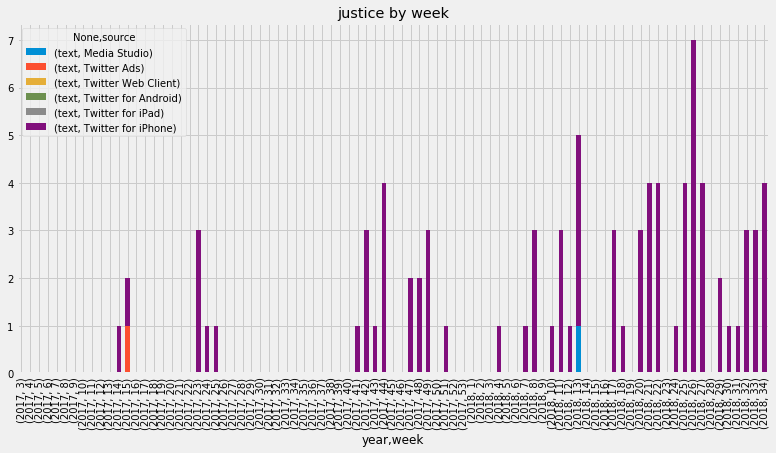

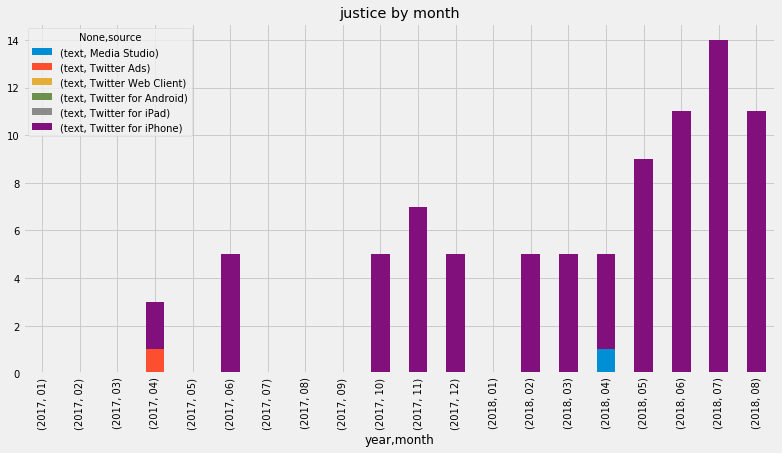

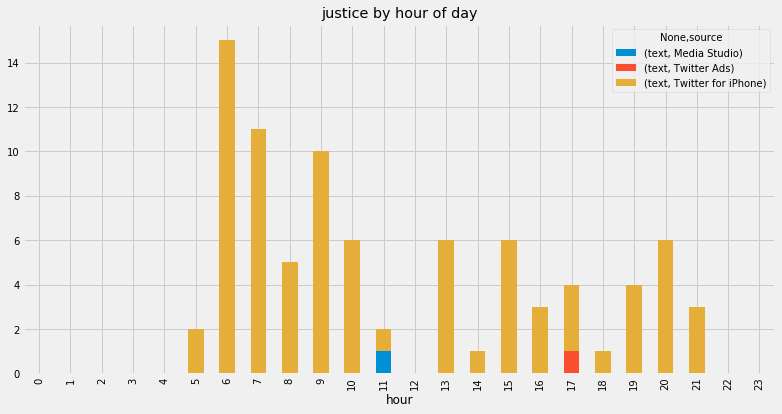

### The Tweets

[Thursday, Aug 30, 2018 8:54 AM](https://twitter.com/realDonaldTrump/status/1035148684432953346): Wow, Nellie Ohr, Bruce Ohr’s wife, is a Russia expert who is fluent in Russian. She worked for Fusion GPS where she was paid a lot. Collusion! Bruce was a boss at the Department of Justice and is, unbelievably, still there!

[Wednesday, Aug 29, 2018 9:43 PM](https://twitter.com/realDonaldTrump/status/1034979892524457985): “Ohr told the FBI it (the Fake Dossier) wasn’t true, it was a lie and the FBI was determined to use it anyway to damage Trump and to perpetrate a fraud on the court to spy on the Trump campaign. This is a fraud on the court. The Chief Justice of the U.S. Supreme Court is in......

[Wednesday, Aug 29, 2018 11:12 AM](https://twitter.com/realDonaldTrump/status/1034821067423014913): How the hell is Bruce Ohr still employed at the Justice Department? Disgraceful!  Witch Hunt!

[Sunday, Aug 26, 2018 9:21 AM](https://twitter.com/realDonaldTrump/status/1033706045988892672): RT @realDonaldTrump: “Department of Justice will not be improperly influenced by political considerations.” Jeff, this is GREAT, what every…

[Friday, Aug 24, 2018 6:17 AM](https://twitter.com/realDonaldTrump/status/1032934937962442754): “Department of Justice will not be improperly influenced by political considerations.” Jeff, this is GREAT, what everyone wants, so look into all of the corruption on the “other side” including deleted Emails, Comey lies &amp; leaks, Mueller conflicts, McCabe, Strzok, Page, Ohr......

[Wednesday, Aug 22, 2018 9:21 AM](https://twitter.com/realDonaldTrump/status/1032256443985084417): I feel very badly for Paul Manafort and his wonderful family. “Justice” took a 12 year old tax case, among other things, applied tremendous pressure on him and, unlike Michael Cohen, he refused to “break” - make up stories in order to get a “deal.” Such respect for a brave man!

[Monday, Aug 20, 2018 10:36 AM](https://twitter.com/realDonaldTrump/status/1031550517552603138): Will Bruce Ohr, whose family received big money for helping to create the phony, dirty and discredited Dossier, ever be fired from the Jeff Sessions  “Justice” Department? A total joke!

[Thursday, Aug 16, 2018 7:37 PM](https://twitter.com/realDonaldTrump/status/1030237078586617856): “The FBI received documents from Bruce Ohr (of the Justice Department &amp; whose wife Nelly worked for Fusion GPS).” Disgraced and fired FBI Agent Peter Strzok. This is too crazy to be believed! The Rigged Witch Hunt has zero credibility.

[Tuesday, Aug 14, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1029335579845115904): Bruce Ohr of the “Justice” Department (can you believe he is still there) is accused of helping disgraced Christopher Steele “find dirt on Trump.” Ohr’s wife, Nelly, was in on the act big time - worked for Fusion GPS on Fake Dossier. @foxandfriends

[Sunday, Aug 12, 2018 9:25 AM](https://twitter.com/realDonaldTrump/status/1028633682918166528): “Seems like the Department of Justice (and FBI) had a program to keep Donald Trump from becoming President”. @DarrellIssa  @foxandfriends  If this had happened to the other side, everybody involved would be in jail. This is a Media coverup of the biggest story of our time.

[Saturday, Aug 11, 2018 2:54 PM](https://twitter.com/realDonaldTrump/status/1028354010129027077): ....Do you believe Nelly worked for Fusion and her husband STILL WORKS FOR THE DEPARTMENT OF “JUSTICE.” I have never seen anything so Rigged in my life. Our A.G. is scared stiff and Missing in Action. It is all starting to be revealed - not pretty. IG Report soon?  Witch Hunt!

[Monday, Jul 30, 2018 6:36 PM](https://twitter.com/realDonaldTrump/status/1024061082640502785): Thank you to @RandPaul for your YES on a future great Justice of the Supreme Court, Brett Kavanaugh. Your vote means a lot to me, and to everyone who loves our Country!

[Monday, Jul 23, 2018 6:52 AM](https://twitter.com/realDonaldTrump/status/1021347230022807552): “It was classified to cover up misconduct by the FBI and the Justice Department in misleading the Court by using this Dossier in a dishonest way to gain a warrant to target the Trump Team. This is a Clinton Campaign document. It was a fraud and a hoax designed to target Trump....

[Sunday, Jul 22, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/1020978929736265729): Congratulations to @JudicialWatch and @TomFitton on being successful in getting the Carter Page FISA documents. As usual they are ridiculously heavily redacted but confirm with little doubt that the Department of “Justice” and FBI misled the courts. Witch Hunt Rigged, a Scam!

[Tuesday, Jul 10, 2018 5:00 AM](https://twitter.com/realDonaldTrump/status/1016608157655805953): RT @Scavino45: “The Rule of Law is our Nation’s proud heritage. It is the cornerstone of our Freedom. It is what guarantees equal justice -…

[Monday, Jul 9, 2018 9:01 PM](https://twitter.com/realDonaldTrump/status/1016487491065565184): RT @WhiteHouse: President Trump Announces the Nominee for Associate Justice of the Supreme Court https://t.co/rVMTOMpurr

[Monday, Jul 9, 2018 8:14 AM](https://twitter.com/realDonaldTrump/status/1016294574417956869): I have long heard that the most important decision a U.S. President can make is the selection of a Supreme Court Justice - Will be announced tonight at 9:00 P.M.

[Sunday, Jul 8, 2018 5:27 PM](https://twitter.com/realDonaldTrump/status/1016071245568380934): Looking forward to announcing my final decision on the United States Supreme Court Justice at 9:00pmE tomorrow night at the @WhiteHouse. An exceptional person will be chosen!

[Saturday, Jul 7, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1015587406374932480): Big decision will soon be made on our next Justice of the Supreme Court!

[Thursday, Jul 5, 2018 8:44 PM](https://twitter.com/realDonaldTrump/status/1015033658548207616): A vote for Democrats in November is a vote to let MS-13 run wild in our communities, to let drugs pour into our cities, and to take jobs and benefits away from hardworking Americans. Democrats want anarchy, amnesty and chaos - Republicans want LAW, ORDER and JUSTICE!

[Tuesday, Jul 3, 2018 7:52 PM](https://twitter.com/realDonaldTrump/status/1014295759393644545): ...has endured because of the sweat, blood and sacrifice of the American Armed Forces – the greatest force for peace and justice in the history of the world!

[Tuesday, Jul 3, 2018 7:19 PM](https://twitter.com/realDonaldTrump/status/1014287566386888709): Thank you, @WVGovernor Jim Justice, for that warm introduction. Tonight, it was my great honor to attend the “Greenbrier Classic – Salute to Service Dinner” in West Virginia! God Bless our Veterans. God Bless America - and HAPPY INDEPENDENCE DAY TO ALL! https://t.co/V35qvCN8m6

[Tuesday, Jul 3, 2018 5:26 PM](https://twitter.com/realDonaldTrump/status/1014258987422928896): Heading to West Virginia to be with my friend, @WVGovernor Jim Justice, at his beautiful Greenbrier Resort. He works hard, does a great job, and raises lots of money for charities!

[Tuesday, Jul 3, 2018 6:25 AM](https://twitter.com/realDonaldTrump/status/1014092792329535488): I interviewed 4 very impressive people yesterday. On Monday I will be announcing my decision for Justice of the United States Supreme Court!

[Sunday, Jul 1, 2018 3:39 PM](https://twitter.com/realDonaldTrump/status/1013507396558303233): A big week, especially with our numerous victories in the Supreme Court. Heading back to the White House now. Focus will be on the selection of a new Supreme Court Justice. Exciting times for our country. Economy may be stronger than it has ever been!

[Saturday, Jun 30, 2018 8:33 AM](https://twitter.com/realDonaldTrump/status/1013037916216614912): I will be making my choice for Justice of the United States Supreme Court on the first Monday after the July 4th Holiday, July 9th!

[Wednesday, Jun 27, 2018 3:13 PM](https://twitter.com/realDonaldTrump/status/1012051330591023107): Statement on Justice Anthony Kennedy. #SCOTUS https://t.co/8aWJ6fWemA

[Tuesday, Jun 26, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/1011602664143106048): “The most profound question of our era: Was there a conspiracy in the Obama Department of Justice and the FBI to prevent Donald Trump from becoming President of the U.S., and was Strzok at the core of the conspiracy?”  Judge Andrew Napolitano

[Monday, Jun 25, 2018 8:02 AM](https://twitter.com/realDonaldTrump/status/1011218033216512005): I have tried to stay uninvolved with the Department of Justice and FBI (although I do not legally have to), because of the now totally discredited and very expensive Witch Hunt currently going on. But you do have to ask why the DOJ &amp; FBI aren’t giving over requested documents?

[Saturday, Jun 23, 2018 1:12 PM](https://twitter.com/realDonaldTrump/status/1010571197271011328): Happy Birthday to Supreme Court Justice Clarence Thomas, a friend and great man! https://t.co/hlXYYkTjcv

[Thursday, Jun 7, 2018 10:07 AM](https://twitter.com/realDonaldTrump/status/1004726490058182656): Our Justice Department must not let Awan &amp; Debbie Wasserman Schultz off the hook. The Democrat I.T. scandal is a key to much of the corruption we see today. They want to make a “plea deal” to hide what is on their Server. Where is Server? Really bad!

[Thursday, Jun 7, 2018 9:05 AM](https://twitter.com/realDonaldTrump/status/1004710919853760512): Alan Dershowitz, Harvard Law Professor: “It all proves that we never needed a Special Counsel....All of this could have been done by the Justice Dept. Don’t need a multi-million dollar group of people with a target on someone’s back. Not the way Justice should operate.” So true!

[Thursday, Jun 7, 2018 8:58 AM](https://twitter.com/realDonaldTrump/status/1004709222196699136): Alan Dershowitz, Harvard Law Professor: “It all proves that we never needed a Special Councel....All of this could have been done by the Justice Dept. Don’t need a multi-million dollar group of people with a target on someone’s back. Not the way Justice should operate.” So true!

[Sunday, Jun 3, 2018 9:25 AM](https://twitter.com/realDonaldTrump/status/1003266374473519105): As only one of two people left who could become President, why wouldn’t the FBI or Department of “Justice” have told me that they were secretly investigating Paul Manafort (on charges that were 10 years old and had been previously dropped) during my campaign? Should have told me!

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Tuesday, May 29, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/1001424695126880258): Sorry, I’ve got to start focusing my energy on North Korea Nuclear, bad Trade Deals, VA Choice, the Economy, rebuilding the Military, and so much more, and not on the Rigged Russia Witch Hunt that should be investigating Clinton/Russia/FBI/Justice/Obama/Comey/Lynch etc.

[Monday, May 28, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/1001103028626345984): “Sally Yates is part of concerns people have raised about bias in the Justice Dept. I find her actions to be really quite unbelievable.” Jonathan Turley

[Saturday, May 26, 2018 3:56 PM](https://twitter.com/realDonaldTrump/status/1000465814192099330): When will the 13 Angry Democrats (&amp; those who worked for President O), reveal their disqualifying Conflicts of Interest? It’s been a long time now! Will they be indelibly written into the Report along with the fact that the only Collusion is with the Dems, Justice, FBI &amp; Russia?

[Saturday, May 26, 2018 3:28 PM](https://twitter.com/realDonaldTrump/status/1000458567147839488): With Spies, or “Informants” as the Democrats like to call them because it sounds less sinister (but it’s not), all over my campaign, even from a very early date, why didn’t the crooked highest levels of the FBI or “Justice” contact me to tell me of the  phony Russia problem?

[Sunday, May 20, 2018 1:37 PM](https://twitter.com/realDonaldTrump/status/998256454590193665): I hereby demand, and will do so officially tomorrow, that the Department of Justice look into whether or not the FBI/DOJ infiltrated or surveilled the Trump Campaign for Political Purposes - and if any such demands or requests were made by people within the Obama Administration!

[Monday, May 7, 2018 7:39 AM](https://twitter.com/realDonaldTrump/status/993455375755173892): The 13 Angry Democrats in charge of the Russian Witch Hunt are starting to find out that there is a Court System in place that actually protects people from injustice...and just wait ‘till the Courts get to see your unrevealed Conflicts of Interest!

[Wednesday, May 2, 2018 10:45 AM](https://twitter.com/realDonaldTrump/status/991690248399794176): A Rigged System - They don’t want to turn over Documents to Congress. What are they afraid of? Why so much redacting? Why such unequal “justice?” At some point I will have no choice but to use the powers granted to the Presidency and get involved!

[Wednesday, May 2, 2018 7:45 AM](https://twitter.com/realDonaldTrump/status/991644756995444736): There was no Collusion (it is a Hoax) and there is no Obstruction of Justice (that is a setup &amp; trap). What there is is Negotiations going on with North Korea over Nuclear War, Negotiations going on with China over Trade Deficits, Negotiations on NAFTA, and much more. Witch Hunt!

[Tuesday, May 1, 2018 7:34 AM](https://twitter.com/realDonaldTrump/status/991279620044591105): It would seem very hard to obstruct justice for a crime that never happened! Witch Hunt!

[Saturday, Apr 7, 2018 5:00 PM](https://twitter.com/realDonaldTrump/status/982724858743328777): What does the Department of Justice and FBI have to hide? Why aren’t they giving the strongly requested documents (unredacted) to the HOUSE JUDICIARY COMMITTEE? Stalling, but for what reason? Not looking good!

[Saturday, Apr 7, 2018 4:52 PM](https://twitter.com/realDonaldTrump/status/982722926305832960): Lawmakers of the House Judiciary Committee are angrily accusing the Department of Justice of missing the Thursday Deadline for turning over UNREDACTED Documents relating to FISA abuse, FBI, Comey, Lynch, McCabe, Clinton Emails and much more. Slow walking - what is going on? BAD!

[Thursday, Apr 5, 2018 4:28 PM](https://twitter.com/realDonaldTrump/status/981992052786425856): Thank you @WVGovernor Jim Justice. It was my great honor to be with the amazing people of West Virginia today! #MAGA https://t.co/IwPuQNadMM

[Wednesday, Apr 4, 2018 11:05 AM](https://twitter.com/realDonaldTrump/status/981548354088898560): Today we honor Dr. Martin Luther King, Jr. on the 50th anniversary of his assassination. Earlier this year I spoke about Dr. King’s legacy of justice and peace, and his impact on uniting Americans. #MLK50 Proclamation: https://t.co/XXtPO0VX5A https://t.co/SH0esMSyMT

[Monday, Apr 2, 2018 9:58 AM](https://twitter.com/realDonaldTrump/status/980806557846863872): So sad that the Department of “Justice” and the FBI are slow walking, or even not giving, the unredacted documents requested by Congress. An embarrassment to our country!

[Wednesday, Mar 28, 2018 5:52 AM](https://twitter.com/realDonaldTrump/status/978932860307505153): THE SECOND AMENDMENT WILL NEVER BE REPEALED! As much as Democrats would like to see this happen, and despite the words yesterday of former Supreme Court Justice Stevens, NO WAY. We need more Republicans in 2018 and must ALWAYS hold the Supreme Court!

[Friday, Mar 23, 2018 4:50 PM](https://twitter.com/realDonaldTrump/status/977286489410240514): Obama Administration legalized bump stocks. BAD IDEA. As I promised, today the Department of Justice will issue the rule banning BUMP STOCKS with a mandated comment period. We will BAN all devices that turn legal weapons into illegal machine guns.

[Wednesday, Mar 21, 2018 7:11 AM](https://twitter.com/realDonaldTrump/status/976415945714556928): ...there was no probable cause for believing that there was any crime, collusion or otherwise, or obstruction of justice!”  So stated by Harvard Law Professor Alan Dershowitz.

[Wednesday, Mar 21, 2018 6:52 AM](https://twitter.com/realDonaldTrump/status/976411208717950976): Department of Justice should have urged the Supreme Court to at least hear the Drivers License case on illegal immigrants in Arizona. I agree with @LouDobbs. Should have sought review.

[Saturday, Mar 17, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/975057131136274432): As the House Intelligence Committee has concluded, there was no collusion between Russia and the Trump Campaign. As many are now finding out, however, there was tremendous leaking, lying and corruption at the highest levels of the FBI, Justice &amp; State. #DrainTheSwamp

[Wednesday, Feb 28, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/968856971075051521): Why is A.G. Jeff Sessions asking the Inspector General to investigate potentially massive FISA abuse. Will take forever, has no prosecutorial power and already late with reports on Comey etc. Isn’t the I.G. an Obama guy? Why not use Justice Department lawyers? DISGRACEFUL!

[Tuesday, Feb 27, 2018 7:45 AM](https://twitter.com/realDonaldTrump/status/968467243192537088): “We’ve seen NO EVIDENCE OF COLLUSION....I have seen nothing, the firing of James Comey and all of the aftermath, that suggests that the President has obstructed justice because he’s exercising his power as the President of the U.S. I just don’t see it.”  Judge Ken Starr

[Tuesday, Feb 27, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/968455547094753281): “He’s got a very good point. Somebody in the Justice Department has a treasure trove of evidence of Mrs. Clinton’s criminality at her own hands, or through others, that ought to be investigated. I fully agree with the President on that.” @judgenapolitano on @marthamaccallum Show

[Sunday, Feb 18, 2018 7:02 AM](https://twitter.com/realDonaldTrump/status/965194903142719489): Never gotten over the fact that Obama was able to send $1.7 Billion Dollars in CASH to Iran and nobody in Congress, the FBI or Justice called for an investigation!

[Friday, Feb 2, 2018 6:33 AM](https://twitter.com/realDonaldTrump/status/959389424806191104): The top Leadership and Investigators of the FBI and the Justice Department have politicized the sacred investigative process in favor of Democrats and against Republicans - something which would have been unthinkable just a short time ago. Rank &amp; File are great people!

[Tuesday, Dec 19, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/943135588496093190): A  story in the @washingtonpost that I was close to “rescinding” the nomination of Justice Gorsuch prior to confirmation is FAKE NEWS. I never even wavered and am very proud of him and the job he is doing as a Justice of the U.S. Supreme Court. The unnamed sources don’t exist!

[Saturday, Dec 9, 2017 1:19 PM](https://twitter.com/realDonaldTrump/status/939560154269405184): It was my great honor to celebrate the opening of two extraordinary museums-the Mississippi State History Museum &amp; the Mississippi Civil Rights Museum. We pay solemn tribute to our heroes of the past &amp; dedicate ourselves to building a future of freedom, equality, justice &amp; peace. https://t.co/5AkgVpV8aa

[Sunday, Dec 3, 2017 7:27 AM](https://twitter.com/realDonaldTrump/status/937297341266190336): Such a total miscarriage of Justice in San Francisco! https://t.co/MSIkBCKF3t

[Saturday, Dec 2, 2017 9:13 PM](https://twitter.com/realDonaldTrump/status/937142713211813889): Many people in our Country are asking what the “Justice” Department is going to do about the fact that totally Crooked Hillary, AFTER receiving a subpoena from the United States Congress, deleted and “acid washed” 33,000 Emails? No justice!

[Friday, Dec 1, 2017 6:03 AM](https://twitter.com/realDonaldTrump/status/936551346299338752): The Kate Steinle killer came back and back over the weakly protected Obama border, always committing crimes and being violent, and yet this info was not used in court. His exoneration is a complete travesty of justice. BUILD THE WALL!

[Wednesday, Nov 29, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/936037938898636800): The House of Representatives seeks contempt citations(?) against the JusticeDepartment and the FBI for withholding key documents and an FBI witness which could shed light on surveillance of associates of Donald Trump. Big stuff. Deep State. Give this information NOW! @FoxNews

[Thursday, Nov 23, 2017 6:28 AM](https://twitter.com/realDonaldTrump/status/933658521828315136): HAPPY THANKSGIVING, your Country is starting to do really well. Jobs coming back, highest Stock Market EVER, Military getting really strong, we will build the WALL, V.A. taking care of our Vets, great Supreme Court Justice, RECORD CUT IN REGS, lowest unemployment in 17 years....!

[Sunday, Nov 19, 2017 8:29 PM](https://twitter.com/realDonaldTrump/status/932420488642617344): Border Patrol Officer killed at Southern Border, another badly hurt. We will seek out and bring to justice those responsible. We will, and must, build the Wall!

[Friday, Nov 3, 2017 7:55 AM](https://twitter.com/realDonaldTrump/status/926417546038923264): Pocahontas just stated that the Democrats, lead by the legendary Crooked Hillary Clinton, rigged the Primaries! Lets go FBI &amp; Justice Dept.

[Friday, Nov 3, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/926406490763784194): ....People are angry.  At some point the Justice Department, and the FBI, must do what is right and proper. The American public deserves it!

[Friday, Nov 3, 2017 6:57 AM](https://twitter.com/realDonaldTrump/status/926403023861141504): Everybody is asking why the Justice Department (and FBI) isn't looking into all of the dishonesty going on with Crooked Hillary &amp; the Dems..

[Thursday, Nov 2, 2017 8:48 PM](https://twitter.com/realDonaldTrump/status/926249604936556545): ....This is real collusion and dishonesty. Major violation of Campaign Finance Laws and Money Laundering - where is our Justice Department?

[Saturday, Oct 21, 2017 8:09 PM](https://twitter.com/realDonaldTrump/status/921891186352287744): ...2nd Amendment, Strong Military, ISIS, historic VA improvement, Supreme Court Justice, Record Stock Market, lowest unemployment in 17 yrs!

[Saturday, Oct 21, 2017 3:59 PM](https://twitter.com/realDonaldTrump/status/921828280998744066): Officials behind the now discredited "Dossier" plead the Fifth. Justice Department and/or FBI should immediately release who paid for it.

[Wednesday, Oct 18, 2017 6:27 AM](https://twitter.com/realDonaldTrump/status/920597192666157057): ...people not interviewed, including Clinton herself. Comey stated under oath that he didn't do this-obviously a fix? Where is Justice Dept?

[Sunday, Oct 15, 2017 9:46 AM](https://twitter.com/realDonaldTrump/status/919560102725738498): ...approvals of The Keystone XL &amp; Dakota Access pipelines. Also, look at the recent EPA cancelations &amp; our great new Supreme Court Justice!

[Saturday, Oct 14, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/919342572526559232): RT @FoxNews: TONIGHT on "Justice," @JudgeJeanine talks to special guests @EricTrump and @LaraLeaTrump - Tune in at 9p ET on Fox News Channe…

[Sunday, Jun 18, 2017 6:46 AM](https://twitter.com/realDonaldTrump/status/876390681056600066): ...massive regulation cuts, 36 new legislative bills signed, great new S.C.Justice, and Infrastructure, Healthcare and Tax Cuts in works!

[Thursday, Jun 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/875305788708974592): They made up a phony collusion with the Russians story, found zero proof, so now they go for obstruction of justice on the phony story. Nice

[Friday, Jun 9, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/873180518493429765): RT @AlanDersh: We should stop talking about obstruction of justice. No plausible case. We must distinguish crimes from pol sins https://t.c…

[Monday, Jun 5, 2017 6:37 AM](https://twitter.com/realDonaldTrump/status/871677472202477568): The Justice Dept. should ask for an expedited hearing of the watered down Travel Ban before the Supreme Court - &amp; seek much tougher version!

[Monday, Jun 5, 2017 6:29 AM](https://twitter.com/realDonaldTrump/status/871675245043888128): The Justice Dept. should have stayed with the original Travel Ban, not the watered down, politically correct version they submitted to S.C.

[Wednesday, Apr 12, 2017 8:32 PM](https://twitter.com/realDonaldTrump/status/852318522139168769): Jobs are returning, illegal immigration is plummeting, law, order and justice are being restored. We are truly making America great again!

[Monday, Apr 10, 2017 5:59 PM](https://twitter.com/realDonaldTrump/status/851555178910064640): Congratulations to Justice Neil Gorsuch on his elevation to the United States Supreme Court. A great day for Americ… https://t.co/RM9lfTaePS

[Saturday, Apr 8, 2017 3:58 PM](https://twitter.com/realDonaldTrump/status/850800045012201473): Judge Gorsuch will be sworn in at the Rose Garden of the White House on Monday at 11:00 A.M. He will be a great Justice. Very proud of him!

---

## Search: _maga_

Number of Tweets: 91

Percent of all Tweets: 1.99%

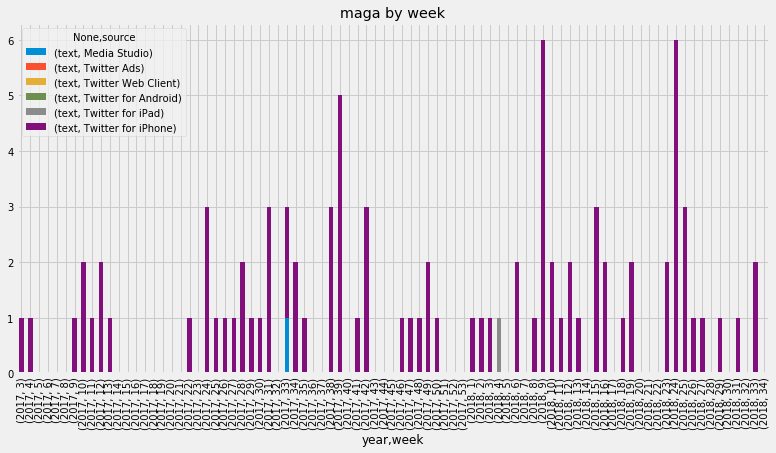

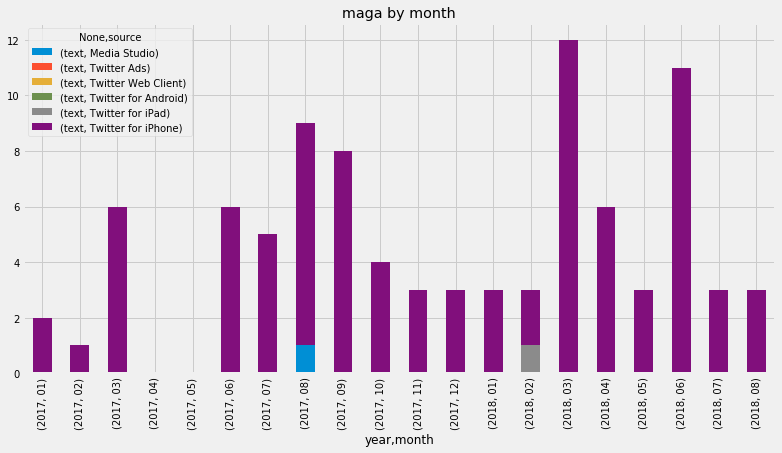

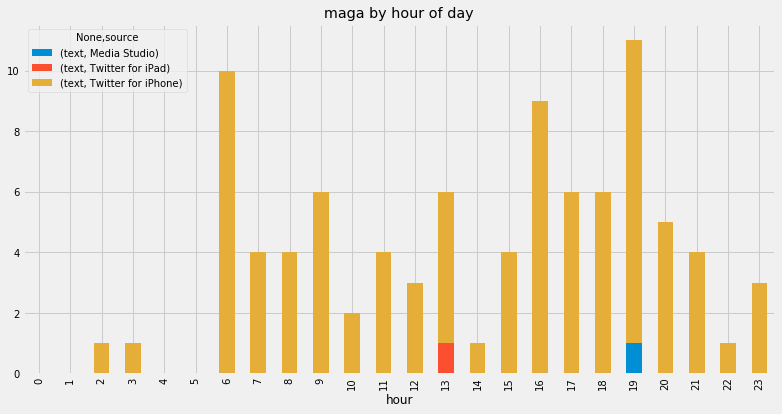

### The Tweets

[Tuesday, Aug 21, 2018 5:32 PM](https://twitter.com/realDonaldTrump/status/1032017630662729728): Just landed in West Virginia. Big crowd, looking forward to seeing everyone soon! #MAGA

[Monday, Aug 20, 2018 11:40 PM](https://twitter.com/realDonaldTrump/status/1031747927511916544): Will be going to the Great State of West Virginia on Tuesday Night to campaign &amp; do a Rally Speech for a hard working and spectacular person, A.G. Patrick Morrisey, who is running for the U.S. Senate. Patrick has great Energy &amp; Stamina-I need his VOTE to MAGA. Total Endorsement!

[Tuesday, Aug 7, 2018 6:46 AM](https://twitter.com/realDonaldTrump/status/1026781688167366656): Ohio, vote today for Troy Balderson for Congress. His opponent, controlled by Nancy Pelosi, is weak on Crime, the Border, Military, Vets, your 2nd Amendment - and will end your Tax Cuts. Troy will be a great Congressman. #MAGA

[Friday, Jul 27, 2018 9:53 PM](https://twitter.com/realDonaldTrump/status/1023023685681250304): Join me in Tampa, Florida next Tuesday, July 31st at 7:00pmE for a #MAGA Rally! Tickets: https://t.co/Q2PMyTACl8 https://t.co/URjvN8Owoe

[Friday, Jul 13, 2018 2:12 AM](https://twitter.com/realDonaldTrump/status/1017652952113311744): RT @MagaGoldHat: @RonDeSantisFL event July 18 th in Orlando with @DonaldJTrumpJr https://t.co/C5B5UwQZXa

[Thursday, Jul 5, 2018 8:11 PM](https://twitter.com/realDonaldTrump/status/1015025320657743872): It was my great honor to join proud, hardworking American Patriots in Montana tonight. I love you - thank you! #MAGA https://t.co/475ct7hW3D

[Wednesday, Jun 27, 2018 11:03 PM](https://twitter.com/realDonaldTrump/status/1012169482272460800): Thank you North Dakota. Together, we are MAKING AMERICA SAFE AND GREAT AGAIN! #MAGA https://t.co/6Am9n6px8I

[Monday, Jun 25, 2018 7:44 PM](https://twitter.com/realDonaldTrump/status/1011394762979586049): Just landed in South Carolina - will be at the McMaster rally shortly! #MAGA

[Monday, Jun 25, 2018 5:28 PM](https://twitter.com/realDonaldTrump/status/1011360410648416258): Surprised that Harley-Davidson, of all companies, would be the first to wave the White Flag. I fought hard for them and ultimately they will not pay tariffs selling into the E.U., which has hurt us badly on trade, down $151 Billion. Taxes just a Harley excuse - be patient!  #MAGA

[Saturday, Jun 23, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/1010619779600642048): Thank you @NVGOP! #MAGA https://t.co/OGTR2j6PGG

[Saturday, Jun 23, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/1010522945402224642): ...everyone how much he likes me, but he will only vote with Nancy Pelosi. Keith is strong on borders and tough on crime — and loves cutting taxes! #MAGA

[Thursday, Jun 21, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/1009796154220072960): Henry McMaster has done a great job as Governor of South Carolina. The state is BOOMING, with jobs and new industry setting records. He is tough on Crime and Strong on Borders, Healthcare, the Military and our great Vets. Henry has my full and complete Endrosement! #MAGA

[Thursday, Jun 21, 2018 8:47 AM](https://twitter.com/realDonaldTrump/status/1009779791858413569): Henry McMaster has done a great job as Governor of South Carolina. The State is BOOMING, with jobs and new industry setting records. He is tough on Crime and strong on Borders, Health Care, the Mititary and our great Vets. Henry has my full and complete Endorsement! #MAGA

[Wednesday, Jun 20, 2018 11:00 AM](https://twitter.com/realDonaldTrump/status/1009450868641497094): More records! #MAGA https://t.co/2CP5eq40Fy

[Tuesday, Jun 19, 2018 11:22 AM](https://twitter.com/realDonaldTrump/status/1009094070638084118): Join me tomorrow in Duluth, Minnesota for a #MAGA Rally! Tickets: https://t.co/mhhJB8WQlF https://t.co/gP59o1RDqW

[Tuesday, Jun 12, 2018 7:37 PM](https://twitter.com/realDonaldTrump/status/1006681862301933568): It's time for another #MAGA rally. Join me in Duluth, Minnesota on Wednesday, June 20th at 6:30pm!
Tickets➜https://t.co/mhhJB9erdd https://t.co/T6eXenoSxT

[Tuesday, Jun 12, 2018 4:12 PM](https://twitter.com/realDonaldTrump/status/1006630395067039744): Mark Sanford has been very unhelpful to me in my campaign to MAGA. He is MIA and nothing but trouble. He is better off in Argentina. I fully endorse Katie Arrington for Congress in SC, a state I love. She is tough on crime and will continue our fight to lower taxes. VOTE Katie!

[Wednesday, May 16, 2018 2:40 PM](https://twitter.com/realDonaldTrump/status/996822740320575488): ...and voted against the massive Tax Cut Bill. He’s also weak on borders and crime. Sadly, our great Military and Vets mean nothing to Bobby Jr. Lou Barletta will win! #MAGA

[Wednesday, May 16, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/996728397362540545): Congratulations to Deb Fischer. The people of Nebraska have seen what a great job she is doing - and it showed up at the ballot box! #MAGA

[Thursday, May 10, 2018 8:49 PM](https://twitter.com/realDonaldTrump/status/994741305908649985): Thank you Indiana! #MAGA🇺🇸
https://t.co/fCv76VyUax

[Saturday, Apr 28, 2018 6:45 PM](https://twitter.com/realDonaldTrump/status/990361469802905600): Join me LIVE in Washington, Michigan at 7:00pmE on @FoxNews! #MAGA

[Wednesday, Apr 25, 2018 5:18 PM](https://twitter.com/realDonaldTrump/status/989252420294336512): MAGA! https://t.co/jFf5ONASlv

[Saturday, Apr 21, 2018 9:18 AM](https://twitter.com/realDonaldTrump/status/987682105269391360): Join me in Washington, Michigan on Saturday, April 28, 2018 at 7:00pm! #MAGA Tickets: https://t.co/DISosdqBuu https://t.co/gHdTgHw5FU

[Monday, Apr 16, 2018 9:04 PM](https://twitter.com/realDonaldTrump/status/986047601047896064): RT @GOPChairwoman: Crumbs are still coming. #MAGA
https://t.co/JFZL6czboZ

[Monday, Apr 16, 2018 8:52 PM](https://twitter.com/realDonaldTrump/status/986044788163084288): RT @GOPChairwoman: We’re in a prime position to defend our majorities in 2018. Let’s defy history. #MAGA #LeadRight
https://t.co/fo8g0pSjWQ

[Thursday, Apr 5, 2018 4:28 PM](https://twitter.com/realDonaldTrump/status/981992052786425856): Thank you @WVGovernor Jim Justice. It was my great honor to be with the amazing people of West Virginia today! #MAGA https://t.co/IwPuQNadMM

[Monday, Mar 26, 2018 4:29 PM](https://twitter.com/realDonaldTrump/status/978368319542702080): Great news! #MAGA https://t.co/mRQGRJkozC

[Sunday, Mar 25, 2018 11:26 PM](https://twitter.com/realDonaldTrump/status/978110975428657153): .@HowieCarrShow just wrote a book which everyone is talking about. He was a great help. He is a veteran journalist who had a great influence in NH and beyond. He calls it the most amazing political campaign of modern times. The book is called, “What Really Happened.” Enjoy! #MAGA https://t.co/jYhjpoJKHe

[Thursday, Mar 22, 2018 4:11 PM](https://twitter.com/realDonaldTrump/status/976914287217258497): My honor Charlie - thank you! #MAGA https://t.co/ZbXFxNVMLP

[Thursday, Mar 15, 2018 7:11 AM](https://twitter.com/realDonaldTrump/status/974241711315709954): Larry Kudlow will be my Chief Economic Advisor as Director of the National Economic Council. Our Country will have many years of Great Economic &amp; Financial Success, with low taxes, unparalleled innovation, fair trade and an ever expanding labor force leading the way! #MAGA

[Wednesday, Mar 14, 2018 5:20 PM](https://twitter.com/realDonaldTrump/status/974032596563832832): Thank you for hosting! #MAGA https://t.co/9pHH60DVlX

[Saturday, Mar 10, 2018 6:56 PM](https://twitter.com/realDonaldTrump/status/972622325454659585): Join me LIVE in Moon Township, Pennsylvania at 7:00pmE. Great crowd for a #MAGA rally!
https://t.co/PYJNg0WGDL

[Friday, Mar 9, 2018 3:35 PM](https://twitter.com/realDonaldTrump/status/972209197935980544): Look forward to being in Pennsylvania tomorrow in support of Rick @Saccone4PA18. Big crowd expected in Moon Township. Vote Rick and see you there! #MAGA

[Friday, Mar 9, 2018 11:47 AM](https://twitter.com/realDonaldTrump/status/972151933782974464): JOBS, JOBS, JOBS! #MAGA https://t.co/YAaqRcA7ZS

[Thursday, Mar 8, 2018 1:58 PM](https://twitter.com/realDonaldTrump/status/971822550757138433): Great meeting with @Cabinet at the @WhiteHouse today! #MAGA https://t.co/InWj0QTosz

[Wednesday, Mar 7, 2018 6:40 AM](https://twitter.com/realDonaldTrump/status/971349864125788160): From Bush 1 to present, our Country has lost more than 55,000 factories, 6,000,000 manufacturing jobs and accumulated Trade Deficits of more than 12 Trillion Dollars. Last year we had a Trade Deficit of almost 800 Billion Dollars. Bad Policies &amp; Leadership. Must WIN again!  #MAGA

[Wednesday, Mar 7, 2018 6:24 AM](https://twitter.com/realDonaldTrump/status/971345895223676929): @MarkBurnettTV @RealRomaDowney From Bush 1 to present, our Country has lost more than 55,000 factories, 6,000,000 manufacturing jobs and accumulated Trade Deficits of more than 12 Trillion Dollars. Last year we had a Trade Deficit of almost 800 Billion Dollars. Bad policies &amp; leadership. Must win again!  #MAGA

[Thursday, Mar 1, 2018 1:06 PM](https://twitter.com/realDonaldTrump/status/969272683061022721): Unemployment filings are at their lowest level in over 48 years. Great news for workers and JOBS, JOBS, JOBS! #MAGA https://t.co/SzHTarzfrW

[Monday, Feb 12, 2018 3:48 PM](https://twitter.com/realDonaldTrump/status/963152799486828544): The journey to #MAGA began @CPAC 2011 and the opportunity to reconnect with friends and supporters is something I look forward to every year. See you at #CPAC2018!

[Sunday, Feb 11, 2018 1:21 PM](https://twitter.com/realDonaldTrump/status/962753552824365056): So many positive things going on for the U.S.A. and the Fake News Media just doesn’t want to go there. Same negative stories over and over again! No wonder the People no longer trust the media, whose approval ratings are correctly at their lowest levels in history!    #MAGA

[Friday, Feb 2, 2018 1:05 PM](https://twitter.com/realDonaldTrump/status/959488037766955009): With 3.5 million Americans receiving bonuses or other benefits from their employers as a result of TAX CUTS, 2018 is off to great start!
✅Unemployment rate at 4.1%.
✅Average earnings up 2.9% in the last year.
✅200,000 new American jobs.
✅#MAGA🇺🇸 https://t.co/upqSvBhRqJ

[Friday, Jan 26, 2018 12:12 PM](https://twitter.com/realDonaldTrump/status/956937916374138880): Heading back from a very exciting two days in Davos, Switzerland. Speech on America’s economic revival was well received. Many of the people I met will be investing in the U.S.A.! #MAGA

[Thursday, Jan 18, 2018 4:04 PM](https://twitter.com/realDonaldTrump/status/954097213608570880): AMERICA will once again be a NATION that thinks big, dreams bigger, and always reaches for the stars. YOU are the ones who will shape America’s destiny. YOU are the ones who will restore our prosperity. And YOU are the ones who are MAKING AMERICA GREAT AGAIN! #MAGA https://t.co/f2abNK47II

[Tuesday, Jan 9, 2018 10:48 PM](https://twitter.com/realDonaldTrump/status/950937350003183618): Thank you @GOPLeader Kevin McCarthy! Couldn’t agree w/you more. TOGETHER, we are #MAGA🇺🇸 https://t.co/QaxtqpyXTR

[Friday, Dec 15, 2017 7:00 PM](https://twitter.com/realDonaldTrump/status/941820213518938112): DOW, S&amp;P 500 and NASDAQ close at record highs! #MAGA https://t.co/hvqwnqSGuG

[Friday, Dec 8, 2017 8:04 PM](https://twitter.com/realDonaldTrump/status/939299624875118592): Just arrived at the Pensacola Bay Center. Join me LIVE on @FoxNews in 10 minutes! #MAGA https://t.co/RQFqOkcpNV

[Friday, Dec 8, 2017 6:25 PM](https://twitter.com/realDonaldTrump/status/939274666404909056): On my way to Pensacola, Florida. See everyone soon! #MAGA https://t.co/ijwxVSYQ52

[Thursday, Nov 30, 2017 4:50 PM](https://twitter.com/realDonaldTrump/status/936351772603568130): Our FIFTH 1K milestone of 2017!
#DOW24K #MAGA https://t.co/NoVt1uFp0y

[Friday, Nov 24, 2017 5:40 PM](https://twitter.com/realDonaldTrump/status/934189999045693441): Time Magazine called to say that I was PROBABLY going to be named “Man (Person) of the Year,” like last year, but I would have to agree to an interview and a major photo shoot. I said probably is no good and took a pass. Thanks anyway!

[Monday, Nov 13, 2017 7:33 AM](https://twitter.com/realDonaldTrump/status/930050967067820032): Will be leaving the Philippines tomorrow after many days of constant mtgs &amp; work in order to #MAGA! My promises are rapidly being fulfilled.

[Wednesday, Oct 18, 2017 7:31 PM](https://twitter.com/realDonaldTrump/status/920794597265088512): .@DanaPerino &amp; @BradThor,
Thank you so much for the wonderful compliment. Working hard! #MAGA https://t.co/AKWlsMsCVH

[Wednesday, Oct 18, 2017 6:49 PM](https://twitter.com/realDonaldTrump/status/920783976784171008): "20,000📈21,000📈22,000📈 23,000📈this year...FOUR one thousand milestones this year..." 
#Dow23K #MAGA https://t.co/GQ5f2eVvEI

[Tuesday, Oct 17, 2017 5:51 PM](https://twitter.com/realDonaldTrump/status/920406959320371200): So much Fake News being put in dying magazines and newspapers. Only place worse may be @NBCNews, @CBSNews, @ABC and @CNN. Fiction writers!

[Wednesday, Oct 11, 2017 6:26 AM](https://twitter.com/realDonaldTrump/status/918060313748164608): ...if Congress gives us the massive tax cuts (and reform) I am asking for, those numbers will grow by leaps and bounds. #MAGA

[Friday, Sep 29, 2017 9:24 PM](https://twitter.com/realDonaldTrump/status/913937483515269120): RT @LouDobbs: #AmericaFirst- @KellyannePolls: The Middle Class &amp; businesses will benefit from @POTUS' historic tax revolution. #Dobbs #MAGA…

[Wednesday, Sep 27, 2017 6:56 AM](https://twitter.com/realDonaldTrump/status/912994446219898880): Spoke to Roy Moore of Alabama last night for the first time. Sounds like a really great guy who ran a fantastic race. He will help to #MAGA!

[Tuesday, Sep 26, 2017 9:31 AM](https://twitter.com/realDonaldTrump/status/912670906828443648): ALABAMA, get out and vote for Luther Strange - he has proven to me that he will never let you down! #MAGA

[Monday, Sep 25, 2017 9:06 AM](https://twitter.com/realDonaldTrump/status/912302339360542720): RT @jayMAGA45: NFLplayer PatTillman joined U.S. Army in 2002. He was killed in action 2004. He fought 4our country/freedom. #StandForOurAnt…

[Sunday, Sep 24, 2017 3:12 PM](https://twitter.com/realDonaldTrump/status/912032094687252485): RT @DonnaWR8: @realDonaldTrump You can boycott our anthem 

WE CAN BOYCOTT YOU! 

#NFL #MAGA https://t.co/ryYzZnXjXE

[Friday, Sep 22, 2017 6:36 AM](https://twitter.com/realDonaldTrump/status/911177460959662080): RT @DonnaWR8: .@POTUS #TRUMP🇺🇸 &amp; @FLOTUS🌺

When ALL seemed HOPELESS...YOU brought HOPE!

You INSPIRE us ALL!

#MAGA #Harvey @Scavino45 #USA…

[Wednesday, Sep 20, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/910454124696752130): RT @DonnaWR8: @realDonaldTrump Thank you @POTUS for believing in Us like we believed in you! #MAGA https://t.co/C476SHWd0m

[Sunday, Sep 17, 2017 9:00 AM](https://twitter.com/realDonaldTrump/status/909401572341370881): Important meetings and calls scheduled for today. Military and economy are getting stronger by the day, and our enemies know it. #MAGA

[Wednesday, Aug 30, 2017 9:27 AM](https://twitter.com/realDonaldTrump/status/902885560552960000): After reading the false reporting and even ferocious anger in some dying magazines, it makes me wonder, WHY? All I want to do is #MAGA!

[Friday, Aug 25, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/901027651216969728): RT @EricTrump: Honored to speak at the RNC Summer Meeting in Nashville Tennessee this evening! @GOP #MAGA @GOPChairwoman 🇺🇸🇺🇸🇺🇸 https://t.c…

[Tuesday, Aug 22, 2017 4:03 PM](https://twitter.com/realDonaldTrump/status/900086092107571200): See you at 7:00 P.M. tonight Phoenix, Arizona! #MAGA🇺🇸
Tickets: https://t.co/2kUQfKqbsx https://t.co/1w3LVkpESE

[Friday, Aug 18, 2017 7:17 PM](https://twitter.com/realDonaldTrump/status/898685249726578688): Just returned to Bedminster, NJ from Camp David. GREAT meeting on National Security, the Border and the Military! #MAGA🇺🇸 https://t.co/Hjmcnnse9j

[Wednesday, Aug 16, 2017 3:49 PM](https://twitter.com/realDonaldTrump/status/897908198098706433): Just landed in Bedminster, New Jersey. #MAGA 🎥https://t.co/6EQfmRzrnv

[Monday, Aug 14, 2017 6:26 AM](https://twitter.com/realDonaldTrump/status/897041646659014657): Heading to Washington this morning. Much work to do. Focus on trade and military. #MAGA

[Friday, Aug 4, 2017 7:30 PM](https://twitter.com/realDonaldTrump/status/893615145053716480): RT @IvankaTrump: Since @realDonaldTrump inauguration, over 1 million net new jobs have been created in the American economy! #MAGA

[Thursday, Aug 3, 2017 6:52 PM](https://twitter.com/realDonaldTrump/status/893243147580473344): Just arrived in West Virginia for a MAKE AMERICA GREAT AGAIN rally in Huntington at 7:00pmE. Massive crowd expected - tune in! #MAGA🇺🇸

[Thursday, Aug 3, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/893080287755849729): RT @JacobAWohl: @realDonaldTrump The #MAGA great again movement is WINNING, and the left-wing media can't stand it!

[Saturday, Jul 29, 2017 7:15 PM](https://twitter.com/realDonaldTrump/status/891437168798965761): I love reading about all of the "geniuses" who were so instrumental in my election success. Problem is, most don't exist. #Fake News! MAGA

[Thursday, Jul 20, 2017 1:27 PM](https://twitter.com/realDonaldTrump/status/888088029428150272): Departing The Pentagon after meetings with @VP Pence, Secretary James Mattis, and our great teams. #MAGA🇺🇸 https://t.co/5d1MSzhjQS

[Wednesday, Jul 12, 2017 7:12 PM](https://twitter.com/realDonaldTrump/status/885275592681295872): JOBS, JOBS, JOBS! #MAGA🇺🇸 https://t.co/HScS4Y9ZJK

[Wednesday, Jul 12, 2017 7:06 PM](https://twitter.com/realDonaldTrump/status/885274148012011520): Stock market hits another high with spirit and enthusiasm so positive. Jobs outlook looking very good! #MAGA🇺🇸 https://t.co/Vwxsb2vWGe

[Friday, Jul 7, 2017 3:44 AM](https://twitter.com/realDonaldTrump/status/883230130885324802): I will represent our country well and fight for its interests! Fake News Media will never cover me accurately but who cares! We will #MAGA!

[Tuesday, Jun 27, 2017 7:32 AM](https://twitter.com/realDonaldTrump/status/879663665645056000): RT @ericbolling: Good morning friends!  "The Swamp" out today.  President Trump has a copy... get yours here https://t.co/TntLPNCCjR. #maga…

[Wednesday, Jun 21, 2017 7:04 PM](https://twitter.com/realDonaldTrump/status/877663648713330688): Just landed in Iowa. See everyone soon! #MAGA🇺🇸

[Friday, Jun 16, 2017 11:12 AM](https://twitter.com/realDonaldTrump/status/875732813278048256): Great news! #MAGA https://t.co/pirHR7lAyT

[Thursday, Jun 15, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/875321478849363968): You are witnessing the single greatest WITCH HUNT in American political history - led by some very bad and conflicted people!  #MAGA

[Tuesday, Jun 13, 2017 4:41 PM](https://twitter.com/realDonaldTrump/status/874728484475744257): Just arrived in Wisconsin to discuss JOBS, JOBS, JOBS! #MAGA🇺🇸 https://t.co/lEJ9S817yb

[Friday, Jun 2, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/870589692294647808): RT @HeyTammyBruce: Coming up at 720a ET on @foxandfriends! See you there! 🇺🇸 #maga

[Monday, Mar 27, 2017 9:35 PM](https://twitter.com/realDonaldTrump/status/846536212362018816): ...money to Bill, the Hillary Russian "reset," praise of Russia by Hillary, or Podesta Russian Company. Trump Russia story is a hoax. #MAGA!

[Tuesday, Mar 21, 2017 1:02 PM](https://twitter.com/realDonaldTrump/status/844232766711648256): Joined the @HouseGOP Conference this morning at the U.S. Capitol. https://t.co/03e4YBIWr0 #PassTheBill #MAGA🇺🇸… https://t.co/3swdFWGQtP

[Monday, Mar 20, 2017 7:03 PM](https://twitter.com/realDonaldTrump/status/843961248811225089): Thank you Louisville, Kentucky- on my way! #MAGA🇺🇸 https://t.co/3QsBsib6kt

[Friday, Mar 17, 2017 8:26 AM](https://twitter.com/realDonaldTrump/status/842713677174358016): RT @AmericaFirstPol: MAJOR IMPACT: @POTUS Trump is 50 Days in and moving swiftly to get America back on the right track. #MAGA 
https://t.c…

[Friday, Mar 10, 2017 10:40 AM](https://twitter.com/realDonaldTrump/status/840225958854561792): Weekly Address - 11:00 A.M. at the @WhiteHouse! #MAGA🇺🇸
➡️https://t.co/YSaPJnSX2i https://t.co/Gb8iTGzb6j

[Wednesday, Mar 8, 2017 6:54 PM](https://twitter.com/realDonaldTrump/status/839625347524096000): Great news. We are only just beginning. Together, we are going to #MAGA! https://t.co/BSp685Q9Qf https://t.co/K7yeBZsf6r

[Tuesday, Feb 28, 2017 8:42 PM](https://twitter.com/realDonaldTrump/status/836753422271582208): #JointSession #MAGA🇺🇸
https://t.co/RDO6Jt2pip

[Tuesday, Jan 24, 2017 12:04 PM](https://twitter.com/realDonaldTrump/status/823939422743830528): Great meeting with automobile industry leaders at the @WhiteHouse this morning. Together, we will #MAGA! https://t.co/OXdiLOkGsZ

[Friday, Jan 20, 2017 12:55 PM](https://twitter.com/realDonaldTrump/status/822502887477673984): We will follow two simple rules: BUY AMERICAN &amp; HIRE AMERICAN!
#InaugurationDay #MAGA🇺🇸

---

## Search: _make america great again_

Number of Tweets: 77

Percent of all Tweets: 1.69%

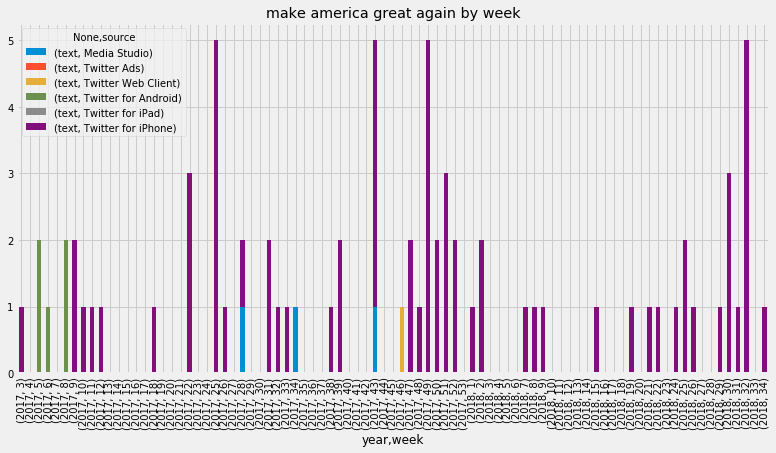

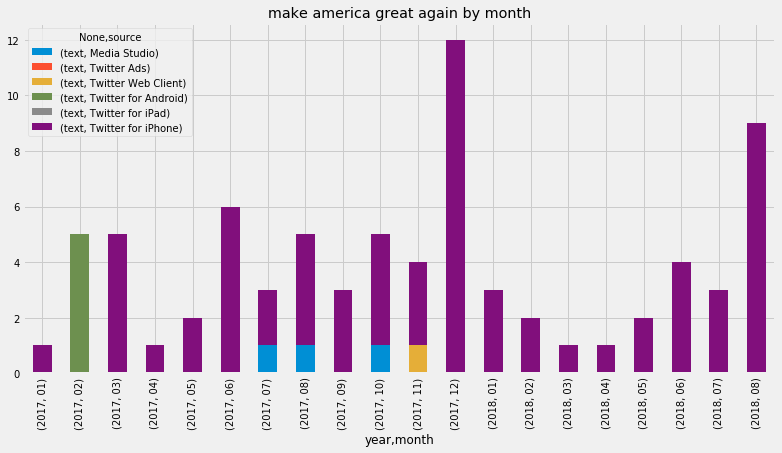

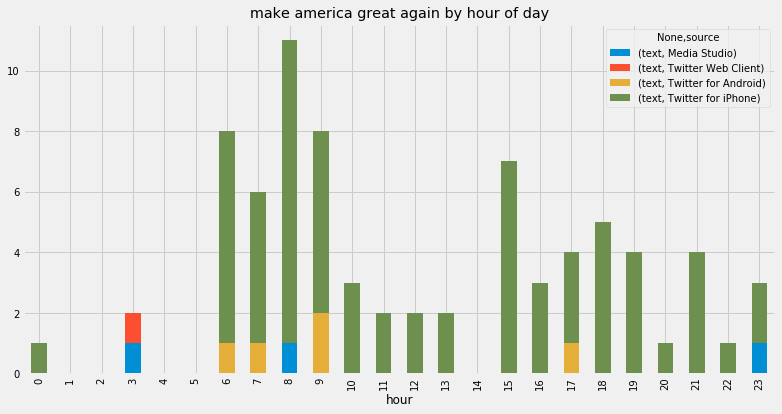

### The Tweets

[Wednesday, Aug 29, 2018 8:23 AM](https://twitter.com/realDonaldTrump/status/1034778515789545473): Big Election Wins last night! The Republican Party will MAKE AMERICA GREAT AGAIN! Actually, it is happening faster than anybody thought possible! It is morphing into KEEP AMERICA GREAT!

[Friday, Aug 17, 2018 3:25 PM](https://twitter.com/realDonaldTrump/status/1030536206415802369): Which is worse, Hightax Andrew Cuomo's statement, “WE’RE NOT GOING TO MAKE AMERICA GREAT AGAIN, IT WAS NEVER THAT GREAT” or Hillary Clinton’s “DEPLORABLES” statement...

[Friday, Aug 17, 2018 10:17 AM](https://twitter.com/realDonaldTrump/status/1030458489070596096): When a politician admits that “We’re not going to make America great again,” there doesn’t seem to be much reason to ever vote for him. This could be a career threatening statement by Andrew Cuomo, with many wanting him to resign-he will get higher ratings than his brother Chris!

[Friday, Aug 17, 2018 7:44 AM](https://twitter.com/realDonaldTrump/status/1030419975692005376): How does a politician, Cuomo, known for pushing people and businesses out of his state, not to mention having the highest taxes in the U.S., survive making the statement, WE’RE NOT GOING TO MAKE AMERICA GREAT AGAIN, IT WAS NEVER THAT GREAT? Which section of the sentence is worse?

[Wednesday, Aug 15, 2018 10:02 PM](https://twitter.com/realDonaldTrump/status/1029911186949767168): “WE’RE NOT GOING TO MAKE AMERICA GREAT AGAIN, IT WAS NEVER THAT GREAT.” Can you believe this is the Governor of the Highest Taxed State in the U.S., Andrew Cuomo, having a total meltdown!

[Wednesday, Aug 15, 2018 9:53 PM](https://twitter.com/realDonaldTrump/status/1029908960265027585): “WE’RE NOT GONG TO MAKE AMERICA GREAT AGAIN, IT WAS NEVER THAT GREAT.”  Can you believe this is the Governor of the Highest Taxed State in the U.S., Andrew Cuomo, having a total meltdown!

[Monday, Aug 6, 2018 3:13 PM](https://twitter.com/realDonaldTrump/status/1026546879289425920): John James is a potential Republican Star who has a Senate primary election tomorrow in Michigan. If he becomes the Republican candidate, he will beat the Open Borders, weak on Crime, Democrat, Debbie Stabenow. Vote for John James and Make America Great Again!

[Friday, Aug 3, 2018 9:06 PM](https://twitter.com/realDonaldTrump/status/1025548488178843648): Great photo from Ocean City, Maryland. Thank you. MAKE AMERICA GREAT AGAIN! https://t.co/kILZz31yDJ

[Wednesday, Aug 1, 2018 5:04 PM](https://twitter.com/realDonaldTrump/status/1024762772733796353): Join me tomorrow night at 7pmE in Wilkes-Barre Township, Pennsylvania for a MAKE AMERICA GREAT AGAIN RALLY! Tickets: https://t.co/dR6EzS3Q8L https://t.co/c52kIxvdF7

[Tuesday, Jul 31, 2018 6:23 AM](https://twitter.com/realDonaldTrump/status/1024239166429769729): ....them richer. Their network is highly overrated, I have beaten them at every turn. They want to protect their companies outside the U.S. from being taxed, I’m for America First &amp; the American Worker - a puppet for no one. Two nice guys with bad ideas. Make America Great Again!

[Tuesday, Jul 24, 2018 9:54 AM](https://twitter.com/realDonaldTrump/status/1021755459416543238): MAKE AMERICA GREAT AGAIN!

[Sunday, Jul 1, 2018 8:11 AM](https://twitter.com/realDonaldTrump/status/1013394559429169152): The Liberal Left, also known as the Democrats, want to get rid of ICE, who do a fantastic job, and want Open Borders. Crime would be rampant and uncontrollable! Make America Great Again

[Monday, Jun 25, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/1011295779422695424): Congresswoman Maxine Waters, an extraordinarily low IQ person, has become, together with Nancy Pelosi, the Face of the Democrat Party. She has just called for harm to supporters, of which there are many, of the Make America Great Again movement. Be careful what you wish for Max!

[Sunday, Jun 24, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1010902506422046721): ....Our Immigration policy, laughed at all over the world, is very unfair to all of those people who have gone through the system legally and are waiting on line for years! Immigration must be based on merit - we need people who will help to Make America Great Again!

[Friday, Jun 22, 2018 7:46 AM](https://twitter.com/realDonaldTrump/status/1010126805850902528): Congresswoman Martha Roby of Alabama has been a consistent and reliable vote for our Make America Great Again Agenda. She is in a Republican Primary run-off against a recent Nancy Pelosi voting Democrat. I fully endorse Martha for Alabama 2nd Congressional District!

[Tuesday, Jun 5, 2018 9:49 AM](https://twitter.com/realDonaldTrump/status/1003997350791188482): Senator @RogerWicker of Mississippi has done everything necessary to Make America Great Again! Get out and vote for Roger, he has my total support!

[Wednesday, May 30, 2018 7:46 PM](https://twitter.com/realDonaldTrump/status/1001973090107248641): There is no one better to represent the people of N.Y. and Staten Island (a place I know very well) than @RepDanDonovan, who is strong on Borders &amp; Crime, loves our Military &amp; our Vets, voted for Tax Cuts and is helping me to Make America Great Again. Dan has my full endorsement!

[Wednesday, May 16, 2018 8:07 AM](https://twitter.com/realDonaldTrump/status/996723907867676673): Congratulations to Lou Barletta of Pennsylvania. He will be a great Senator and will represent his people well - like they haven’t been represented in many years. Lou is a friend of mine and a special guy, he will very much help MAKE AMERICA GREAT AGAIN!

[Friday, Apr 20, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/987426984195174405): Can you believe that despite 93% bad stories from the Fake News Media (should be getting good stories), today we had just about our highest Poll Numbers, including those on Election Day? The American public is wise to the phony an dishonest press. Make America Great Again!

[Sunday, Mar 4, 2018 7:10 PM](https://twitter.com/realDonaldTrump/status/970451373681790978): We are on the losing side of almost all trade deals. Our friends and enemies have taken advantage of the U.S. for many years. Our Steel and Aluminum industries are dead. Sorry, it’s time for a change! MAKE AMERICA GREAT AGAIN!

[Tuesday, Feb 27, 2018 1:11 PM](https://twitter.com/realDonaldTrump/status/968549117625602054): I want to encourage all of my many Texas friends to vote in the primary for Governor Greg Abbott, Senator Ted Cruz, Lt. Gov. Dan Patrick, and Attorney General Ken Paxton. They are helping me to Make America Great Again! Vote early or on March 6th.

[Thursday, Feb 22, 2018 9:31 AM](https://twitter.com/realDonaldTrump/status/966681883206668289): What many people don’t understand, or don’t want to understand, is that Wayne, Chris and the folks who work so hard at the @NRA are Great People and Great American Patriots. They love our Country and will do the right thing.                  MAKE AMERICA GREAT AGAIN!

[Wednesday, Jan 17, 2018 6:32 PM](https://twitter.com/realDonaldTrump/status/953772162665590787): During the campaign, I promised to MAKE AMERICA GREAT AGAIN by bringing businesses and jobs back to our country. I am very proud to see companies like Chrysler moving operations from Mexico to Michigan where there are so many great American workers! https://t.co/hz2q9UTfnF

[Monday, Jan 15, 2018 8:02 AM](https://twitter.com/realDonaldTrump/status/952888691944550401): ...to stop drugs, they want to take money away from our military which we cannot do.” My standard is very simple, AMERICA FIRST &amp; MAKE AMERICA GREAT AGAIN!

[Friday, Jan 12, 2018 7:20 AM](https://twitter.com/realDonaldTrump/status/951790999784783872): ....Because of the Democrats not being interested in life and safety, DACA has now taken a big step backwards. The Dems will threaten “shutdown,” but what they are really doing is shutting down our military, at a time we need it most. Get smart, MAKE AMERICA GREAT AGAIN!

[Monday, Dec 25, 2017 6:33 PM](https://twitter.com/realDonaldTrump/status/945437479863291904): I hope everyone is having a great Christmas, then tomorrow it’s back to work in order to Make America Great Again (which is happening faster than anyone anticipated)!

[Sunday, Dec 24, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/944927689638662145): The Fake News refuses to talk about how Big and how Strong our BASE is. They show Fake Polls just like they report Fake News. Despite only negative reporting, we are doing well - nobody is going to beat us. MAKE AMERICA GREAT AGAIN!

[Thursday, Dec 21, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/943842608631238656): Home Sales hit BEST numbers in 10 years! MAKE AMERICA GREAT AGAIN

[Tuesday, Dec 19, 2017 6:04 AM](https://twitter.com/realDonaldTrump/status/943074475209355264): DOW RISES 5000 POINTS ON THE YEAR FOR THE FIRST TIME EVER - MAKE AMERICA GREAT AGAIN!

[Monday, Dec 18, 2017 3:28 PM](https://twitter.com/realDonaldTrump/status/942854056162332677): When the American People speak, ALL OF US should listen. Just over one year ago, you spoke loud and clear. On November 8, 2016, you voted to MAKE AMERICA GREAT AGAIN! https://t.co/3AOv53S0PU

[Thursday, Dec 14, 2017 3:35 PM](https://twitter.com/realDonaldTrump/status/941406242785955841): In 1960, there were approximately 20,000 pages in the Code of Federal Regulations. Today there are over 185,000 pages, as seen in the Roosevelt Room.

Today, we CUT THE RED TAPE! It is time to SET FREE OUR DREAMS and MAKE AMERICA GREAT AGAIN! https://t.co/teAVNzjvcx

[Tuesday, Dec 12, 2017 9:23 AM](https://twitter.com/realDonaldTrump/status/940588025964265472): Consumer Confidence is at an All-Time High, along with a Record High Stock Market. Unemployment is at a 17 year low. MAKE AMERICA GREAT AGAIN! Working to pass MASSIVE TAX CUTS (looking good).

[Saturday, Dec 9, 2017 7:52 AM](https://twitter.com/realDonaldTrump/status/939477807813595136): A big contingent of very enthusiastic Roy Moore fans at the rally last night. We can’t have a Pelosi/Schumer Liberal Democrat, Jones, in that important Alabama Senate seat. Need your vote to Make America Great Again! Jones will always vote against what we must do for our Country.

[Friday, Dec 8, 2017 12:46 PM](https://twitter.com/realDonaldTrump/status/939189419386470401): MAKE AMERICA GREAT AGAIN! https://t.co/64a93S07s7

[Friday, Dec 8, 2017 10:06 AM](https://twitter.com/realDonaldTrump/status/939149296389251072): LAST thing the Make America Great Again Agenda needs is a Liberal Democrat in Senate where we have so little margin for victory already. The Pelosi/Schumer Puppet Jones would vote against us 100% of the time. He’s bad on Crime, Life, Border, Vets, Guns &amp; Military. VOTE ROY MOORE!

[Friday, Dec 8, 2017 8:11 AM](https://twitter.com/realDonaldTrump/status/939120304542101505): Big crowd expected today in Pensacola, Florida, for a Make America Great Again speech. We have done so much in so short a period of time...and yet are planning to do so much more! See you there!

[Wednesday, Dec 6, 2017 10:00 AM](https://twitter.com/realDonaldTrump/status/938422792080457731): MAKE AMERICA GREAT AGAIN!

[Sunday, Nov 26, 2017 4:29 PM](https://twitter.com/realDonaldTrump/status/934896989539586054): Since the first day I took office, all you hear is the phony Democrat excuse for losing the election, Russia, Russia,Russia.  Despite this I have the economy booming and have possibly done more than any 10 month President. MAKE AMERICA GREAT AGAIN!

[Thursday, Nov 23, 2017 6:44 AM](https://twitter.com/realDonaldTrump/status/933662564587855877): MAKE AMERICA GREAT AGAIN!

[Thursday, Nov 23, 2017 6:31 AM](https://twitter.com/realDonaldTrump/status/933659179348299776): @ThePlumLineGS MAKE AMERICA GREAT AGAIN!

[Tuesday, Nov 14, 2017 3:07 AM](https://twitter.com/realDonaldTrump/status/930346433177378817): One of the most accurate polls last time around. But #FakeNews likes to say we’re in the 30’s. They are wrong. Some people think numbers could be in the 50's. Together, WE will MAKE AMERICA GREAT AGAIN! https://t.co/YhrwkdObhP

[Friday, Oct 27, 2017 8:50 AM](https://twitter.com/realDonaldTrump/status/923894747793580033): Happy birthday to the great @TheLeeGreenwood. You and your beautiful song have made such a difference. MAKE AMERICA GREAT AGAIN!

[Friday, Oct 27, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/923873579539861506): Happy birthday to the great @leegreenwood83. You and your beautiful song have made such a difference. MAKE AMERICA GREAT AGAIN!

[Friday, Oct 27, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/923866515358789633): Wacky &amp; totally unhinged Tom Steyer, who has been fighting me and my Make America Great Again agenda from beginning, never wins elections!

[Wednesday, Oct 25, 2017 11:33 PM](https://twitter.com/realDonaldTrump/status/923392161634275328): Together, we will Make America Great Again!
#AmericaFirst🇺🇸 https://t.co/ajiC3flNkI

[Wednesday, Oct 25, 2017 11:40 AM](https://twitter.com/realDonaldTrump/status/923212567232774145): MAKE AMERICA GREAT AGAIN! https://t.co/CbEwJSQ1A3

[Wednesday, Sep 27, 2017 3:07 PM](https://twitter.com/realDonaldTrump/status/913117797231857664): Just arrived in Indianapolis, Indiana to make an announcement on #TaxReform! Together, we are going to MAKE AMERICA GREAT AGAIN! https://t.co/Dy9UwhkWHL

[Sunday, Sep 24, 2017 3:32 PM](https://twitter.com/realDonaldTrump/status/912037003923005440): Courageous Patriots have fought and died for our great American Flag --- we MUST honor and respect it!  MAKE AMERICA GREAT AGAIN!

[Wednesday, Sep 20, 2017 6:14 AM](https://twitter.com/realDonaldTrump/status/910447064944955392): Big meetings today at the United Nations. So many interesting leaders. America First will MAKE AMERICA GREAT AGAIN!

[Wednesday, Aug 23, 2017 3:01 AM](https://twitter.com/realDonaldTrump/status/900251514324647936): MAKE AMERICA GREAT AGAIN! https://t.co/RzePiucV3h

[Wednesday, Aug 16, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/897799882802704385): MAKE AMERICA GREAT AGAIN!

[Sunday, Aug 6, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/894185208924262401): MAKE AMERICA GREAT AGAIN! https://t.co/g4ELhh9joH

[Friday, Aug 4, 2017 12:19 AM](https://twitter.com/realDonaldTrump/status/893325503020642305): Thank you West Virginia! All across the country, Americans of every kind are coming together w/one simple goal: to MAKE AMERICA GREAT AGAIN! https://t.co/thRh7htVbH

[Thursday, Aug 3, 2017 6:52 PM](https://twitter.com/realDonaldTrump/status/893243147580473344): Just arrived in West Virginia for a MAKE AMERICA GREAT AGAIN rally in Huntington at 7:00pmE. Massive crowd expected - tune in! #MAGA🇺🇸

[Saturday, Jul 15, 2017 4:19 PM](https://twitter.com/realDonaldTrump/status/886319322154586112): MAKE AMERICA GREAT AGAIN! https://t.co/3eYF3nir4B

[Sunday, Jul 9, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/884033889613828096): MAKE AMERICA GREAT AGAIN! https://t.co/NVDVRrWLs4

[Saturday, Jul 1, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/881281755017355264): My use of social media is not Presidential - it’s MODERN DAY PRESIDENTIAL. Make America Great Again!

[Saturday, Jun 24, 2017 5:23 PM](https://twitter.com/realDonaldTrump/status/878725385235701761): MAKE AMERICA GREAT AGAIN!

[Thursday, Jun 22, 2017 7:12 PM](https://twitter.com/realDonaldTrump/status/878027873650475008): Together, we are going to MAKE AMERICA GREAT AGAIN!
#AmericaFirst🇺🇸 https://t.co/MVJbs44AtR

[Wednesday, Jun 21, 2017 7:48 PM](https://twitter.com/realDonaldTrump/status/877674738364989440): Thank you Kirkwood Community College. Heading to the U.S. Cellular Center now for an 8pmE MAKE AMERICA GREAT AGAIN… https://t.co/n6LS32a6Zn

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Sunday, Jun 18, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/876388733607694336): The MAKE AMERICA GREAT AGAIN agenda is doing very well despite the distraction of the Witch Hunt. Many new jobs, high business enthusiasm,..

[Thursday, Jun 1, 2017 9:00 PM](https://twitter.com/realDonaldTrump/status/870445001125355522): MAKE AMERICA GREAT AGAIN!

[Wednesday, May 31, 2017 9:05 PM](https://twitter.com/realDonaldTrump/status/870083798981111808): I will be announcing my decision on Paris Accord, Thursday at 3:00 P.M.  The White House Rose Garden.  MAKE AMERICA GREAT AGAIN!

[Wednesday, May 31, 2017 9:08 AM](https://twitter.com/realDonaldTrump/status/869903459511918592): I will be announcing my decision on the Paris Accord over the next few days. MAKE AMERICA GREAT AGAIN!

[Sunday, Apr 30, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/858653541094879232): Big excitement last night in the Great State of Pennsylvania! Fantastic crowd and people. MAKE AMERICA GREAT AGAIN!

[Saturday, Mar 25, 2017 6:37 PM](https://twitter.com/realDonaldTrump/status/845766504608120833): Thanks you for all of the Trump Rallies today. Amazing support. We will all MAKE AMERICA GREAT AGAIN!

[Wednesday, Mar 15, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/842164356297175040): In Nashville, Tennessee! Lets MAKE AMERICA GREAT AGAIN! https://t.co/m5UR4vv6UH

[Sunday, Mar 5, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/838441522546769923): Thank you for the great rallies all across the country. Tremendous support. Make America Great Again!

[Friday, Mar 3, 2017 5:13 PM](https://twitter.com/realDonaldTrump/status/837787963027144706): MAKE AMERICA GREAT AGAIN! https://t.co/kuQiZDz4rA

[Friday, Mar 3, 2017 3:48 PM](https://twitter.com/realDonaldTrump/status/837766616603586560): We must fix our education system for our kids to Make America Great Again. Wonderful day at Saint Andrew in Orlando. https://t.co/OTJaHcvLzf

[Saturday, Feb 25, 2017 7:25 AM](https://twitter.com/realDonaldTrump/status/835465719970217984): Maybe the millions of people who voted to MAKE AMERICA GREAT AGAIN should have their own rally. It would be the biggest of them all!

[Monday, Feb 20, 2017 9:33 AM](https://twitter.com/realDonaldTrump/status/833686030679207936): HAPPY PRESIDENTS DAY - MAKE AMERICA GREAT AGAIN!

[Sunday, Feb 5, 2017 5:49 PM](https://twitter.com/realDonaldTrump/status/828375073006444544): Enjoy the #SuperBowl and then we continue: MAKE AMERICA GREAT AGAIN!

[Saturday, Feb 4, 2017 9:26 AM](https://twitter.com/realDonaldTrump/status/827885966509604865): MAKE AMERICA GREAT AGAIN!

[Friday, Feb 3, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/827483841589891073): Professional anarchists, thugs and paid protesters are proving the point of the millions of people who voted to MAKE AMERICA GREAT AGAIN!

[Friday, Jan 20, 2017 11:56 PM](https://twitter.com/realDonaldTrump/status/822669114237943808): THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4

---

## Search: _fake news_

Number of Tweets: 269

Percent of all Tweets: 5.89%

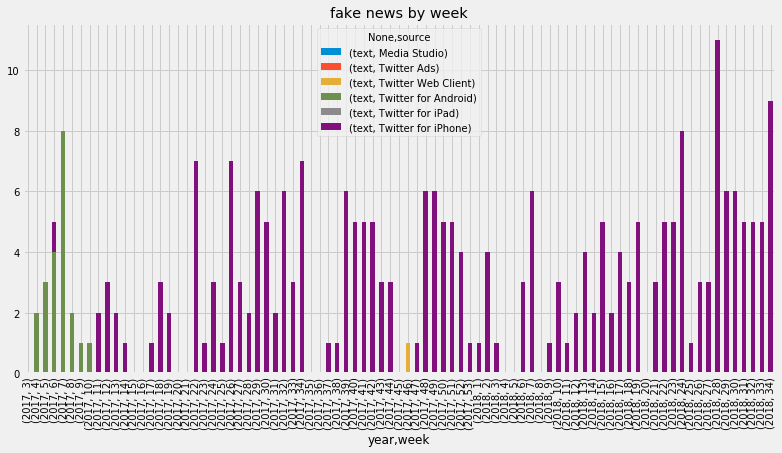

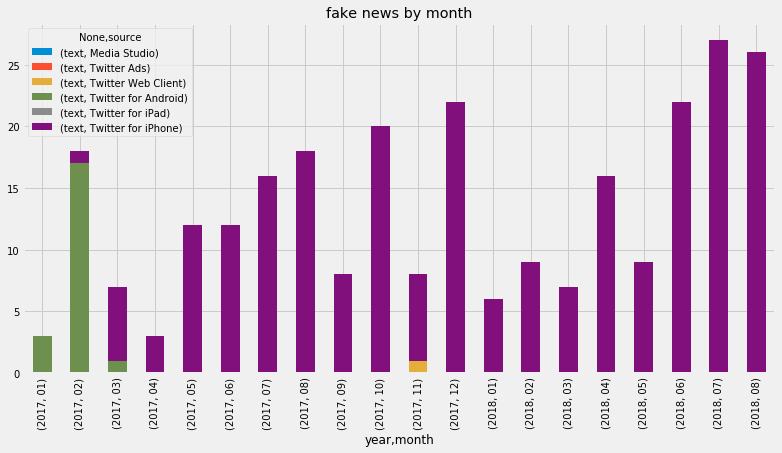

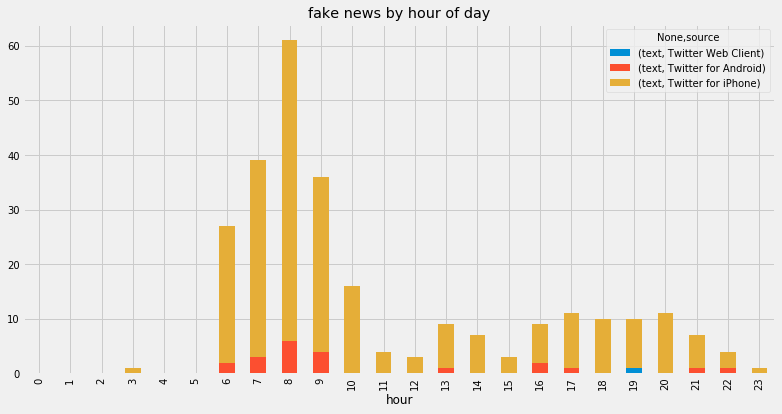

### The Tweets

[Thursday, Aug 30, 2018 9:39 AM](https://twitter.com/realDonaldTrump/status/1035159956507566080): I am very excited about the person who will be taking the place of Don McGahn as White House Counsel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Thursday, Aug 30, 2018 8:12 AM](https://twitter.com/realDonaldTrump/status/1035138155794575360): I am very excited about the person who will be taking the place of Don McGahn as White House Councel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Thursday, Aug 30, 2018 7:44 AM](https://twitter.com/realDonaldTrump/status/1035131133997068288): Ivanka Trump &amp; Jared Kushner had NOTHING to do with the so called “pushing out” of Don McGahn.The Fake News Media has it, purposely,so wrong! They love to portray chaos in the White House when they know that chaos doesn’t exist-just a “smooth running machine” with changing parts!

[Wednesday, Aug 29, 2018 8:44 PM](https://twitter.com/realDonaldTrump/status/1034965029676883970): “Lanny Davis admits being anonymous source in CNN Report.” @BretBaier  Oh well, so much for CNN saying it wasn’t Lanny. No wonder their ratings are so low, it’s FAKE NEWS!

[Wednesday, Aug 29, 2018 6:43 PM](https://twitter.com/realDonaldTrump/status/1034934675972792320): CNN is being torn apart from within based on their being caught in a major lie and refusing to admit the mistake. Sloppy @carlbernstein, a man who lives in the past and thinks like a degenerate fool, making up story after story, is being laughed at all over the country! Fake News

[Wednesday, Aug 29, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1034782741714399232): “Anonymous Sources are really starting to BURN the media.” @FoxNews The fact is that many anonymous sources don’t even exist. They are fiction made up by the Fake News reporters. Look at the lie that Fake CNN is now in. They got caught red handed! Enemy of the People!

[Tuesday, Aug 28, 2018 11:02 AM](https://twitter.com/realDonaldTrump/status/1034456273306243076): Google search results for “Trump News” shows only the viewing/reporting of Fake News Media. In other words, they have it RIGGED, for me &amp; others, so that almost all stories &amp; news is BAD. Fake CNN is prominent. Republican/Conservative &amp; Fair Media is shut out. Illegal? 96% of....

[Monday, Aug 27, 2018 9:37 AM](https://twitter.com/realDonaldTrump/status/1034072454086447104): The Fake News Media worked hard to get Tiger Woods to say something that he didn’t want to say. Tiger wouldn’t play the game - he is very smart. More importantly, he is playing great golf again!

[Sunday, Aug 26, 2018 8:39 PM](https://twitter.com/realDonaldTrump/status/1033876658439245825): Over 90% approval rating for your all time favorite (I hope) President within the Republican Party and 52% overall. This despite all of the made up stories by the Fake News Media trying endlessly to make me look as bad and evil as possible. Look at the real villains please!

[Saturday, Aug 25, 2018 8:16 AM](https://twitter.com/realDonaldTrump/status/1033327353227882496): Michaels Cohen’s attorney clarified the record, saying his client does not know if President Trump knew about the Trump Tower meeting (out of which came nothing!). The answer is that I did NOT know about the meeting. Just another phony story by the Fake News Media!

[Friday, Aug 24, 2018 7:34 AM](https://twitter.com/realDonaldTrump/status/1032954224529817600): Social Media Giants are silencing millions of people. Can’t do this even if it means we must continue to hear Fake News like CNN, whose ratings have suffered gravely. People have to figure out what is real, and what is not, without censorship!

[Tuesday, Aug 21, 2018 7:10 AM](https://twitter.com/realDonaldTrump/status/1031861173149413376): Fake News, of which there is soooo much (this time the very tired New Yorker) falsely reported that I was going to take the extraordinary step of denying Intelligence Briefings to President Obama. Never discussed or thought of!

[Sunday, Aug 19, 2018 8:14 AM](https://twitter.com/realDonaldTrump/status/1031152483949838336): Some members of the media are very Angry at the Fake Story in the New York Times. They actually called to complain and apologize - a big step forward. From the day I announced, the Times has been Fake News, and with their disgusting new Board Member, it will only get worse!

[Sunday, Aug 19, 2018 8:06 AM](https://twitter.com/realDonaldTrump/status/1031150465759633408): The Failing New York Times wrote a story that made it seem like the White House Councel had TURNED on the President, when in fact it is just the opposite - &amp; the two Fake reporters knew this. This is why the Fake News Media has become the Enemy of the People. So bad for America!

[Saturday, Aug 18, 2018 7:32 AM](https://twitter.com/realDonaldTrump/status/1030779412973846529): .....Censorship is a very dangerous thing &amp; absolutely impossible to police. If you are weeding out Fake News, there is nothing so Fake as CNN &amp; MSNBC, &amp; yet I do not ask that their sick behavior be removed. I get used to it and watch with a grain of salt, or don’t watch at all..

[Thursday, Aug 16, 2018 10:10 AM](https://twitter.com/realDonaldTrump/status/1030094399362007040): There is nothing that I would want more for our Country than true FREEDOM OF THE PRESS. The fact is that the Press is FREE to write and say anything it wants, but much of what it says is FAKE NEWS, pushing a political agenda or just plain trying to hurt people. HONESTY WINS!

[Thursday, Aug 16, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/1030074380397752320): THE FAKE NEWS MEDIA IS THE OPPOSITION PARTY. It is very bad for our Great Country....BUT WE ARE WINNING!

[Monday, Aug 13, 2018 9:57 PM](https://twitter.com/realDonaldTrump/status/1029185314752000007): ....such wonderful and powerful things about me - a true Champion of Civil Rights - until she got fired. Omarosa had Zero credibility with the Media (they didn’t want interviews) when she worked in the White House. Now that she says bad about me, they will talk to her. Fake News!

[Monday, Aug 13, 2018 10:21 AM](https://twitter.com/realDonaldTrump/status/1029010124881453056): While I know it’s “not presidential” to take on a lowlife like Omarosa, and while I would rather not be doing so, this is a modern day form of communication and I know the Fake News Media will be working overtime to make even Wacky Omarosa look legitimate as possible. Sorry!

[Saturday, Aug 11, 2018 2:28 PM](https://twitter.com/realDonaldTrump/status/1028347518822825984): The big story that the Fake News Media refuses to report is lowlife Christopher Steele’s many meetings with Deputy A.G. Bruce Ohr and his beautiful wife, Nelly. It was Fusion GPS that hired Steele to write the phony &amp; discredited Dossier, paid for by Crooked Hillary &amp; the DNC....

[Wednesday, Aug 8, 2018 11:14 AM](https://twitter.com/realDonaldTrump/status/1027211440225243137): The Republicans have now won 8 out of 9 House Seats, yet if you listen to the Fake News Media you would think we are being clobbered. Why can’t they play it straight, so unfair to the Republican Party and in particular, your favorite President!

[Sunday, Aug 5, 2018 8:49 AM](https://twitter.com/realDonaldTrump/status/1026087766071947265): Too bad a large portion of the Media refuses to report the lies and corruption having to do with the Rigged Witch Hunt - but that is why we call them FAKE NEWS!

[Sunday, Aug 5, 2018 8:35 AM](https://twitter.com/realDonaldTrump/status/1026084333315153924): Fake News reporting, a complete fabrication, that I am concerned about the meeting my wonderful son, Donald, had in Trump Tower. This was a meeting to get information on an opponent, totally legal and done all the time in politics - and it went nowhere. I did not know about it!

[Sunday, Aug 5, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1026069857589227520): The Fake News hates me saying that they are the Enemy of the People only because they know it’s TRUE. I am providing a great service by explaining this to the American People. They purposely cause great division &amp; distrust. They can also cause War! They are very dangerous &amp; sick!

[Thursday, Aug 2, 2018 4:24 PM](https://twitter.com/realDonaldTrump/status/1025115155632455680): They asked my daughter Ivanka whether or not the media is the enemy of the people. She correctly said no. It is the FAKE NEWS, which is a large percentage of the media, that is the enemy of the people!

[Thursday, Aug 2, 2018 7:04 AM](https://twitter.com/realDonaldTrump/status/1024974107337781248): Wow, @foxandfriends is blowing away the competition in the morning ratings. Morning Joe is a dead show with very few people watching and sadly, Fake News CNN is also doing poorly. Too much hate and inaccurately reported stories - too predictable!

[Tuesday, Jul 31, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/1024287257975566338): The Fake News Media is going CRAZY! They are totally unhinged and in many ways, after witnessing first hand the damage they do to so many innocent and decent people, I enjoy watching. In 7 years, when I am no longer in office, their ratings will dry up and they will be gone!

[Sunday, Jul 29, 2018 8:30 AM](https://twitter.com/realDonaldTrump/status/1023546197129224192): Had a very good and interesting meeting at the White House with A.G. Sulzberger, Publisher of the New York Times. Spent much time talking about the vast amounts of Fake News being put out by the media &amp; how that Fake News has morphed into phrase, “Enemy of the People.” Sad!

[Sunday, Jul 29, 2018 7:59 AM](https://twitter.com/realDonaldTrump/status/1023538486081662976): RT @realDonaldTrump: Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almos…

[Sunday, Jul 29, 2018 7:52 AM](https://twitter.com/realDonaldTrump/status/1023536822901776384): Do you think the Fake News Media will ever report on this tweet from Michael? https://t.co/kXLCKZO5Fr

[Friday, Jul 27, 2018 6:45 PM](https://twitter.com/realDonaldTrump/status/1022976410745495552): Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almost totally on their side!

[Friday, Jul 27, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1022808452677160960): ....,the only Collusion with Russia was with the Democrats, so now they are looking at my Tweets (along with 53 million other people) - the rigged Witch Hunt continues! How stupid and unfair to our Country....And so the Fake News doesn’t waste my time with dumb questions, NO,....

[Tuesday, Jul 24, 2018 8:39 PM](https://twitter.com/realDonaldTrump/status/1021917767467982854): So sad and unfair that the FCC wouldn’t approve the Sinclair Broadcast merger with Tribune. This would have been a great and much needed Conservative voice for and of the People. Liberal Fake News NBC and Comcast gets approved, much bigger, but not Sinclair. Disgraceful!

[Monday, Jul 23, 2018 9:06 AM](https://twitter.com/realDonaldTrump/status/1021380986452545537): A Rocket has not been launched by North Korea in 9 months. Likewise, no Nuclear Tests. Japan is happy, all of Asia is happy. But the Fake News is saying, without ever asking me (always anonymous sources), that I am angry because it is not going fast enough. Wrong, very happy!

[Monday, Jul 23, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/1021370601863294977): When you hear the Fake News talking negatively about my meeting with President Putin, and all that I gave up, remember, I gave up NOTHING, we merely talked about future benefits for both countries. Also, we got along very well, which is a good thing, except for the Corrupt Media!

[Sunday, Jul 22, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1021020863733420032): I had a GREAT meeting with Putin and the Fake News used every bit of their energy to try and disparage it. So bad for our country!

[Friday, Jul 20, 2018 5:50 PM](https://twitter.com/realDonaldTrump/status/1020425741664751616): I got severely criticized by the Fake News Media for being too nice to President Putin. In the Old Days they would call it Diplomacy. If I was loud &amp; vicious, I would have been criticized for being too tough. Remember when they said I was too tough with Chairman Kim? Hypocrites!

[Friday, Jul 20, 2018 10:39 AM](https://twitter.com/realDonaldTrump/status/1020317159828992000): RT @realDonaldTrump: The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forw…

[Friday, Jul 20, 2018 10:35 AM](https://twitter.com/realDonaldTrump/status/1020316392548196354): RT @realDonaldTrump: Will the Dems and Fake News ever learn? This is classic! https://t.co/kSX3ROI4QG

[Thursday, Jul 19, 2018 2:14 PM](https://twitter.com/realDonaldTrump/status/1020008975922810883): Will the Dems and Fake News ever learn? This is classic! https://t.co/kSX3ROI4QG

[Thursday, Jul 19, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1019936133147516929): The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........

[Thursday, Jul 19, 2018 7:13 AM](https://twitter.com/realDonaldTrump/status/1019903123312308224): “Trump recognized Russian Meddling MANY TIMES.” Thank you to @foxandfriends and @FoxNews for actually showing the clips. The Fake News wants no part of that narrative! Too bad they don’t want to focus on all of the ECONOMIC and JOBS records being set.

[Thursday, Jul 19, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1019899507910283264): The Fake News Media wants so badly to see a major confrontation with Russia, even a confrontation that could lead to war. They are pushing so recklessly hard and hate the fact that I’ll probably have a good relationship with Putin. We are doing MUCH better than any other country!

[Thursday, Jul 19, 2018 6:37 AM](https://twitter.com/realDonaldTrump/status/1019894101116948480): The Fake News Media is going Crazy! They make up stories without any backup, sources or proof. Many of the stories written about me, and the good people surrounding me, are total fiction. Problem is, when you complain you just give them more publicity. But I’ll complain anyway!

[Tuesday, Jul 17, 2018 8:21 PM](https://twitter.com/realDonaldTrump/status/1019376680572456960): The meeting between President Putin and myself was a great success, except in the Fake News Media!

[Tuesday, Jul 17, 2018 10:22 AM](https://twitter.com/realDonaldTrump/status/1019225830298456066): While I had a great meeting with NATO, raising vast amounts of money, I had an even better meeting with Vladimir Putin of Russia. Sadly, it is not being reported that way - the Fake News is going Crazy!

[Sunday, Jul 15, 2018 12:11 PM](https://twitter.com/realDonaldTrump/status/1018528420093878272): There hasn’t been a missile or rocket fired in 9 months in North Korea, there have been no nuclear tests and we got back our hostages. Who knows how it will all turn out in the end, but why isn’t the Fake News talking about these wonderful facts? Because it is FAKE NEWS!

[Saturday, Jul 14, 2018 2:17 PM](https://twitter.com/realDonaldTrump/status/1018197842559725569): These Russian individuals did their work during the Obama years. Why didn’t Obama do something about it?  Because he thought Crooked Hillary Clinton would win, that’s why. Had nothing to do with the Trump Administration, but Fake News doesn’t want to report the truth, as usual!

[Saturday, Jul 14, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/1018093807060045824): So funny! I just checked out Fake News CNN, for the first time in a long time (they are dying in the ratings), to see if they covered my takedown yesterday of Jim Acosta (actually a nice guy). They didn’t! But they did say I already lost in my meeting with Putin. Fake News......

[Monday, Jul 9, 2018 1:04 PM](https://twitter.com/realDonaldTrump/status/1016367395294908421): The failing NY Times Fake News story today about breast feeding must be called out. The U.S. strongly supports breast feeding but we don’t believe women should be denied access to formula. Many women need this option because of malnutrition and poverty.

[Tuesday, Jul 3, 2018 7:13 PM](https://twitter.com/realDonaldTrump/status/1014286054805987330): After having written many best selling books, and somewhat priding myself on my ability to write, it should be noted that the Fake News constantly likes to pore over my tweets looking for a mistake. I capitalize certain words only for emphasis, not b/c they should be capitalized!

[Tuesday, Jul 3, 2018 5:19 PM](https://twitter.com/realDonaldTrump/status/1014257237945176071): After having written many best selling books, and somewhat priding myself on my ability to write, it should be noted that the Fake News constantly likes to pour over my tweets looking for a mistake. I capitalize certain words only for emphasis, not b/c they should be capitalized!

[Tuesday, Jul 3, 2018 7:16 AM](https://twitter.com/realDonaldTrump/status/1014105549624037377): Many good conversations with North Korea-it is going well! In the meantime, no Rocket Launches or Nuclear Testing in 8 months. All of Asia is thrilled. Only the Opposition Party, which includes the Fake News, is complaining. If not for me, we would now be at War with North Korea!

[Monday, Jun 25, 2018 8:36 AM](https://twitter.com/realDonaldTrump/status/1011226622324887556): Such a difference in the media coverage of the same immigration policies between the Obama Administration and ours. Actually, we have done a far better job in that our facilities are cleaner and better run than were the facilities under Obama. Fake News is working overtime!

[Thursday, Jun 21, 2018 5:51 PM](https://twitter.com/realDonaldTrump/status/1009916650622251009): “I REALLY DON’T CARE, DO U?” written on the back of Melania’s jacket, refers to the Fake News Media. Melania has learned how dishonest they are, and she truly no longer cares!

[Wednesday, Jun 20, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/1009435777992884227): “FBI texts have revealed anti-Trump Bias.” @FoxNews  Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!

[Wednesday, Jun 20, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/1009411866475532288): The Fake News is not mentioning the safety and security of our Country when talking about illegal immigration. Our immigration laws are the weakest and worst anywhere in the world, and the Dems will do anything not to change them &amp; to obstruct-want open borders which means crime!

[Monday, Jun 18, 2018 10:57 AM](https://twitter.com/realDonaldTrump/status/1008725438972211200): If President Obama (who got nowhere with North Korea and would have had to go to war with many millions of people being killed) had gotten along with North Korea and made the initial steps toward a deal that I have, the Fake News would have named him a national hero!

[Sunday, Jun 17, 2018 8:25 PM](https://twitter.com/realDonaldTrump/status/1008506045373845504): Why was the FBI giving so much information to the Fake News Media. They are not supposed to be doing that, and knowing the enemy of the people Fake News, they put their own spin on it - truth doesn’t matter to them!

[Sunday, Jun 17, 2018 9:26 AM](https://twitter.com/realDonaldTrump/status/1008340100877570048): Washington Post employees want to go on strike because Bezos isn’t paying them enough. I think a really long strike would be a great idea. Employees would get more money and we would get rid of Fake News for an extended period of time! Is @WaPo a registered lobbyist?

[Sunday, Jun 17, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1008328413210398720): Funny how the Fake News, in a coordinated effort with each other, likes to say I gave sooo much to North Korea because I “met.” That’s because that’s all they have to disparage! We got so much for peace in the world, &amp; more is being added in finals. Even got our hostages/remains!

[Sunday, Jun 17, 2018 7:58 AM](https://twitter.com/realDonaldTrump/status/1008317842264088576): Please clear up the Fake News! https://t.co/3VbIKbmKwP

[Friday, Jun 15, 2018 6:23 PM](https://twitter.com/realDonaldTrump/status/1007750530976927744): The Fake News Media said that I did not get along with other Leaders at the #G7Summit in Canada. They are once again, WRONG! https://t.co/I6eEKEZV6z

[Friday, Jun 15, 2018 6:03 PM](https://twitter.com/realDonaldTrump/status/1007745343306584064): I have a great relationship with Angela Merkel of Germany, but the Fake News Media only shows the bad photos (implying anger) of negotiating an agreement - where I am asking for things that no other American President would ask for! https://t.co/Ib97nN5HZt

[Friday, Jun 15, 2018 1:49 PM](https://twitter.com/realDonaldTrump/status/1007681553676283904): I’ve had to beat 17 very talented people including the Bush Dynasty, then I had to beat the Clinton Dynasty, and now I have to beat a phony Witch Hunt and all of the dishonest people covered in the IG Report...and never forget the Fake News Media. It never ends!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278701996802048): So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, illegally leak (Comey) classified information so that a Special Councel will be appointed, and then Collude to make this pile of garbage take on life in Fake News!

[Wednesday, Jun 13, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/1006891643985854464): So funny to watch the Fake News, especially NBC and CNN. They are fighting hard to downplay the deal with North Korea. 500 days ago they would have “begged” for this deal-looked like war would break out. Our Country’s biggest enemy is the Fake News so easily promulgated by fools!

[Wednesday, Jun 6, 2018 10:04 AM](https://twitter.com/realDonaldTrump/status/1004363400674234368): Many more Republican voters showed up yesterday than the Fake News thought possible. The political pundits just don’t get what is going on out there - or they do get it but refuse to report the facts! Remember, Dems are High Tax, High Crime, easy to beat!

[Wednesday, Jun 6, 2018 9:54 AM](https://twitter.com/realDonaldTrump/status/1004360833407815680): ...Four reporters spotted Melania in the White House last week walking merrily along to a meeting. They never reported the sighting because it would hurt the sick narrative that she was living in a different part of the world, was really ill, or whatever. Fake News is really bad!

[Wednesday, Jun 6, 2018 9:48 AM](https://twitter.com/realDonaldTrump/status/1004359335399641089): The Fake News Media has been so unfair, and vicious, to my wife and our great First Lady, Melania. During her recovery from surgery they reported everything from near death, to facelift, to left the W.H. (and me) for N.Y. or Virginia, to abuse. All Fake, she is doing really well!

[Wednesday, Jun 6, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/1004351340041199616): Great night for Republicans! Congratulations to John Cox on a really big number in California. He can win. Even Fake News CNN said the Trump impact was really big, much bigger than they ever thought possible. So much for the big Blue Wave, it may be a big Red Wave. Working hard!

[Monday, Jun 4, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/1003738642903420928): The Fake News Media is desperate to distract from the economy and record setting economic numbers and so they keep talking about the phony Russian Witch Hunt.

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 12:46 PM](https://twitter.com/realDonaldTrump/status/1002954515941941249): Real @FoxNews is doing great, Fake News CNN is dead! https://t.co/1p37tPiB3v

[Friday, May 18, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/997474432443707393): Reports are there was indeed at least one FBI representative implanted, for political purposes, into my campaign for president. It took place very early on, and long before the phony Russia Hoax became a “hot” Fake News story. If true - all time biggest political scandal!

[Friday, May 18, 2018 6:51 AM](https://twitter.com/realDonaldTrump/status/997429518867591170): Fake News Media had me calling Immigrants, or Illegal Immigrants, “Animals.” Wrong! They were begrudgingly forced to withdraw their stories. I referred to MS 13 Gang Members as “Animals,” a big difference - and so true. Fake News got it purposely wrong, as usual!

[Thursday, May 17, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/997112687799697408): Despite the disgusting, illegal and unwarranted Witch Hunt, we have had the most successful first 17 month Administration in U.S. history - by far! Sorry to the Fake News Media and “Haters,” but that’s the way it is!

[Tuesday, May 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/996391840860471296): Can you believe that with all of the made up, unsourced stories I get from the Fake News Media, together with the  $10,000,000 Russian Witch Hunt (there is no Collusion), I now have my best Poll Numbers in a year. Much of the Media may be corrupt, but the People truly get it!

[Monday, May 14, 2018 4:46 PM](https://twitter.com/realDonaldTrump/status/996129630913482755): The so-called leaks coming out of the White House are a massive over  exaggeration put out by the Fake News Media in order to make us look as bad as possible. With that being said, leakers are traitors and cowards, and we will find out who they are!

[Friday, May 11, 2018 7:49 PM](https://twitter.com/realDonaldTrump/status/995088584221839360): Why doesn’t the Fake News Media state that the Trump Administration’s Anti-Trust Division has been, and is, opposed to the AT&amp;T purchase of Time Warner in a currently ongoing Trial. Such a disgrace in reporting!

[Wednesday, May 9, 2018 6:38 PM](https://twitter.com/realDonaldTrump/status/994345813064192012): The Failing New York Times criticized Secretary of State Pompeo for being AWOL (missing), when in fact he was flying to North Korea. Fake News, so bad!

[Wednesday, May 9, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/994179864436596736): The Fake News is working overtime. Just reported that, despite the tremendous success we are having with the economy &amp; all things else, 91% of the Network News about me is negative (Fake). Why do we work so hard in working with the media when it is corrupt? Take away credentials?

[Friday, May 4, 2018 6:45 AM](https://twitter.com/realDonaldTrump/status/992354530510721025): NBC NEWS is wrong again! They cite “sources” which are constantly wrong. Problem is, like so many others, the sources probably don’t exist, they are fabricated, fiction! NBC, my former home with the Apprentice, is now as bad as Fake News CNN. Sad!

[Monday, Apr 30, 2018 7:02 PM](https://twitter.com/realDonaldTrump/status/991090373417152515): The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina, both necessary to get things done. We are accomplishing the unthinkable and setting positive records while doing so! Fake News is going “bonkers!”

[Monday, Apr 30, 2018 6:49 PM](https://twitter.com/realDonaldTrump/status/991087278515769345): The Fake News is going crazy making up false stories and using only unnamed sources (who don’t exist). They are totally unhinged, and the great success of this Administration is making them do and say things that even they can’t believe they are saying. Truly bad people!

[Monday, Apr 30, 2018 8:10 AM](https://twitter.com/realDonaldTrump/status/990926480329859073): The White House Correspondents’ Dinner is DEAD as we know it. This was a total disaster and an embarrassment to our great Country and all that it stands for. FAKE NEWS is alive and well and beautifully represented on Saturday night!

[Saturday, Apr 28, 2018 8:58 AM](https://twitter.com/realDonaldTrump/status/990213619190202369): “Clapper lied about (fraudulent) Dossier leaks to CNN” @foxandfriends FoxNews  He is a lying machine who now works for Fake News CNN.

[Sunday, Apr 22, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/988037292932653056): Sleepy Eyes Chuck Todd of Fake News NBC just stated that we have given up so much in our negotiations with North Korea, and they have given up nothing. Wow, we haven’t given up anything &amp; they have agreed to denuclearization (so great for World), site closure, &amp; no more testing!

[Friday, Apr 20, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/987426984195174405): Can you believe that despite 93% bad stories from the Fake News Media (should be getting good stories), today we had just about our highest Poll Numbers, including those on Election Day? The American public is wise to the phony an dishonest press. Make America Great Again!

[Wednesday, Apr 18, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/986547093610299392): A sketch years later about a nonexistent man. A total con job, playing the Fake News Media for Fools (but they know it)! https://t.co/9Is7mHBFda

[Tuesday, Apr 17, 2018 1:59 PM](https://twitter.com/realDonaldTrump/status/986303188587425794): Rasmussen just came out at 51% Approval despite the Fake News Media. They were one of the three most accurate on Election Day. Just about the most inaccurate were CNN and ABC News/Washington Post, and they haven’t changed (get new pollsters). Much of the media is a Scam!

[Sunday, Apr 15, 2018 10:44 AM](https://twitter.com/realDonaldTrump/status/985529299905187840): Just hit 50% in the Rasmussen Poll, much higher than President Obama at same point. With all of the phony stories and Fake News, it’s hard to believe! Thank you America, we are doing Great Things.

[Sunday, Apr 15, 2018 8:19 AM](https://twitter.com/realDonaldTrump/status/985492862958698497): The Syrian raid was so perfectly carried out, with such precision, that the only way the Fake News Media could demean was by my use of the term “Mission Accomplished.” I knew they would seize on this but felt it is such a great Military term, it should be brought back. Use often!

[Thursday, Apr 12, 2018 6:03 AM](https://twitter.com/realDonaldTrump/status/984371491277099010): If I wanted to fire Robert Mueller in December, as reported by the Failing New York Times, I would have fired him. Just more Fake News from a biased newspaper!

[Wednesday, Apr 11, 2018 6:38 AM](https://twitter.com/realDonaldTrump/status/984017894240604161): So much Fake News about what is going on in the White House. Very calm and calculated with a big focus on open and fair trade with China, the coming North Korea meeting and, of course, the vicious gas attack in Syria. Feels great to have Bolton &amp; Larry K on board. I (we) are

[Friday, Apr 6, 2018 10:46 AM](https://twitter.com/realDonaldTrump/status/982268230306709509): Do you believe that the Fake News Media is pushing hard on a story that I am going to replace A.G. Jeff Sessions with EPA Chief Scott Pruitt, who is doing a great job but is TOTALLY under siege? Do people really believe this stuff? So much of the media is dishonest and corrupt!

[Thursday, Apr 5, 2018 9:10 AM](https://twitter.com/realDonaldTrump/status/981881669593559040): The Fake News Washington Post, Amazon’s “chief lobbyist,” has another (of many) phony headlines, “Trump Defiant As China Adds Trade Penalties.” WRONG! Should read, “Trump Defiant as U.S. Adds Trade Penalties, Will End Barriers And Massive  I.P. Theft.” Typically bad reporting!

[Tuesday, Apr 3, 2018 6:34 AM](https://twitter.com/realDonaldTrump/status/981117684489379840): The Fake News Networks, those that knowingly have a sick and biased AGENDA, are worried about the competition and quality of Sinclair Broadcast. The “Fakers” at CNN, NBC, ABC &amp; CBS have done so much dishonest reporting that they should only be allowed to get awards for fiction!

[Monday, Apr 2, 2018 9:28 AM](https://twitter.com/realDonaldTrump/status/980799183425802240): So funny to watch Fake News Networks, among the most dishonest groups of people I have ever dealt with, criticize Sinclair Broadcasting for being biased. Sinclair is far superior to CNN and even more Fake NBC, which is a total joke.

[Monday, Mar 26, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/978249938743234560): So much Fake News. Never been more voluminous or more inaccurate. But through it all, our country is doing great!

[Sunday, Mar 25, 2018 7:40 AM](https://twitter.com/realDonaldTrump/status/977872899792089088): Many lawyers and top law firms want to represent me in the Russia case...don’t believe the Fake News narrative that it is hard to find a lawyer who wants to take this on. Fame &amp; fortune will NEVER be turned down by a lawyer, though some are conflicted. Problem is that a new......

[Wednesday, Mar 21, 2018 2:56 PM](https://twitter.com/realDonaldTrump/status/976532956557737984): I called President Putin of Russia to congratulate him on his election victory (in past, Obama called him also). The Fake News Media is crazed because they wanted me to excoriate him. They are wrong! Getting along with Russia (and others) is a good thing, not a bad thing.......

[Saturday, Mar 17, 2018 1:34 PM](https://twitter.com/realDonaldTrump/status/975062797162811394): The Fake News is beside themselves that McCabe was caught, called out and fired. How many hundreds of thousands of dollars was given to wife’s campaign by Crooked H friend, Terry M, who was also under investigation? How many lies? How many leaks? Comey knew it all, and much more!

[Sunday, Mar 11, 2018 11:16 AM](https://twitter.com/realDonaldTrump/status/972853747750711296): Rasmussen and others have my approval ratings at around 50%, which is higher than Obama, and yet the political pundits love saying my approval ratings are “somewhat low.” They know they are lying when they say it. Turn off the show - FAKE NEWS!

[Sunday, Mar 11, 2018 10:02 AM](https://twitter.com/realDonaldTrump/status/972835128056664066): The Republicans are 5-0 in recent Congressional races, a point which the Fake News Media continuously fails to mention. I backed and campaigned for all of the winners. They give me credit for one. Hopefully, Rick Saccone will be another big win on Tuesday.

[Tuesday, Mar 6, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/971006379375972354): The new Fake News narrative is that there is CHAOS in the White House. Wrong! People will always come &amp; go, and I want strong dialogue before making a final decision. I still have some people that I want to change (always seeking perfection). There is no Chaos, only great Energy!

[Thursday, Feb 22, 2018 8:26 PM](https://twitter.com/realDonaldTrump/status/966846679784837120): “School shooting survivor says he quit @CNN Town Hall after refusing scripted question.” @TuckerCarlson. Just like so much of CNN, Fake News. That’s why their ratings are so bad! MSNBC may be worse.

[Thursday, Feb 22, 2018 7:26 AM](https://twitter.com/realDonaldTrump/status/966650397002813440): I never said “give teachers guns” like was stated on Fake News @CNN &amp; @NBC. What I said was to look at the possibility of giving “concealed guns to gun adept teachers with military or special training experience - only the best. 20% of teachers, a lot, would now be able to

[Tuesday, Feb 20, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/966117265426001920): Bad ratings @CNN &amp; @MSNBC got scammed when they covered the anti-Trump Russia rally wall-to-wall. They probably knew it was Fake News but, because it was a rally against me, they pushed it hard anyway. Two really dishonest newscasters, but the public is wise!

[Tuesday, Feb 20, 2018 10:16 AM](https://twitter.com/realDonaldTrump/status/965968309358333952): A woman I don’t know and, to the best of my knowledge, never met, is on the FRONT PAGE of the Fake News Washington Post saying I kissed her (for two minutes yet) in the lobby of Trump Tower 12 years ago. Never happened! Who would do this in a public space with live security......

[Tuesday, Feb 20, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/965943827931549696): I have been much tougher on Russia than Obama, just look at the facts. Total Fake News!

[Sunday, Feb 18, 2018 8:46 AM](https://twitter.com/realDonaldTrump/status/965221024496279552): The Fake News of big ratings loser CNN. https://t.co/rYsv90cnvs

[Saturday, Feb 17, 2018 3:11 PM](https://twitter.com/realDonaldTrump/status/964955496137535488): The Fake News Media never fails. Hard to ignore this fact from the Vice President of Facebook Ads, Rob Goldman! https://t.co/XGC7ynZwYJ

[Saturday, Feb 17, 2018 2:46 PM](https://twitter.com/realDonaldTrump/status/964949269374529538): Funny how the Fake News Media doesn’t want to say that the Russian group was formed in 2014, long before my run for President. Maybe they knew I was going to run even though I didn’t know!

[Sunday, Feb 11, 2018 1:21 PM](https://twitter.com/realDonaldTrump/status/962753552824365056): So many positive things going on for the U.S.A. and the Fake News Media just doesn’t want to go there. Same negative stories over and over again! No wonder the People no longer trust the media, whose approval ratings are correctly at their lowest levels in history!    #MAGA

[Tuesday, Jan 23, 2018 6:31 AM](https://twitter.com/realDonaldTrump/status/955764970590961665): Even Crazy Jim Acosta of Fake News CNN agrees: “Trump World and WH sources dancing in end zone: Trump wins again...Schumer and Dems caved...gambled and lost.” Thank you for your honesty Jim!

[Wednesday, Jan 17, 2018 8:00 PM](https://twitter.com/realDonaldTrump/status/953794085751574534): And the FAKE NEWS winners are...
https://t.co/59G6x2f7fD

[Tuesday, Jan 16, 2018 9:19 AM](https://twitter.com/realDonaldTrump/status/953270558573154305): Do you notice the Fake News Mainstream Media never likes covering the great and record setting economic news, but rather talks about anything negative or that can be turned into the negative. The Russian Collusion Hoax is dead, except as it pertains to the Dems. Public gets it!

[Sunday, Jan 14, 2018 8:04 AM](https://twitter.com/realDonaldTrump/status/952526791658360833): RT @realDonaldTrump: So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They prom…

[Sunday, Jan 14, 2018 8:01 AM](https://twitter.com/realDonaldTrump/status/952526145064505345): ...and they knew exactly what I said and meant. They just wanted a story. FAKE NEWS!

[Saturday, Jan 13, 2018 5:08 PM](https://twitter.com/realDonaldTrump/status/952301373479104512): So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They promote the Fake Book of a mentally deranged author, who knowingly writes false information. The Mainstream Media is crazed that WE won the election!

[Sunday, Dec 31, 2017 5:18 PM](https://twitter.com/realDonaldTrump/status/947592785519173637): As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!

[Saturday, Dec 30, 2017 5:36 PM](https://twitter.com/realDonaldTrump/status/947235015343202304): I use Social Media not because I like to, but because it is the only way to fight a VERY dishonest and unfair “press,” now often referred to as Fake News Media. Phony and non-existent “sources” are being used more often than ever. Many stories &amp; reports a pure fiction!

[Friday, Dec 29, 2017 7:46 AM](https://twitter.com/realDonaldTrump/status/946724075157651457): While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage &amp; Russia hoax!

[Sunday, Dec 24, 2017 3:35 PM](https://twitter.com/realDonaldTrump/status/945030174290186241): The Tax Cut/Reform Bill, including Massive Alaska Drilling and the Repeal of the highly unpopular Individual Mandate, brought it all together as to what an incredible year we had. Don’t let the Fake News convince you otherwise...and our insider Polls are strong!

[Sunday, Dec 24, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/944927689638662145): The Fake News refuses to talk about how Big and how Strong our BASE is. They show Fake Polls just like they report Fake News. Despite only negative reporting, we are doing well - nobody is going to beat us. MAKE AMERICA GREAT AGAIN!

[Saturday, Dec 23, 2017 5:44 PM](https://twitter.com/realDonaldTrump/status/944700332881440769): The Stock Market is setting record after record and unemployment is at a 17 year low. So many things accomplished by the Trump Administration, perhaps more than any other President in first year. Sadly, will never be reported correctly by the Fake News Media!

[Thursday, Dec 21, 2017 7:45 AM](https://twitter.com/realDonaldTrump/status/943824695144697857): Was @foxandfriends just named the most influential show in news? You deserve it - three great people! The many Fake News Hate Shows should study your formula for success!

[Thursday, Dec 21, 2017 7:24 AM](https://twitter.com/realDonaldTrump/status/943819430735372289): The Massive Tax Cuts, which the Fake News Media is desperate to write badly about so as to please their Democrat bosses, will soon be kicking in and will speak for themselves. Companies are already making big payments to workers. Dems want to raise taxes, hate these big Cuts!

[Wednesday, Dec 20, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/943489378462130176): The Tax Cuts are so large and so meaningful, and yet the Fake News is working overtime to follow the lead of their friends, the defeated Dems, and only demean. This is truly a case where the results will speak for themselves, starting very soon. Jobs, Jobs, Jobs!

[Tuesday, Dec 19, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/943135588496093190): A  story in the @washingtonpost that I was close to “rescinding” the nomination of Justice Gorsuch prior to confirmation is FAKE NEWS. I never even wavered and am very proud of him and the job he is doing as a Justice of the U.S. Supreme Court. The unnamed sources don’t exist!

[Wednesday, Dec 13, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/940930017365778432): Wow, more than 90% of Fake News Media coverage of me is negative, with numerous forced retractions of untrue stories. Hence my use of Social Media, the only way to get the truth out. Much of Mainstream Meadia has become a joke! @foxandfriends

[Tuesday, Dec 12, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/940554567414091776): Despite thousands of hours wasted and many millions of dollars spent, the Democrats have been unable to show any collusion with Russia - so now they are moving on to the false accusations and fabricated stories of women who I don’t know and/or have never met. FAKE NEWS!

[Monday, Dec 11, 2017 9:17 AM](https://twitter.com/realDonaldTrump/status/940223974985871360): Another false story, this time in the Failing @nytimes, that I watch 4-8 hours of television a day - Wrong!  Also, I seldom, if ever, watch CNN or MSNBC, both of which I consider Fake News. I never watch Don Lemon, who I once called the “dumbest man on television!” Bad Reporting.

[Sunday, Dec 10, 2017 4:18 PM](https://twitter.com/realDonaldTrump/status/939967625362276354): Very little discussion of all the purposely false and defamatory stories put out this week by the Fake News Media. They are out of control - correct reporting means nothing to them. Major lies written, then forced to be withdrawn after they are exposed...a stain on America!

[Sunday, Dec 10, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/939849867438034944): Things are going really well for our economy, a subject the Fake News spends as little time as possible discussing! Stock Market hit another RECORD HIGH, unemployment is now at a 17 year low and companies are coming back into the USA. Really good news, and much more to come!

[Saturday, Dec 9, 2017 6:14 PM](https://twitter.com/realDonaldTrump/status/939634404267380736): .@daveweigel of the Washington Post just admitted that his picture was a FAKE (fraud?) showing an almost empty arena last night for my speech in Pensacola when, in fact, he knew the arena was packed (as shown also on T.V.). FAKE NEWS, he should be fired.

[Saturday, Dec 9, 2017 5:01 PM](https://twitter.com/realDonaldTrump/status/939616077356642304): .@DaveWeigel @WashingtonPost put out a phony photo of an empty arena hours before I arrived @ the venue, w/ thousands of people outside, on their way in. Real photos now shown as I spoke. Packed house, many people unable to get in. Demand apology &amp; retraction from FAKE NEWS WaPo! https://t.co/XAblFGh1ob

[Saturday, Dec 9, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/939485131693322240): CNN’S slogan is CNN, THE MOST TRUSTED NAME IN NEWS. Everyone knows this is not true, that this could, in fact, be a fraud on the American Public. There are many outlets that are far more trusted than Fake News CNN. Their slogan should be CNN, THE LEAST TRUSTED NAME IN NEWS!

[Saturday, Dec 9, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/939480342779580416): Fake News CNN made a vicious and purposeful mistake yesterday. They were caught red handed, just like lonely Brian Ross at ABC News (who should be immediately fired for his “mistake”). Watch to see if @CNN fires those responsible, or was it just gross incompetence?

[Sunday, Dec 3, 2017 6:15 AM](https://twitter.com/realDonaldTrump/status/937279001684598784): I never asked Comey to stop investigating Flynn. Just more Fake News covering another Comey lie!

[Saturday, Dec 2, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/937145025359761408): Congratulations to @ABC News for suspending Brian Ross for his horrendously inaccurate and dishonest report on the Russia, Russia, Russia Witch Hunt. More Networks and “papers” should do the same with their Fake News!

[Friday, Dec 1, 2017 3:08 PM](https://twitter.com/realDonaldTrump/status/936688444046266368): The media has been speculating that I fired Rex Tillerson or that he would be leaving soon - FAKE NEWS! He’s not leaving and while we disagree on certain subjects, (I call the final shots) we work well together and America is highly respected again!
https://t.co/FrqiPLFJ1E

[Wednesday, Nov 29, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/935874566701842434): So now that Matt Lauer is gone when will the Fake News practitioners at NBC be terminating the contract of Phil Griffin? And will they terminate low ratings Joe Scarborough based on the “unsolved mystery” that took place in Florida years ago? Investigate!

[Wednesday, Nov 29, 2017 8:58 AM](https://twitter.com/realDonaldTrump/status/935870484146683904): So now tha Matt Lauer is gone when will the Fake News practitioners at NBC be terminating the contract of Phil Griffin? And will they terminate low ratings Joe Scarborough based on the “unsolved mystery” that took place in Florida years ago? Investigate!

[Wednesday, Nov 29, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/935844881825763328): Wow, Matt Lauer was just fired from NBC for “inappropriate sexual behavior in the workplace.” But when will the top executives at NBC &amp; Comcast be fired for putting out so much Fake News. Check out Andy Lack’s past!

[Wednesday, Nov 29, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/935838073618870272): Great, and we should boycott Fake News CNN. Dealing with them is a total waste of time! https://t.co/8zJ3j7g5el

[Monday, Nov 27, 2017 9:04 AM](https://twitter.com/realDonaldTrump/status/935147410472480769): We should have a contest as to which of the Networks, plus CNN and not including Fox, is the most dishonest, corrupt and/or distorted in its political coverage of your favorite President (me). They are all bad. Winner to receive the FAKE NEWS TROPHY!

[Saturday, Nov 25, 2017 6:25 PM](https://twitter.com/realDonaldTrump/status/934563828834164739): Wow, even I didn’t realize we did so much. Wish the Fake News would report! Thank you. https://t.co/ApVbu2b0Jd

[Saturday, Nov 11, 2017 7:43 PM](https://twitter.com/realDonaldTrump/status/929509950811881472): Does the Fake News Media remember when Crooked Hillary Clinton, as Secretary of State, was begging Russia to be our friend with the misspelled reset button? Obama tried also, but he had zero chemistry with Putin.

[Friday, Nov 3, 2017 12:09 PM](https://twitter.com/realDonaldTrump/status/926481563214376961): The rigged Dem Primary, one of the biggest political stories in years, got ZERO coverage on Fake News Network TV last night. Disgraceful!

[Tuesday, Oct 31, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/925364408364171265): ....earth shattering. He and his brother could Drain The Swamp, which would be yet another campaign promise fulfilled. Fake News weak!

[Tuesday, Oct 31, 2017 8:09 AM](https://twitter.com/realDonaldTrump/status/925333956110757888): The Fake News is working overtime. As Paul Manaforts lawyer said, there was "no collusion" and events mentioned took place long before he...

[Saturday, Oct 28, 2017 8:28 AM](https://twitter.com/realDonaldTrump/status/924251519121346560): Just read the nice remarks by President Jimmy Carter about me and how badly I am treated by the press (Fake News). Thank you Mr. President!

[Wednesday, Oct 25, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/923147501418446849): "Clinton campaign &amp; DNC paid for research that led to the anti-Trump Fake News Dossier. The victim here is the President." @FoxNews

[Sunday, Oct 22, 2017 8:08 AM](https://twitter.com/realDonaldTrump/status/922072236592435200): It is finally sinking through. 46% OF PEOPLE BELIEVE MAJOR NATIONAL NEWS ORGS FABRICATE STORIES ABOUT ME. FAKE NEWS, even worse! Lost cred.

[Saturday, Oct 21, 2017 4:06 PM](https://twitter.com/realDonaldTrump/status/921829947093733376): Keep hearing about "tiny" amount of money spent on Facebook ads. What about the billions of dollars of Fake News on CNN, ABC, NBC &amp; CBS?

[Saturday, Oct 21, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/921726400922619904): Stock Market hits another all time high on Friday. 5.3 trillion dollars up since Election. Fake News doesn't spent much time on this!

[Saturday, Oct 21, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/921709468055896064): I hope the Fake News Media keeps talking about Wacky Congresswoman Wilson in that she, as a representative, is killing the Democrat Party!

[Thursday, Oct 19, 2017 10:53 PM](https://twitter.com/realDonaldTrump/status/921207772233990144): The Fake News is going crazy with wacky Congresswoman Wilson(D), who was SECRETLY on a very personal call, and gave a total lie on content!

[Tuesday, Oct 17, 2017 5:51 PM](https://twitter.com/realDonaldTrump/status/920406959320371200): So much Fake News being put in dying magazines and newspapers. Only place worse may be @NBCNews, @CBSNews, @ABC and @CNN. Fiction writers!

[Friday, Oct 13, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/918796079243677696): Sadly, they and others are Fake News, and the public is just beginning to figure it out! https://t.co/8B8AyA7V1s

[Thursday, Oct 12, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/918457595618365441): The Fake News Is going all out in order to demean and denigrate! Such hatred!

[Wednesday, Oct 11, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/918112884630093825): With all of the Fake News coming out of NBC and the Networks, at what point is it appropriate to challenge their License? Bad for country!

[Wednesday, Oct 11, 2017 6:31 AM](https://twitter.com/realDonaldTrump/status/918061437750267904): It would be really nice if the Fake News Media would report the virtually unprecedented Stock Market growth since the election.Need tax cuts

[Tuesday, Oct 10, 2017 9:15 PM](https://twitter.com/realDonaldTrump/status/917921548677328896): The Fake News is at it again, this time trying to hurt one of the finest people I know, General John Kelly, by saying he will soon be.....

[Thursday, Oct 5, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/915907150333009920): Rex Tillerson never threatened to resign. This is Fake News put out by @NBCNews. Low news and reporting standards. No verification from me.

[Thursday, Oct 5, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/915894251967385600): Why Isn't the Senate Intel Committee looking into the Fake News Networks in OUR country to see why so much of our news is just made up-FAKE!

[Thursday, Oct 5, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/915886953194770433): RT @FoxNews: Geraldo Blasts 'Fake News' Reports About Trump's Visit to Puerto Rico https://t.co/9jO0D3BMvE

[Wednesday, Oct 4, 2017 7:29 AM](https://twitter.com/realDonaldTrump/status/915539424406114304): Wow, so many Fake News stories today. No matter what I do or say, they will not write or speak truth. The Fake News Media is out of control!

[Sunday, Oct 1, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/914465475777695744): We have done a great job with the almost impossible situation in Puerto Rico. Outside of the Fake News or politically motivated ingrates,...

[Saturday, Sep 30, 2017 7:24 PM](https://twitter.com/realDonaldTrump/status/914269704440737792): In analyzing the Alabama Primary race,FAKE NEWS always fails to mention that the candidate I endorsed went up MANY points after endorsement!

[Saturday, Sep 30, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/914267744345972737): In analyzing the Alabama Primary race, Fake News always fails to mention that the candidate I endorsed went up MANY points after Election!

[Saturday, Sep 30, 2017 2:04 PM](https://twitter.com/realDonaldTrump/status/914189344533024768): Despite the Fake News Media in conjunction with the Dems, an amazing job is being done in Puerto Rico. Great people!

[Saturday, Sep 30, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/914099295963553792): The Fake News Networks are working overtime in Puerto Rico doing their best to take the spirit away from our soldiers and first R's. Shame!

[Saturday, Sep 30, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/914094625488502784): Fake News CNN and NBC are going out of their way to disparage our great First Responders as a way to "get Trump." Not fair to FR or effort!

[Wednesday, Sep 27, 2017 9:36 AM](https://twitter.com/realDonaldTrump/status/913034591879024640): Facebook was always anti-Trump.The Networks were always anti-Trump hence,Fake News, @nytimes(apologized) &amp; @WaPo were anti-Trump. Collusion?

[Friday, Sep 22, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/911189860769255424): The greatest influence over our election was the Fake News Media "screaming" for Crooked Hillary Clinton. Next, she was a bad candidate!

[Tuesday, Sep 12, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/907588803161939968): Fascinating to watch people writing books and major articles about me and yet they know nothing about me &amp; have zero access. #FAKE NEWS!

[Friday, Aug 25, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/901031532164468736): General John Kelly is doing a fantastic job as Chief of Staff. There is tremendous spirit and talent in the W.H. Don't believe the Fake News

[Thursday, Aug 24, 2017 9:07 AM](https://twitter.com/realDonaldTrump/status/900706146943717377): The Fake News is now complaining about my different types of back to back speeches. Well, there was Afghanistan (somber), the big Rally.....

[Thursday, Aug 24, 2017 8:41 AM](https://twitter.com/realDonaldTrump/status/900699520304066561): The Fake News is now complaining about my different types of back to back speeches. Well, their was Afghanistan (somber), the big Rally.....

[Wednesday, Aug 23, 2017 9:40 AM](https://twitter.com/realDonaldTrump/status/900352052068401154): Last night in Phoenix I read the things from my statements on Charlottesville that the Fake News Media didn't cover fairly. People got it!

[Monday, Aug 21, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/899625157421039616): Thank you, the very dishonest Fake News Media is out of control! https://t.co/8J7y900VGK

[Monday, Aug 21, 2017 9:27 AM](https://twitter.com/realDonaldTrump/status/899623926082535425): Jerry Falwell of Liberty University was fantastic on @foxandfriends. The Fake News should listen to what he had to say. Thanks Jerry!

[Sunday, Aug 20, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/899411254061694979): Heading back to Washington after working hard and watching some of the worst and most dishonest Fake News reporting I have ever seen!

[Saturday, Aug 19, 2017 1:47 PM](https://twitter.com/realDonaldTrump/status/898964640817983488): Steve Bannon will be a tough and smart new voice at @BreitbartNews...maybe even better than ever before. Fake News needs the competition!

[Thursday, Aug 17, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/898130328916824064): The public is learning (even more so) how dishonest the Fake News is. They totally misrepresent what I say about hate, bigotry etc. Shame!

[Monday, Aug 14, 2017 6:29 PM](https://twitter.com/realDonaldTrump/status/897223558073602049): Made additional remarks on Charlottesville and realize once again that the #Fake News Media will never be satisfied...truly bad people!

[Tuesday, Aug 8, 2017 2:10 PM](https://twitter.com/realDonaldTrump/status/894984126582972416): After 200 days, rarely has any Administration achieved what we have achieved..not even close! Don't believe the Fake News Suppression Polls!

[Monday, Aug 7, 2017 4:15 PM](https://twitter.com/realDonaldTrump/status/894653195112378368): The Fake News Media will not talk about the importance of the United Nations Security Council's 15-0 vote in favor of sanctions on N. Korea!

[Monday, Aug 7, 2017 7:18 AM](https://twitter.com/realDonaldTrump/status/894518002795900928): Hard to believe that with 24/7 #Fake News on CNN, ABC, NBC, CBS, NYTIMES &amp; WAPO, the Trump base is getting stronger!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Monday, Aug 7, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/894512983384129536): The Trump base is far bigger &amp;  stronger than ever before (despite some phony Fake News polling). Look at rallies in Penn, Iowa, Ohio.......

[Sunday, Aug 6, 2017 9:18 PM](https://twitter.com/realDonaldTrump/status/894367017054208001): The Fake News refuses to report the success of the first 6 months: S.C., surging economy &amp; jobs,border &amp; military security,ISIS &amp; MS-13 etc.

[Wednesday, Aug 2, 2017 9:29 PM](https://twitter.com/realDonaldTrump/status/892920397162848257): I love the White House, one of the most beautiful buildings (homes) I have ever seen. But Fake News said I called it a dump - TOTALLY UNTRUE

[Tuesday, Aug 1, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/892383242535481344): Only the Fake News Media and Trump enemies want me to stop using Social Media (110 million people). Only way for me to get the truth out!

[Saturday, Jul 29, 2017 7:15 PM](https://twitter.com/realDonaldTrump/status/891437168798965761): I love reading about all of the "geniuses" who were so instrumental in my election success. Problem is, most don't exist. #Fake News! MAGA

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Monday, Jul 24, 2017 10:36 PM](https://twitter.com/realDonaldTrump/status/889675644396867584): Is Fake News Washington Post being used as a lobbyist weapon against Congress to keep Politicians from looking into Amazon no-tax monopoly?

[Monday, Jul 24, 2017 10:28 PM](https://twitter.com/realDonaldTrump/status/889673743873843200): So many stories about me in the @washingtonpost are Fake News. They are as bad as ratings challenged @CNN. Lobbyist for Amazon and taxes?

[Monday, Jul 24, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/889435104841523201): Drain the Swamp should be changed to Drain the Sewer - it's actually much worse than anyone ever thought, and it begins with the Fake News!

[Saturday, Jul 22, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/888724194820857857): While all agree the U. S. President has the complete power to pardon, why think of that when only crime so far is LEAKS against us.FAKE NEWS

[Friday, Jul 21, 2017 9:46 PM](https://twitter.com/realDonaldTrump/status/888575966259314691): Sean Spicer is a wonderful person who took tremendous abuse from the Fake News Media - but his future is bright!

[Tuesday, Jul 18, 2017 8:59 PM](https://twitter.com/realDonaldTrump/status/887477071160762369): The Fake News is becoming more and more dishonest! Even a dinner arranged for top 20 leaders in Germany is made to look sinister!

[Tuesday, Jul 18, 2017 8:53 PM](https://twitter.com/realDonaldTrump/status/887475373981696000): Fake News story of secret dinner with Putin is "sick." All G 20 leaders, and spouses, were invited by the Chancellor of Germany. Press knew!

[Sunday, Jul 16, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/886544734788997125): With all of its phony unnamed sources &amp; highly slanted &amp; even fraudulent reporting, #Fake News is DISTORTING DEMOCRACY in our country!

[Sunday, Jul 16, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/886534810575020032): HillaryClinton can illegally get the questions to the Debate &amp; delete 33,000 emails but my son Don is being scorned by the Fake News Media?

[Monday, Jul 10, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/884378624660582405): If Chelsea Clinton were asked to hold the seat for her mother,as her mother gave our country away, the Fake News would say CHELSEA FOR PRES!

[Sunday, Jul 9, 2017 8:06 AM](https://twitter.com/realDonaldTrump/status/884020939264073728): ...have it. Fake News said 17 intel agencies when actually 4 (had to apologize). Why did Obama do NOTHING when he had info before election?

[Friday, Jul 7, 2017 3:44 AM](https://twitter.com/realDonaldTrump/status/883230130885324802): I will represent our country well and fight for its interests! Fake News Media will never cover me accurately but who cares! We will #MAGA!

[Monday, Jul 3, 2017 5:10 PM](https://twitter.com/realDonaldTrump/status/881983493533822976): Dow hit a new intraday all-time high! I wonder whether or not the Fake News Media will so report?

[Monday, Jul 3, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/881847676232503297): At some point the Fake News will be forced to discuss our great jobs numbers, strong economy, success with ISIS, the border &amp; so much else!

[Friday, Jun 30, 2017 8:55 AM](https://twitter.com/realDonaldTrump/status/880771685460344832): Watched low rated @Morning_Joe for first time in long time. FAKE NEWS. He called me to stop a National Enquirer article. I said no! Bad show

[Wednesday, Jun 28, 2017 9:06 AM](https://twitter.com/realDonaldTrump/status/880049704620494848): The #AmazonWashingtonPost, sometimes referred to as the guardian of Amazon not paying internet taxes (which they should) is FAKE NEWS!

[Wednesday, Jun 28, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/880017678978736129): Some of the Fake News Media likes to say that I am not totally engaged in healthcare. Wrong, I know the subject well &amp; want victory for U.S.

[Wednesday, Jun 28, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/880015261004435456): The failing @nytimes writes false story after false story about me. They don't even call to verify the facts of a story. A Fake News Joke!

[Tuesday, Jun 27, 2017 8:47 AM](https://twitter.com/realDonaldTrump/status/879682547235651584): So they caught Fake News CNN cold, but what about NBC, CBS &amp; ABC? What about the failing @nytimes &amp; @washingtonpost? They are all Fake News!

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Friday, Jun 16, 2017 8:23 AM](https://twitter.com/realDonaldTrump/status/875690204564258816): The Fake News Media hates when I use what has turned out to be my very powerful Social Media - over 100 million people! I can go around them

[Tuesday, Jun 13, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/874609480301936640): Fake News is at an all time high. Where is their apology to me for all of the incorrect stories???

[Tuesday, Jun 13, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/874576057579565056): The Fake News Media has never been so wrong or so dirty. Purposely incorrect stories and phony sources to meet their agenda of hate. Sad!

[Tuesday, Jun 6, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/872064426568036353): Sorry folks, but if I would have relied on the Fake News of CNN, NBC, ABC, CBS, washpost or nytimes, I would have had ZERO chance winning WH

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Sunday, May 28, 2017 8:20 PM](https://twitter.com/realDonaldTrump/status/868985285207629825): The Fake News Media works hard at disparaging &amp; demeaning my use of social media because they don't want America to hear the real story!

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810522942164993): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810404335673344): ....it is very possible that those sources don't exist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:40 AM](https://twitter.com/realDonaldTrump/status/868809214365487104): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/868807940744126464): ....it is very possible that those sources don't exsist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:34 AM](https://twitter.com/realDonaldTrump/status/868807754231820291): Whenever you see the words 'sources say' in the fake news media, and they don't mention names....

[Wednesday, May 10, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/862290442129461249): The Roger Stone report on @CNN is false - Fake News. Have not spoken to Roger in a long time - had nothing to do with my decision.

[Monday, May 8, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/861550676505219073): General Flynn was given the highest security clearance by the Obama Administration - but the Fake News seldom likes talking about that.

[Friday, May 5, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/860637673744195584): Why is it that the Fake News rarely reports Ocare is on its last legs and that insurance companies are fleeing for their lives? It's dead!

[Friday, May 5, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/860635815277453313): Wow,the Fake News media did everything in its power to make the Republican Healthcare victory look as bad as possible.Far better than Ocare!

[Thursday, May 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/860087334519414784): The Fake News media is officially out of control. They will do or say anything in order to get attention - never been a time like this!

[Monday, Apr 24, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/856481786938916865): The two fake news polls released yesterday, ABC &amp; NBC, while containing some very positive info, were totally wrong in General E. Watch!

[Sunday, Apr 2, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/848519587675201538): Anybody (especially  Fake News media) who thinks that Repeal &amp; Replace of ObamaCare is dead does not know the love and strength in R Party!

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Wednesday, Mar 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/841966077005463553): Does anybody really believe that a reporter, who nobody ever heard of, "went to his mailbox" and found my tax returns? @NBCNews  FAKE NEWS!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Monday, Feb 20, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/833681539997253636): Give the public a break - The FAKE NEWS media is trying to say that large scale immigration in Sweden is working out just beautifully. NOT!

[Saturday, Feb 18, 2017 8:31 AM](https://twitter.com/realDonaldTrump/status/832945737625387008): Don't believe the main stream (fake news) media.The White House is running VERY WELL. I inherited a MESS and am in the process of fixing it.

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Friday, Feb 17, 2017 4:32 PM](https://twitter.com/realDonaldTrump/status/832704292993847296): The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more)    is not my enemy, it is the enemy of the American people. SICK!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Thursday, Feb 16, 2017 9:10 AM](https://twitter.com/realDonaldTrump/status/832230758299340800): FAKE NEWS media, which makes up stories and "sources," is far more effective than the discredited Democrats - but they are fading fast!

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Sunday, Feb 12, 2017 5:19 PM](https://twitter.com/realDonaldTrump/status/830904083519242241): Just leaving Florida. Big crowds of enthusiastic supporters lining the road that the FAKE NEWS media refuses to mention. Very dishonest!

[Sunday, Feb 12, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/830751875578355713): While on FAKE NEWS @CNN, Bernie Sanders was cut off for using the term fake news to describe the network. They said technical difficulties!

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Thursday, Feb 9, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/829681034564341760): Chris Cuomo, in his interview with Sen. Blumenthal, never asked him about his long-term lie about his brave "service" in Vietnam. FAKE NEWS!

[Wednesday, Feb 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/829357626798530561): '16 Fake News Stories Reporters Have Run Since Trump Won' https://t.co/0dHld5kiVc

[Monday, Feb 6, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/828575949268606977): I call my own shots, largely based on an accumulation of data, and everyone knows it. Some FAKE NEWS media, in order to marginalize, lies!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Friday, Feb 3, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/827480386120929280): Thank you to Prime Minister of Australia for telling the truth about our very civil conversation that FAKE NEWS media lied about. Very nice!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

---

In [17]:
searches = [ 'collusion', 'russia', 'witch hunt', 'mueller', 'sessions', 'justice', 'maga', 'make america great again', 'fake news' ]
for search in searches:
    analyzeText(search)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [19]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [20]:
pd.set_option('display.width', 1000)
tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2018-08-20 17:14:59,-0.9864,It is outrageous that Poisonous Synthetic Hero...
2018-08-15 14:08:18,-0.9785,The Rigged Russian Witch Hunt goes on and on a...
2018-04-13 19:36:27,-0.9749,DOJ just issued the McCabe report - which is a...
2018-08-19 11:15:12,-0.9745,....and have demanded transparency so that thi...
2018-04-13 12:01:47,-0.9742,James Comey is a proven LEAKER &amp; LIAR. Vir...


In [21]:
tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2018-04-09 00:43:27,0.9899,Congratulations to Patrick Reed on his great a...
2018-06-16 13:12:14,0.9834,"My supporters are the smartest, strongest, mos..."
2018-07-10 10:59:30,0.9826,"Thank you to all of my great supporters, reall..."
2018-07-03 23:19:35,0.9816,"Thank you, @WVGovernor Jim Justice, for that w..."
2018-06-15 11:06:28,0.9813,Thank you for all of the compliments on gettin...


In [22]:
tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

,week,sentiment.compound,text
created_date,,,
2017-12-31 23:43:04,53,0.8968,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...
2017-12-31 22:18:20,53,0.8915,As our Country rapidly grows stronger and smar...
2017-12-31 13:36:32,53,0.8903,Why would smart voters want to put Democrats i...
2017-12-31 19:06:52,53,0.8862,"What a year it’s been, and we're just getting ..."
2017-12-31 13:26:29,53,0.7959,"If the Dems (Crooked Hillary) got elected, you..."
2017-12-31 18:36:28,53,0.6114,My deepest condolences to the victims of the t...
2017-12-31 04:46:21,53,0.0000,“Trump Rally: Stocks put 2017 in the record bo...
2017-12-31 13:03:29,53,-0.6800,Big protests in Iran. The people are finally g...
2017-12-31 22:00:21,53,-0.6927,"Iran, the Number One State of Sponsored Terror..."


## By month

### Average

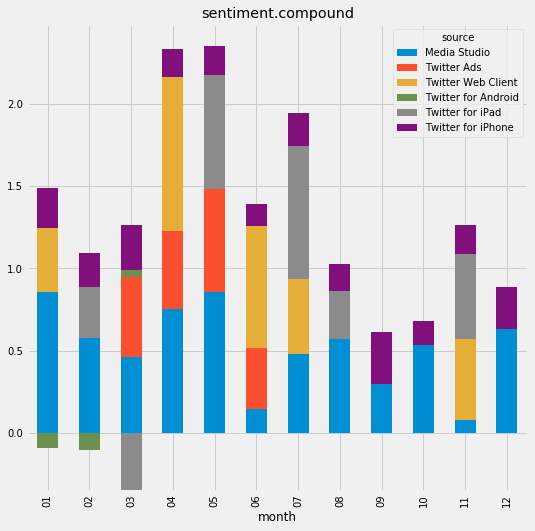

In [23]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'month', field]].pivot_table(index='month', columns='source', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

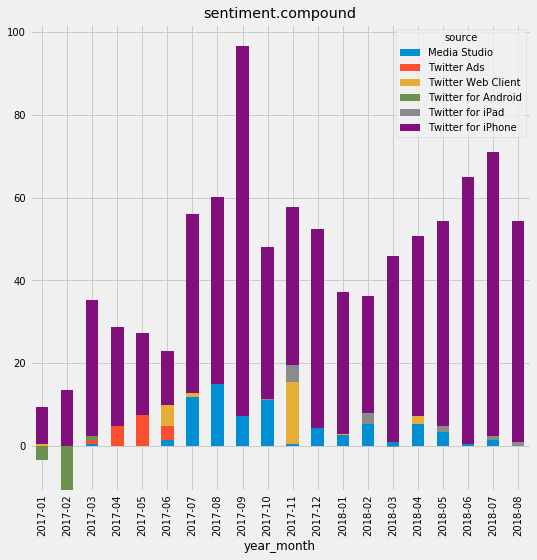

In [24]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'year_month', field]].pivot_table(index='year_month', columns='source', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

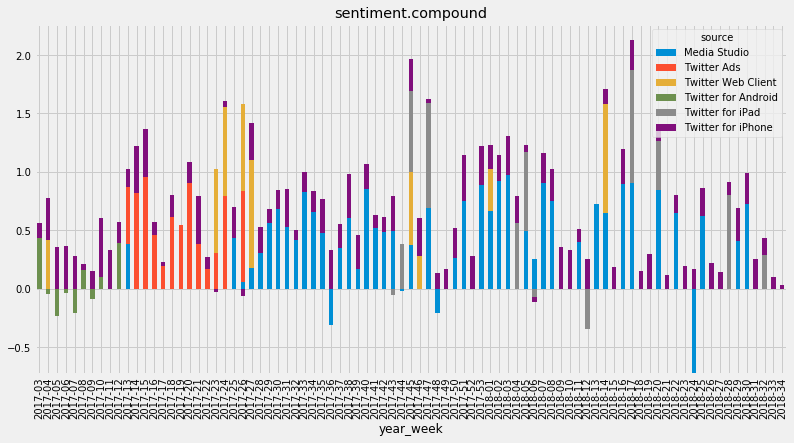

In [25]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'year_week', field]].pivot_table(index='year_week', columns='source', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

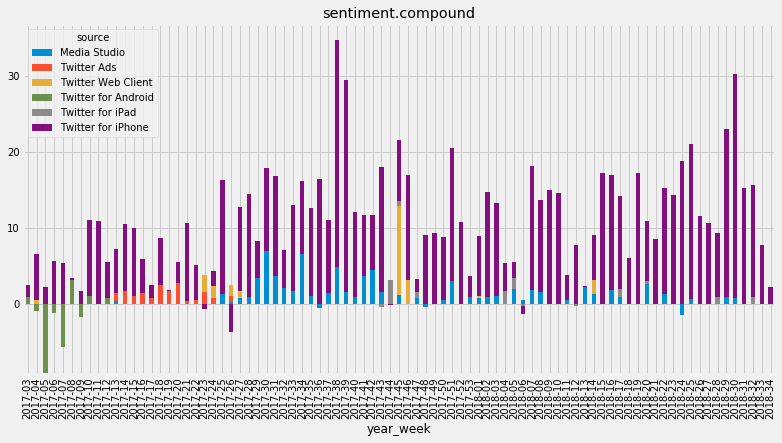

In [26]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'year_week', field]].pivot_table(index='year_week', columns='source', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

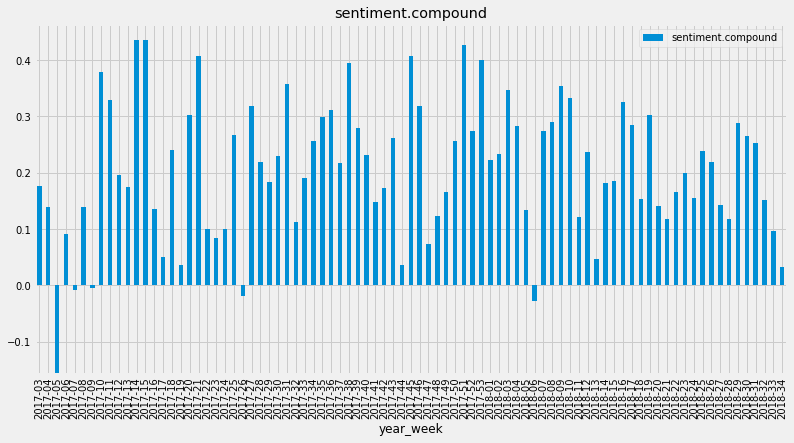

In [27]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['year_week', field]].groupby('year_week').mean()
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

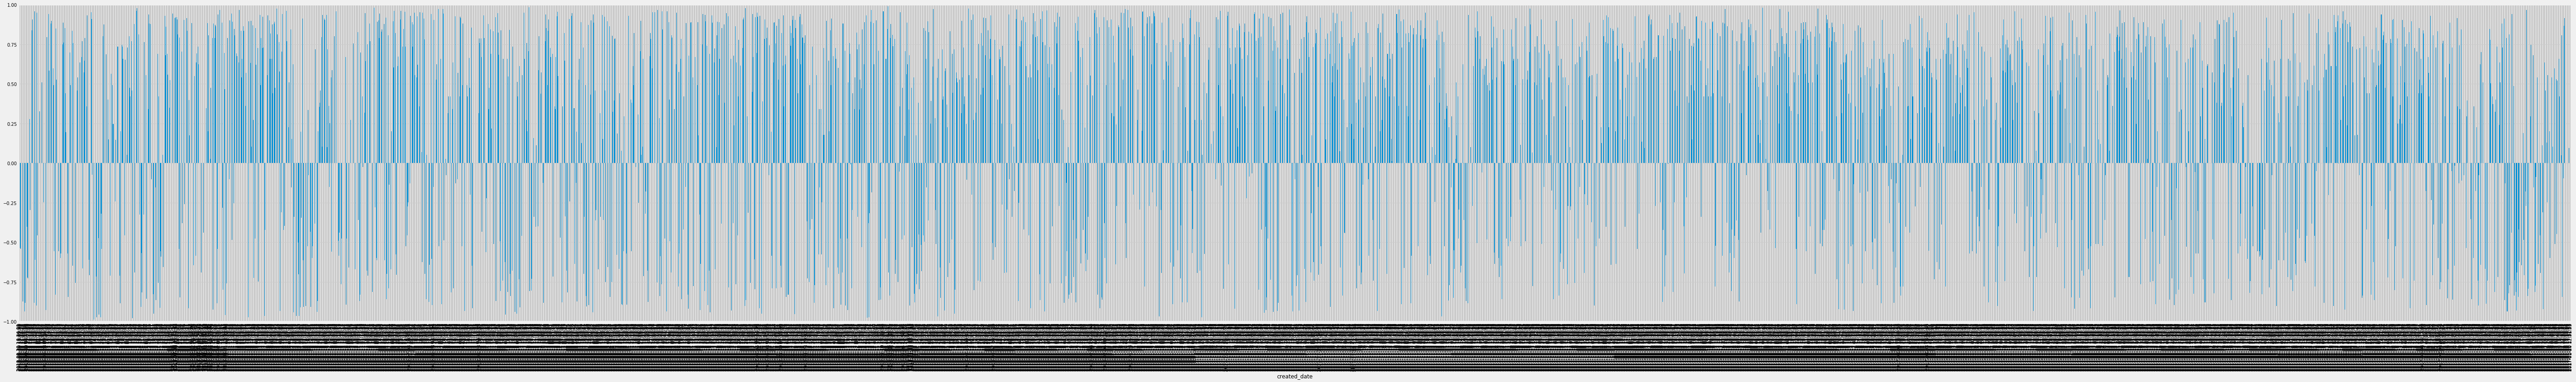

In [28]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

NOTE: Doesn't work with updated dataset (8/14/2018)

In [29]:
# tweets['user.followers_count'].plot()

In [30]:
# tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [31]:
sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
# sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
sortedSentimentPerTweet

,week,sentiment.compound,text,id
created_date,,,,
2017-12-31 23:43:04,53,0.8968,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,947614110082043904
2017-12-31 22:18:20,53,0.8915,As our Country rapidly grows stronger and smar...,947592785519173637
2017-12-31 13:36:32,53,0.8903,Why would smart voters want to put Democrats i...,947461470924820480
2017-12-31 19:06:52,53,0.8862,"What a year it’s been, and we're just getting ...",947544600918372353
2017-12-31 13:26:29,53,0.7959,"If the Dems (Crooked Hillary) got elected, you...",947458942719979520
2017-12-31 18:36:28,53,0.6114,My deepest condolences to the victims of the t...,947536951464333318
2017-12-31 04:46:21,53,0.0000,“Trump Rally: Stocks put 2017 in the record bo...,947328044821336070
2017-12-31 13:03:29,53,-0.6800,Big protests in Iran. The people are finally g...,947453152806297600
2017-12-31 22:00:21,53,-0.6927,"Iran, the Number One State of Sponsored Terror...",947588263103139841


In [32]:
df_sortedSentimentPerTweet = sortedSentimentPerTweet.reset_index()
df_sortedSentimentPerTweet['text-encoded'] = df_sortedSentimentPerTweet['text'].apply(encodeText)
df_sortedSentimentPerTweet = df_sortedSentimentPerTweet.drop('text', axis=1)
df_sortedSentimentPerTweet.to_csv('output/df_sortedSentimentPerTweet.csv')